# Overview #

This project is to find the lanes from the video taken from the camera attached to the car using advanced and effective image processing methods.

The raw data can be found from https://github.com/udacity/CarND-Advanced-Lane-Lines


Below is the summary of the process of the project:

1. Calibrate the image using given chessboard images.
1. perform image distortion correction based on calibration matrix.
1. Perform color and gradient transformation to create a thresholded binary image.
1. Apply a birds eye view perspective transform to view the lines as parallel lines.
1. Detect lane pixels and fit to find the lane boundary.
1. Determine the curvature of the lane and vehicle position with respect to center.
1. Warp the detected lane boundaries back onto the original image.
1. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

#### Import all necessary packages ####

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
%matplotlib inline

#### Create local directories ####

In [2]:
dirname1 = 'chessboard_corners'
if not os.path.exists(dirname1):
    os.mkdir(dirname1)

dirname2 = 'test_images'
if not os.path.exists(dirname2):
    os.mkdir(dirname2)

dirname3 = 'output_images'
if not os.path.exists(dirname3):
    os.mkdir(dirname3)

#### Load necessary images ####

In [3]:
# Load chessboard images
cal_images = glob.glob('../../CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')

#Load test images
test_images = glob.glob('../../CarND-Advanced-Lane-Lines/test_images/test*.jpg')

## Camera Calibration ##

In [4]:
def find_corners():
    # Arrays to store object points and image points from all images
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # prepare object points
    nx = 9#The number of inside corners in x
    ny = 6#The number of inside corners in y

    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) #x, y coordinates
    for index, fname in enumerate(cal_images):
        #read in each image
        img = mpimg.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            write_name = 'chessboard_corners'+str(index)+'.jpg'
            cv2.imwrite(os.path.join(dirname1,write_name), img)
            cv2.imshow('img', img)
            cv2.waitKey(500)

            # Save the distortion points for later use
            dist_pickle = {}
            dist_pickle["objpoints"] = objpoints
            dist_pickle["imgpoints"] = imgpoints
            pickle.dump( dist_pickle, open( "dist_pickle.p", "wb" ) )

    img_size = (img.shape[1], img.shape[0])
    
    #Perform camera calibration given obj points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    calibration_pickle = {}
    calibration_pickle["mtx"] = mtx
    calibration_pickle["dist"] = dist
    pickle.dump( calibration_pickle, open( "calibration_pickle.p", "wb" ) )
    
    cv2.destroyAllWindows()
    cv2.waitKey(1)

## Distortion Correction ##

In [39]:
def undistort_image(img, mtx, dist, debug=False): #objpoints, imgpoints):        
    #img_size = (img.shape[1], img.shape[0])
    
    #Perform camera calibration given obj points and image points
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    #undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #write_name = 'test_undist.jpg'
    #cv2.imwrite(os.path.join(dirname3,write_name), undist)
    #cv2.imshow('img', img)
    #cv2.waitKey(500)
    
    #cv2.destroyAllWindows()
    #cv2.waitKey(1)
    if debug:
        # Visualize undistortion
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=30)
        write_name = 'test_undist_2.jpg'
        temp = cv2.cvtColor(undist, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(dirname3,write_name), temp)
    
    return undist

In [34]:
find_corners()

### Test calibration by undistorting ###

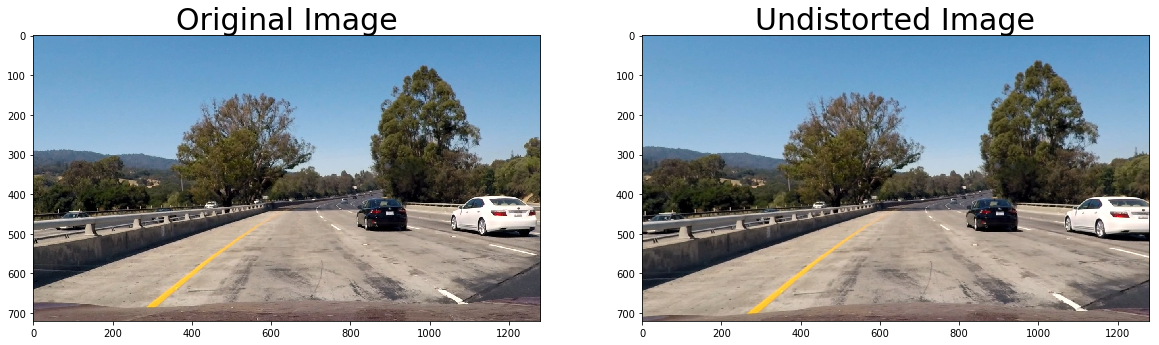

In [63]:
with open ("dist_pickle.p", "rb") as input_file:
    x = pickle.load(input_file)

objpoints = x['objpoints']
imgpoints = x['imgpoints']

with open ("calibration_pickle.p", "rb") as input_file:
    y = pickle.load(input_file)

mtx = y['mtx']
dist = y['dist']

#Test undistortion on a chessboard image
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/camera_cal/calibration2.jpg')
undistort_image(image, mtx, dist, debug=False)

#Test undistortion on a road image
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test1.jpg')
undistorted_image = undistort_image(image, mtx, dist, debug=True)

## Color Thresholding ##

In [41]:
def color_thresholding(img, s_thresh=(0, 255), debug=False):
    """
    Perform color thresholding in s space.
    :img: image input
    :s_thresh: threshold for s space in hls
    :output: combined_binary image
    """
    # convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    #Threshold color channel HLS
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    if debug:
        # Plotting thresholded images
        plt.title('S channel thresholds')
        plt.imshow(s_binary, cmap='gray')
        write_name = 'color_thresh.jpg'
        cv2.imwrite(os.path.join(dirname3,write_name), s_binary*255)
    
    return s_binary

### Testing color thresholding after distortion correction ###

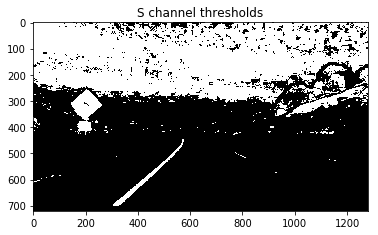

In [42]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test2.jpg')
undistorted_image = undistort_image(image, mtx, dist)
color = color_thresholding(undistorted_image, s_thresh=(100,255), debug=True)

## Sobel thresholding ##

In [43]:
def abs_sobel_thresholding(img, orientation = 'x', sobel_kernel = 3, thresh = (0,255), debug=False):
    """
    Perform gradient thresholding.
    :img: image input
    :thresh: threshold for sobel
    :orientation: x or y
    :sobel_kernel: kernel size
    :output: binary image
    """
    #Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orientation == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) #Take the derivative in x
        abs_sobel = np.absolute(sobel)
    elif orientation == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1) #Take the derivative in y
        abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    #Threshold x gradient
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    if debug:
        # Plotting thresholded images
        plt.title('Sobel thresholds')
        plt.imshow(binary, cmap='gray')
        write_name = 'sobel_thresh.jpg'
        cv2.imwrite(os.path.join(dirname3,write_name), binary*255)
    return binary

### Testing sobel thresholding after distortion correction ###

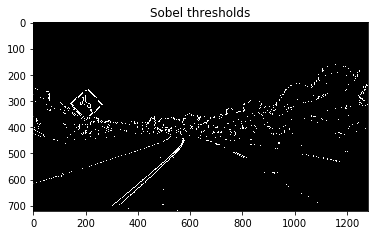

In [44]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test2.jpg')
undistorted_image = undistort_image(image, mtx, dist)
sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(40,255), debug=True)

### Testing sobel thresholding and color thresholding ###

True

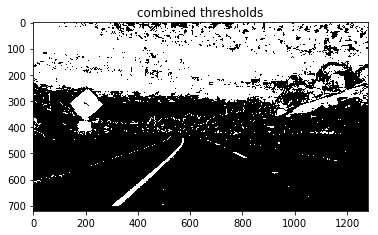

In [45]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test2.jpg')
undistorted_image = undistort_image(image, mtx, dist)
color = color_thresholding(undistorted_image, s_thresh=(100,255))
sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(50,255))

combined_image = np.zeros_like(image[:,:,0])
combined_image[((sobel_x == 1) | (color == 1))] = 255
plt.title('combined thresholds')
plt.imshow(combined_image, cmap = 'gray')

write_name = 'combined_thresh.jpg'
cv2.imwrite(os.path.join(dirname3,write_name), combined_image)

## Perspective Transform ##

In [46]:
def perspective_transform(img, mtx, dist, debug=False):
    """
    Pass in the image into this function to perform undistortion
    and perspective transformation.
    :img: image input
    :nx: number if inside corners in x
    :ny: number of inside corners in y
    :mtx: camera matrix
    :dist: distortion coefficient
    :output: warped iamge and transform matrix
    """
    img_size = (img.shape[1], img.shape[0])
    
    # Source points for perspective transformation
    top_right_src = [585. /1280.*img_size[0], 455./720.*img_size[1]]
    top_left_src = [705. /1280.*img_size[0], 455./720.*img_size[1]]
    bottom_right_src = [1270./1280.*img_size[0], 700./720.*img_size[1]]
    bottom_left_src = [190. /1280.*img_size[0], 700./720.*img_size[1]]
    
    # src coordinates
    src = np.float32([
        top_right_src, # top right
        bottom_right_src, # bottom right
        bottom_left_src, # bottom left
        top_left_src # top left
    ])
    
    # Stretch it into a square
    top_right_dest = [300. /1280.*img_size[0], 0./720.*img_size[1]]
    top_left_dest = [1000./1280.*img_size[0], 0./720.*img_size[1]]
    bottom_right_dest = [1000./1280.*img_size[0], 720./720.*img_size[1]]
    bottom_left_dest = [300. /1280.*img_size[0], 720./720.*img_size[1]]
    
    # dest coordinates
    dst = np.float32([
        top_right_dest, # top right
        bottom_right_dest, # bottom right
        bottom_left_dest, # bottom left
        top_left_dest # top left
    ])

    if(debug):
        plt.title('viewing sorce and dst points')
        plt.imshow(img, cmap='gray')
        plt.plot(src[0][0], src[0][1], 'o')
        plt.plot(src[1][0], src[1][1], 'o')
        plt.plot(src[2][0], src[2][1], 'o')
        plt.plot(src[3][0], src[3][1], 'o')

        plt.plot(dst[0][0], dst[0][1], 'o')
        plt.plot(dst[1][0], dst[1][1], 'o')
        plt.plot(dst[2][0], dst[2][1], 'o')
        plt.plot(dst[3][0], dst[3][1], 'o')
        plt.show()
    # Get perspective transformation matrix
    M = cv2.getPerspectiveTransform( src, dst)
    
    # Get inverse perspective Transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # warp the image to get birds eye view
    warped = cv2.warpPerspective(img, M, img_size, 
                                 flags = cv2.INTER_LINEAR)

    return warped, M, Minv

### Test perspective transform after distortion correction and thresholding ###

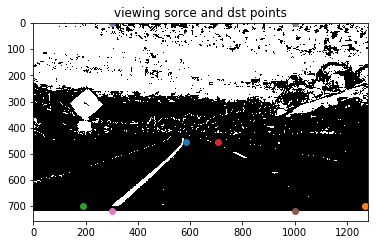

True

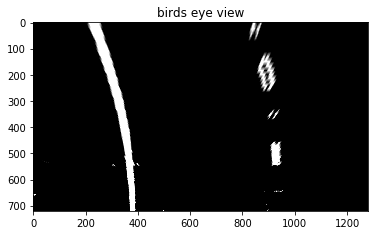

In [47]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test2.jpg')
undistorted_image = undistort_image(image, mtx, dist)
color = color_thresholding(undistorted_image, s_thresh=(100,255))
sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(50,255))

combined_image = np.zeros_like(image[:,:,0])
combined_image[((sobel_x == 1) | (color == 1))] = 255

warped, pers_mtx, inv_mtx = perspective_transform(combined_image, mtx, dist, debug=True)
plt.title('birds eye view')
plt.imshow(warped, cmap='gray')
write_name = 'birds_eye_view.jpg'
cv2.imwrite(os.path.join(dirname3,write_name), warped)

## Lane identification and fit poly line ##

In [48]:
def find_lane(img, nwindows = 9, debug = False):
    """
    This function accepts a binary warped image and returns 
    an image with lane line windows.
    :binary_warped: Input image
    :nwindows: number of sliding windows default is 9
    :output: image with lane line windows.
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    
    # create an output image to draw on and visualize the result
    out_image = np.dstack((img, img, img)) *255
    
    # find the peaks of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    left_base = np.argmax(histogram[:midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # set the height of the windows
    window_height = np.int(img.shape[0]/nwindows)
    
    # Identify x and y positions of all non zero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # current positions
    left_current = left_base
    right_current = right_base
    
    # set the width of the windows
    margin = 100
    
    #set minimum number of pixels found to recenter window
    minpix = 50
    
    # create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # step through the windows one by one
    for window in range(nwindows):
        #Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = left_current - margin
        win_xleft_high = left_current + margin
        win_xright_low = right_current - margin
        win_xright_high = right_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_image,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_image,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            left_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            right_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #if(debug):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_image[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_image[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if(debug):
        plt.imshow(out_image)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        write_name = 'Window_lane_finding.jpg'
        cv2.imwrite(os.path.join(dirname3,write_name), out_image)

    return out_image, left_fit, right_fit, left_fitx, right_fitx

### Test lane line finding ###

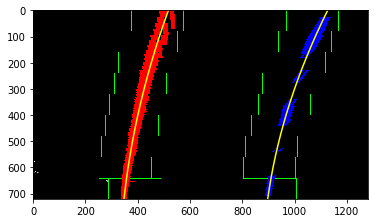

In [49]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test3.jpg')
undistorted_image = undistort_image(image, mtx, dist)
color = color_thresholding(undistorted_image, s_thresh=(100,255))
sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(50,255))

combined_image = np.zeros_like(image[:,:,0])
combined_image[((sobel_x == 1) | (color == 1))] = 255

warped, pers_mtx, inv_mtx = perspective_transform(combined_image, mtx, dist)
output, left, right, leftx, rightx = find_lane(warped, debug=True)

## Determine the curvature of the lane. ##

In [50]:
def measure_curvature(leftx, rightx, pixel=False, debug=False):
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if(debug):
        # Plot up the fake data
        mark_size = 3
        plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
        plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.plot(left_fitx, ploty, color='green', linewidth=3)
        plt.plot(right_fitx, ploty, color='green', linewidth=3)
        plt.gca().invert_yaxis() # to visualize as we do the images
    
    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    
    if(pixel):
        left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        print(left_curverad, right_curverad)
    else:
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm')
    return ([left_curverad, right_curverad], ploty)

### Test curvature ###

592.471219845 m 522.124583093 m


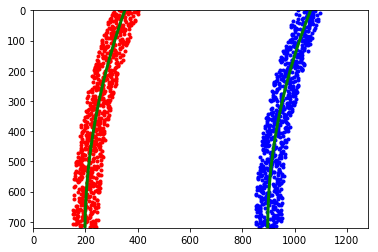

In [51]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test4.jpg')
undistorted_image = undistort_image(image, mtx, dist)
color = color_thresholding(undistorted_image, s_thresh=(100,255))
sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(50,255))

combined_image = np.zeros_like(image[:,:,0])
combined_image[((sobel_x == 1) | (color == 1))] = 255

warped, pers_mtx, inv_mtx = perspective_transform(combined_image, mtx, dist)
output, left, right, leftx, rightx = find_lane(warped)

curve, ploty = measure_curvature(left, right, debug=True)

## Warp the detected lane boundaries back onto the original image. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position. ##

In [54]:
def draw_lines_on_road(raw_image, warped, Minv, left_fitx, right_fitx, ploty, debug=False):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (raw_image.shape[1], raw_image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(raw_image, 1, newwarp, 0.3, 0)
    if (debug):
        plt.imshow(result)
        write_name = 'detected_lane_mask.jpg'
        temp = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(dirname3,write_name), temp)
    return result

557.454180268 m 545.861443933 m


array([[[183, 202, 208],
        [138, 158, 167],
        [127, 150, 166],
        ..., 
        [ 34,  71,  98],
        [  3,  35,  56],
        [ 18,  49,  67]],

       [[140, 160, 169],
        [137, 159, 172],
        [132, 157, 177],
        ..., 
        [ 90, 131, 161],
        [ 55,  91, 115],
        [  2,  34,  55]],

       [[131, 154, 170],
        [135, 160, 180],
        [121, 149, 173],
        ..., 
        [ 97, 141, 176],
        [ 92, 133, 163],
        [ 33,  73,  99]],

       ..., 
       [[131, 116, 113],
        [105,  90,  87],
        [ 98,  83,  80],
        ..., 
        [ 78,  67,  65],
        [ 91,  80,  78],
        [129, 118, 116]],

       [[147, 133, 130],
        [126, 111, 108],
        [105,  90,  87],
        ..., 
        [ 84,  73,  71],
        [119, 108, 106],
        [145, 134, 132]],

       [[155, 141, 138],
        [122, 108, 105],
        [113,  98,  95],
        ..., 
        [123, 112, 110],
        [142, 132, 130],
        [190, 180,

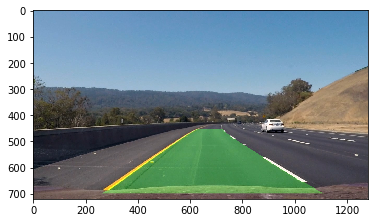

In [64]:
image = mpimg.imread('../../CarND-Advanced-Lane-Lines/test_images/test3.jpg')
undistorted_image = undistort_image(image, mtx, dist)
color = color_thresholding(undistorted_image, s_thresh=(100,255))
sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(50,255))

combined_image = np.zeros_like(image[:,:,0])
combined_image[((sobel_x == 1) | (color == 1))] = 255

warped, pers_mtx, inv_mtx = perspective_transform(combined_image, mtx, dist)
output, left, right, leftx, rightx = find_lane(warped)

curve, ploty = measure_curvature(left, right)

draw_lines_on_road(image, warped, inv_mtx, leftx, rightx, ploty, debug=True)

## Line class ##

In the block below, I define a Line class based on the Udacity-provided class. The class will fit a curve to the median of the previous N sets of lane keypoints.

In [56]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## Pipeline ##

In [57]:
def Pipeline(image, mtx, dist, debug=False):
    #Resize image for consistency
    img= cv2.resize(image, (1280,720))
    
    #Correct for distortion
    undistorted_image = undistort_image(img, mtx, dist)
    
    #Apply color and sobel thresholds then combine them
    color = color_thresholding(undistorted_image, s_thresh=(100,255), debug=debug)
    sobel_x = abs_sobel_thresholding(undistorted_image, orientation = 'x', thresh=(50,255), debug=debug)

    combined_image = np.zeros_like(image[:,:,0])
    combined_image[((sobel_x == 1) | (color == 1))] = 255
    
    #Perform perspective transformation
    warped, pers_mtx, inv_mtx = perspective_transform(combined_image, mtx, dist, debug=debug)
    
    #Find lane lines
    output, left, right, leftx, rightx = find_lane(warped, debug=debug)
    
    #Compute curvature.
    curve, ploty = measure_curvature(left, right, debug=debug)
    
    #draw polygon on original image
    origImgWithOverlay = draw_lines_on_road(image, warped, inv_mtx, leftx, rightx, ploty, debug=debug)
    
    # Draw text on the screen (in unwarped image space).  Show position error and left/right curvature values.
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    leftLaneCurvStr = "Left Curv = %6.2f m" % (curve[0])
    rightLaneCurvStr = "Right Curv = %6.2f m" % (curve[1])
    cv2.putText(origImgWithOverlay, leftLaneCurvStr,(50,100), font, 1, (255,255,255),2)
    cv2.putText(origImgWithOverlay, rightLaneCurvStr,(50,150), font, 1, (255,255,255),2)
    
    if debug:
        write_name = 'Pipeline_result.jpg'
        cv2.imwrite(os.path.join(dirname3,write_name), origImgWithOverlay)
    return origImgWithOverlay                                                                       

In [58]:
def Process_image(image, debug=False):
    return (Pipeline(image, mtx, dist, debug))

I implemented this frame grabber after running the project video through my pipeline. I noticed that when there is shadow on the road the algorithm struggles. So I wanted to extract the frames and run one frame with the shadow through the pipeline.

In [30]:
"""
Frame grabber
http://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames
"""
vidcap = cv2.VideoCapture("../../CarND-Advanced-Lane-Lines/project_video.mp4")
success,image = vidcap.read()
count = 0
success = True
while success:
    success,image = vidcap.read()
    cv2.imwrite(os.path.join(dirname2,"frame%d.jpg" % count), image)     # save frame as JPEG file
    count += 1
print("Complete!")

Complete!


Running the frame with shadow of tree on the road to see how the algorithm performs. Particularly the lane finding.

530.331166218 m 507.142896347 m


array([[[ 70,  65,  46],
        [ 65,  60,  41],
        [ 55,  52,  33],
        ..., 
        [ 73,  73,  37],
        [ 72,  72,  34],
        [ 72,  72,  34]],

       [[ 60,  55,  36],
        [ 59,  54,  35],
        [ 54,  49,  30],
        ..., 
        [ 75,  75,  39],
        [ 72,  72,  34],
        [ 72,  70,  32]],

       [[ 55,  50,  30],
        [ 55,  50,  30],
        [ 52,  47,  27],
        ..., 
        [ 75,  72,  37],
        [ 74,  72,  34],
        [ 74,  72,  34]],

       ..., 
       [[101,  81,  80],
        [100,  80,  79],
        [ 99,  79,  78],
        ..., 
        [112,  94,  92],
        [112,  94,  92],
        [112,  94,  92]],

       [[100,  80,  79],
        [100,  80,  79],
        [100,  80,  79],
        ..., 
        [115,  97,  95],
        [115,  97,  95],
        [115,  97,  95]],

       [[101,  81,  80],
        [101,  81,  80],
        [101,  81,  80],
        ..., 
        [115,  97,  95],
        [115,  97,  95],
        [116,  98,

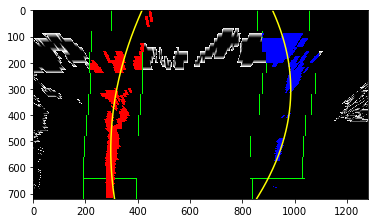

In [34]:
testing = mpimg.imread('test_images/frame1026.jpg')
Process_image(testing)

As we can see here, the curvature is drastically skewed because the shadow masks the lane line. We can try to perform some sort of shadow removal.

In [32]:
challenge_output = 'Project_video_output.mp4'
clip1 = VideoFileClip("../../CarND-Advanced-Lane-Lines/project_video.mp4")
challenge_clip = clip1.fl_image(Process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

496.25140711 m 521.258202866 m
[MoviePy] >>>> Building video Project_video_output.mp4
[MoviePy] Writing video Project_video_output.mp4


  0%|          | 1/1261 [00:00<03:05,  6.81it/s]

505.505844003 m 616.770575446 m


  0%|          | 2/1261 [00:00<03:00,  6.96it/s]

494.094870882 m 672.292550365 m


  0%|          | 3/1261 [00:00<03:03,  6.87it/s]

496.790155999 m 504.990727415 m


  0%|          | 4/1261 [00:00<02:59,  6.99it/s]

533.574439746 m 527.343429425 m


  0%|          | 5/1261 [00:00<02:56,  7.10it/s]

522.847388738 m 561.396770535 m


  0%|          | 6/1261 [00:00<02:55,  7.17it/s]

616.205928842 m 517.373308969 m


  1%|          | 7/1261 [00:00<02:53,  7.21it/s]

556.961643928 m 611.005645772 m


  1%|          | 8/1261 [00:01<02:58,  7.03it/s]

613.395702147 m 462.229278716 m


  1%|          | 9/1261 [00:01<02:57,  7.06it/s]

574.938077506 m 576.670639273 m


  1%|          | 10/1261 [00:01<02:55,  7.12it/s]

531.427261649 m 561.22700393 m


  1%|          | 11/1261 [00:01<02:54,  7.17it/s]

563.247498623 m 653.898617947 m


  1%|          | 12/1261 [00:01<02:54,  7.16it/s]

453.406584318 m 558.26000536 m


  1%|          | 13/1261 [00:01<02:54,  7.14it/s]

439.835152544 m 522.492133326 m


  1%|          | 14/1261 [00:01<02:53,  7.17it/s]

580.197931901 m 531.24148374 m


  1%|          | 15/1261 [00:02<02:53,  7.19it/s]

653.516412957 m 615.98180723 m


  1%|▏         | 16/1261 [00:02<02:54,  7.13it/s]

520.445588446 m 518.998097889 m


  1%|▏         | 17/1261 [00:02<02:54,  7.14it/s]

612.120247629 m 581.549635958 m


  1%|▏         | 18/1261 [00:02<02:52,  7.21it/s]

548.555855892 m 572.211013561 m


  2%|▏         | 19/1261 [00:02<02:51,  7.26it/s]

672.116216377 m 564.38043606 m


  2%|▏         | 20/1261 [00:02<02:52,  7.21it/s]

659.417396211 m 529.036806505 m


  2%|▏         | 21/1261 [00:02<02:52,  7.18it/s]

670.074020351 m 489.10503479 m


  2%|▏         | 22/1261 [00:03<02:51,  7.22it/s]

524.189099004 m 542.28363531 m


  2%|▏         | 23/1261 [00:03<02:51,  7.23it/s]

544.162233449 m 542.082977775 m


  2%|▏         | 24/1261 [00:03<02:50,  7.28it/s]

505.300393351 m 601.518421148 m


  2%|▏         | 25/1261 [00:03<02:48,  7.32it/s]

567.738578922 m 562.11602996 m


  2%|▏         | 26/1261 [00:03<02:48,  7.34it/s]

511.010056999 m 618.61002853 m


  2%|▏         | 27/1261 [00:03<02:46,  7.40it/s]

571.759388467 m 512.822503686 m


  2%|▏         | 28/1261 [00:03<03:01,  6.80it/s]

523.271242 m 520.161112687 m
582.445026065 m 546.012856801 m


  2%|▏         | 30/1261 [00:04<03:12,  6.39it/s]

511.361499091 m 578.529092938 m


  2%|▏         | 31/1261 [00:04<03:07,  6.57it/s]

525.956907219 m 497.146772063 m


  3%|▎         | 32/1261 [00:04<03:08,  6.51it/s]

632.911892399 m 474.673777313 m


  3%|▎         | 33/1261 [00:04<03:14,  6.30it/s]

615.476853287 m 553.611551047 m


  3%|▎         | 34/1261 [00:04<03:15,  6.26it/s]

535.712980841 m 540.650101213 m


  3%|▎         | 35/1261 [00:05<03:12,  6.36it/s]

523.850742108 m 495.621135898 m


  3%|▎         | 36/1261 [00:05<03:11,  6.41it/s]

581.874738743 m 577.606941418 m


  3%|▎         | 37/1261 [00:05<03:03,  6.68it/s]

512.754510768 m 548.373347457 m


  3%|▎         | 38/1261 [00:05<02:58,  6.85it/s]

722.18940414 m 542.142517188 m


  3%|▎         | 39/1261 [00:05<02:55,  6.98it/s]

618.276388158 m 606.841517519 m


  3%|▎         | 40/1261 [00:05<02:52,  7.08it/s]

626.601817897 m 634.252956841 m


  3%|▎         | 41/1261 [00:05<02:49,  7.21it/s]

574.619646711 m 681.295758899 m


  3%|▎         | 42/1261 [00:06<02:47,  7.29it/s]

538.721595425 m 516.314588634 m


  3%|▎         | 43/1261 [00:06<02:46,  7.31it/s]

601.38310704 m 509.19661695 m


  3%|▎         | 44/1261 [00:06<02:43,  7.45it/s]

594.239937864 m 683.378185081 m


  4%|▎         | 45/1261 [00:06<02:39,  7.63it/s]

526.800267695 m 574.70237555 m


  4%|▎         | 46/1261 [00:06<02:36,  7.75it/s]

558.066837458 m 446.835027547 m


  4%|▎         | 47/1261 [00:06<02:36,  7.75it/s]

493.408703385 m 690.215373107 m


  4%|▍         | 48/1261 [00:06<02:36,  7.74it/s]

558.290554797 m 521.479437617 m


  4%|▍         | 49/1261 [00:06<02:36,  7.74it/s]

627.35121694 m 604.76702041 m


  4%|▍         | 50/1261 [00:07<02:36,  7.74it/s]

543.534993941 m 510.45751608 m


  4%|▍         | 51/1261 [00:07<02:38,  7.62it/s]

586.544587899 m 558.820342974 m


  4%|▍         | 52/1261 [00:07<02:37,  7.66it/s]

564.23079807 m 571.634244173 m


  4%|▍         | 53/1261 [00:07<02:38,  7.63it/s]

541.681613121 m 577.984523754 m


  4%|▍         | 54/1261 [00:07<02:38,  7.60it/s]

570.402135768 m 538.883205605 m


  4%|▍         | 55/1261 [00:07<02:40,  7.53it/s]

559.931660451 m 473.119800747 m


  4%|▍         | 56/1261 [00:07<02:39,  7.55it/s]

648.546348478 m 613.502175135 m


  5%|▍         | 57/1261 [00:07<02:41,  7.46it/s]

585.845624819 m 535.600493995 m


  5%|▍         | 58/1261 [00:08<02:39,  7.56it/s]

571.450528768 m 494.335708041 m


  5%|▍         | 59/1261 [00:08<02:37,  7.64it/s]

610.654820759 m 530.848816775 m


  5%|▍         | 60/1261 [00:08<02:35,  7.72it/s]

559.222370961 m 567.927830098 m


  5%|▍         | 61/1261 [00:08<02:35,  7.72it/s]

509.672869622 m 587.088275886 m


  5%|▍         | 62/1261 [00:08<02:35,  7.73it/s]

689.006398432 m 476.8148158 m


  5%|▍         | 63/1261 [00:08<02:34,  7.75it/s]

534.268766336 m 562.625191285 m


  5%|▌         | 64/1261 [00:08<02:34,  7.77it/s]

592.836975467 m 520.822479161 m


  5%|▌         | 65/1261 [00:09<02:34,  7.73it/s]

617.267813746 m 486.1969687 m


  5%|▌         | 66/1261 [00:09<02:33,  7.78it/s]

496.320253184 m 531.114876724 m


  5%|▌         | 67/1261 [00:09<02:34,  7.75it/s]

578.112227708 m 566.5426408 m


  5%|▌         | 68/1261 [00:09<02:33,  7.77it/s]

552.347454189 m 512.283806689 m


  5%|▌         | 69/1261 [00:09<02:32,  7.82it/s]

567.094978035 m 585.184271735 m


  6%|▌         | 70/1261 [00:09<02:32,  7.79it/s]

480.637629241 m 557.877386913 m


  6%|▌         | 71/1261 [00:09<02:34,  7.71it/s]

487.745410538 m 519.129353758 m


  6%|▌         | 72/1261 [00:09<02:34,  7.71it/s]

558.374647057 m 545.953549365 m


  6%|▌         | 73/1261 [00:10<02:33,  7.74it/s]

546.194185456 m 535.852586644 m


  6%|▌         | 74/1261 [00:10<02:32,  7.77it/s]

569.945439319 m 517.478642104 m


  6%|▌         | 75/1261 [00:10<02:32,  7.76it/s]

548.451163712 m 563.151211618 m


  6%|▌         | 76/1261 [00:10<02:33,  7.72it/s]

484.999420685 m 523.189517698 m


  6%|▌         | 77/1261 [00:10<02:33,  7.69it/s]

552.956249711 m 598.163581612 m


  6%|▌         | 78/1261 [00:10<02:34,  7.66it/s]

476.607101169 m 654.421656997 m


  6%|▋         | 79/1261 [00:10<02:34,  7.67it/s]

529.887146824 m 479.585315723 m


  6%|▋         | 80/1261 [00:10<02:34,  7.63it/s]

536.031664587 m 506.245184828 m


  6%|▋         | 81/1261 [00:11<02:34,  7.64it/s]

613.067847499 m 578.822212112 m


  7%|▋         | 82/1261 [00:11<02:33,  7.68it/s]

567.579741905 m 470.374455204 m


  7%|▋         | 83/1261 [00:11<02:32,  7.71it/s]

514.134601731 m 522.883755021 m


  7%|▋         | 84/1261 [00:11<02:32,  7.74it/s]

501.865104623 m 514.880293854 m


  7%|▋         | 85/1261 [00:11<02:31,  7.78it/s]

562.623258549 m 542.025165291 m


  7%|▋         | 86/1261 [00:11<02:32,  7.71it/s]

609.557166566 m 575.568243643 m


  7%|▋         | 87/1261 [00:11<02:32,  7.72it/s]

559.270334255 m 546.937292712 m


  7%|▋         | 88/1261 [00:11<02:31,  7.73it/s]

523.153687536 m 543.088118103 m


  7%|▋         | 89/1261 [00:12<02:32,  7.70it/s]

523.420738439 m 561.952676139 m


  7%|▋         | 90/1261 [00:12<02:32,  7.67it/s]

537.707882272 m 534.067313134 m


  7%|▋         | 91/1261 [00:12<02:32,  7.65it/s]

505.474426739 m 509.964233986 m


  7%|▋         | 92/1261 [00:12<02:31,  7.72it/s]

593.950090654 m 553.624183518 m


  7%|▋         | 93/1261 [00:12<02:32,  7.66it/s]

452.725606842 m 553.844661958 m


  7%|▋         | 94/1261 [00:12<02:31,  7.69it/s]

656.412266222 m 562.296380408 m


  8%|▊         | 95/1261 [00:12<02:33,  7.60it/s]

564.118367644 m 576.926145711 m


  8%|▊         | 96/1261 [00:13<02:32,  7.62it/s]

613.46514558 m 583.255633308 m


  8%|▊         | 97/1261 [00:13<02:32,  7.63it/s]

530.958953425 m 447.213392455 m


  8%|▊         | 98/1261 [00:13<02:31,  7.68it/s]

621.065755631 m 543.884701379 m


  8%|▊         | 99/1261 [00:13<02:31,  7.69it/s]

702.844666067 m 561.683632744 m


  8%|▊         | 100/1261 [00:13<02:30,  7.72it/s]

595.612899319 m 562.389223303 m


  8%|▊         | 101/1261 [00:13<02:28,  7.79it/s]

574.365167213 m 610.655247267 m


  8%|▊         | 102/1261 [00:13<02:31,  7.67it/s]

714.85845786 m 531.224452348 m


  8%|▊         | 103/1261 [00:13<02:33,  7.56it/s]

547.799427544 m 605.806128446 m


  8%|▊         | 104/1261 [00:14<02:31,  7.64it/s]

503.316877111 m 513.447618672 m


  8%|▊         | 105/1261 [00:14<02:29,  7.71it/s]

591.739491142 m 562.342067845 m


  8%|▊         | 106/1261 [00:14<02:29,  7.74it/s]

612.805465993 m 503.697846636 m


  8%|▊         | 107/1261 [00:14<02:30,  7.66it/s]

590.043556218 m 620.830768367 m


  9%|▊         | 108/1261 [00:14<02:30,  7.68it/s]

546.126805223 m 651.98908966 m


  9%|▊         | 109/1261 [00:14<02:30,  7.66it/s]

583.55020261 m 546.490770866 m


  9%|▊         | 110/1261 [00:14<02:29,  7.72it/s]

526.671821535 m 574.705517397 m


  9%|▉         | 111/1261 [00:14<02:29,  7.67it/s]

529.451384935 m 467.746303495 m


  9%|▉         | 112/1261 [00:15<02:28,  7.75it/s]

578.639259803 m 551.421789642 m


  9%|▉         | 113/1261 [00:15<02:27,  7.78it/s]

564.805818865 m 582.104694078 m


  9%|▉         | 114/1261 [00:15<02:27,  7.76it/s]

539.514676172 m 522.515349176 m


  9%|▉         | 115/1261 [00:15<02:28,  7.72it/s]

556.483826272 m 484.799907644 m


  9%|▉         | 116/1261 [00:15<02:28,  7.73it/s]

542.888887374 m 516.439331895 m


  9%|▉         | 117/1261 [00:15<02:28,  7.72it/s]

579.54918502 m 562.521241563 m


  9%|▉         | 118/1261 [00:15<02:27,  7.77it/s]

527.486050398 m 603.41857495 m


  9%|▉         | 119/1261 [00:16<02:28,  7.70it/s]

612.420183789 m 502.686222362 m


 10%|▉         | 120/1261 [00:16<02:26,  7.77it/s]

614.642328821 m 538.747508388 m


 10%|▉         | 121/1261 [00:16<02:26,  7.76it/s]

594.012878613 m 442.839265573 m


 10%|▉         | 122/1261 [00:16<02:25,  7.82it/s]

506.472516467 m 581.396345742 m


 10%|▉         | 123/1261 [00:16<02:25,  7.80it/s]

493.380877376 m 545.41091891 m


 10%|▉         | 124/1261 [00:16<02:25,  7.79it/s]

595.766187963 m 454.853265069 m


 10%|▉         | 125/1261 [00:16<02:25,  7.83it/s]

603.727180058 m 466.302834749 m


 10%|▉         | 126/1261 [00:16<02:26,  7.76it/s]

483.834098523 m 576.284211002 m


 10%|█         | 127/1261 [00:17<02:25,  7.81it/s]

684.795400699 m 492.056914924 m


 10%|█         | 128/1261 [00:17<02:25,  7.76it/s]

478.006520008 m 578.10839683 m


 10%|█         | 129/1261 [00:17<02:26,  7.71it/s]

616.820628463 m 553.964448998 m


 10%|█         | 130/1261 [00:17<02:27,  7.66it/s]

492.920653606 m 506.827734746 m


 10%|█         | 131/1261 [00:17<02:26,  7.72it/s]

503.69532995 m 470.132598113 m


 10%|█         | 132/1261 [00:17<02:24,  7.79it/s]

614.907642074 m 536.252015666 m


 11%|█         | 133/1261 [00:17<02:24,  7.79it/s]

593.91376491 m 524.715303135 m


 11%|█         | 134/1261 [00:17<02:25,  7.74it/s]

483.050676313 m 506.409087759 m


 11%|█         | 135/1261 [00:18<02:25,  7.73it/s]

608.082096134 m 545.054955982 m


 11%|█         | 136/1261 [00:18<02:26,  7.70it/s]

578.348161325 m 600.939858661 m


 11%|█         | 137/1261 [00:18<02:25,  7.71it/s]

542.847731907 m 600.357329739 m


 11%|█         | 138/1261 [00:18<02:25,  7.71it/s]

660.600286181 m 539.296197849 m


 11%|█         | 139/1261 [00:18<02:26,  7.66it/s]

577.43946357 m 495.842340484 m


 11%|█         | 140/1261 [00:18<02:25,  7.71it/s]

582.150016169 m 492.255413091 m


 11%|█         | 141/1261 [00:18<02:27,  7.60it/s]

565.962196067 m 579.331895575 m


 11%|█▏        | 142/1261 [00:18<02:26,  7.66it/s]

672.098851884 m 604.10414773 m


 11%|█▏        | 143/1261 [00:19<02:26,  7.62it/s]

590.900923652 m 649.868330597 m


 11%|█▏        | 144/1261 [00:19<02:25,  7.67it/s]

618.242038427 m 570.11082222 m
557.478401967 m 697.85116088 m


 12%|█▏        | 146/1261 [00:19<02:42,  6.86it/s]

566.624068675 m 483.667742692 m


 12%|█▏        | 147/1261 [00:19<02:37,  7.05it/s]

650.393521441 m 518.248486347 m


 12%|█▏        | 148/1261 [00:19<02:33,  7.26it/s]

547.237208547 m 543.930507249 m


 12%|█▏        | 149/1261 [00:19<02:31,  7.35it/s]

633.827642228 m 634.650226958 m


 12%|█▏        | 150/1261 [00:20<02:29,  7.42it/s]

671.695737053 m 535.75962632 m


 12%|█▏        | 151/1261 [00:20<02:30,  7.39it/s]

459.826144494 m 542.885190281 m


 12%|█▏        | 152/1261 [00:20<02:29,  7.41it/s]

559.945113479 m 543.272719607 m


 12%|█▏        | 153/1261 [00:20<02:28,  7.47it/s]

593.28225842 m 569.599403793 m


 12%|█▏        | 154/1261 [00:20<02:27,  7.51it/s]

507.713493892 m 538.641270055 m


 12%|█▏        | 155/1261 [00:20<02:28,  7.45it/s]

521.722385361 m 499.442789061 m


 12%|█▏        | 156/1261 [00:20<02:26,  7.53it/s]

497.15567872 m 529.05125258 m


 12%|█▏        | 157/1261 [00:21<02:28,  7.42it/s]

552.007961407 m 492.425035531 m


 13%|█▎        | 158/1261 [00:21<02:30,  7.34it/s]

521.147015824 m 825.470848064 m


 13%|█▎        | 159/1261 [00:21<02:30,  7.34it/s]

552.3513382 m 547.277383955 m


 13%|█▎        | 160/1261 [00:21<02:29,  7.35it/s]

624.535393039 m 539.491906889 m


 13%|█▎        | 161/1261 [00:21<02:28,  7.42it/s]

575.394278728 m 554.068919049 m


 13%|█▎        | 162/1261 [00:21<02:27,  7.48it/s]

545.904690107 m 621.937197091 m


 13%|█▎        | 163/1261 [00:21<02:26,  7.49it/s]

600.02933862 m 467.728705728 m


 13%|█▎        | 164/1261 [00:21<02:26,  7.48it/s]

662.453220051 m 535.922751558 m


 13%|█▎        | 165/1261 [00:22<02:26,  7.50it/s]

702.596118809 m 504.320423262 m


 13%|█▎        | 166/1261 [00:22<02:25,  7.51it/s]

555.509970233 m 559.341609953 m


 13%|█▎        | 167/1261 [00:22<02:25,  7.51it/s]

530.132032951 m 580.284846785 m


 13%|█▎        | 168/1261 [00:22<02:25,  7.50it/s]

550.658345437 m 595.873890163 m


 13%|█▎        | 169/1261 [00:22<02:25,  7.51it/s]

580.041247161 m 507.850972045 m


 13%|█▎        | 170/1261 [00:22<02:25,  7.50it/s]

532.01133473 m 490.206496325 m


 14%|█▎        | 171/1261 [00:22<02:27,  7.38it/s]

492.020672455 m 609.290264538 m


 14%|█▎        | 172/1261 [00:23<02:28,  7.34it/s]

531.53504509 m 488.321987468 m


 14%|█▎        | 173/1261 [00:23<02:27,  7.37it/s]

581.478258402 m 567.556504285 m


 14%|█▍        | 174/1261 [00:23<02:27,  7.39it/s]

599.34338631 m 575.032673316 m


 14%|█▍        | 175/1261 [00:23<02:26,  7.41it/s]

530.637975135 m 623.182541836 m


 14%|█▍        | 176/1261 [00:23<02:25,  7.45it/s]

608.599437127 m 606.429715781 m


 14%|█▍        | 177/1261 [00:23<02:25,  7.45it/s]

620.386946477 m 493.519102832 m


 14%|█▍        | 178/1261 [00:23<02:26,  7.40it/s]

543.180879449 m 568.684531339 m


 14%|█▍        | 179/1261 [00:23<02:25,  7.43it/s]

741.684044983 m 562.064720468 m


 14%|█▍        | 180/1261 [00:24<02:24,  7.46it/s]

584.639437812 m 541.651460188 m


 14%|█▍        | 181/1261 [00:24<02:23,  7.55it/s]

532.414941036 m 564.74874562 m


 14%|█▍        | 182/1261 [00:24<02:24,  7.44it/s]

540.988937509 m 529.477311094 m


 15%|█▍        | 183/1261 [00:24<02:24,  7.46it/s]

579.077306769 m 709.67513691 m


 15%|█▍        | 184/1261 [00:24<02:27,  7.28it/s]

505.255983851 m 552.642664429 m


 15%|█▍        | 185/1261 [00:24<02:28,  7.27it/s]

589.171203612 m 515.555445687 m


 15%|█▍        | 186/1261 [00:24<02:27,  7.27it/s]

513.871048405 m 515.986303293 m


 15%|█▍        | 187/1261 [00:25<02:26,  7.35it/s]

606.854842405 m 598.204816115 m


 15%|█▍        | 188/1261 [00:25<02:24,  7.41it/s]

612.062389871 m 519.07536356 m


 15%|█▍        | 189/1261 [00:25<02:24,  7.43it/s]

513.822405219 m 506.461110441 m


 15%|█▌        | 190/1261 [00:25<02:25,  7.37it/s]

574.577578242 m 487.544927291 m


 15%|█▌        | 191/1261 [00:25<02:24,  7.38it/s]

559.739439445 m 466.932129987 m


 15%|█▌        | 192/1261 [00:25<02:24,  7.38it/s]

547.976529884 m 572.495466826 m


 15%|█▌        | 193/1261 [00:25<02:25,  7.33it/s]

523.085115042 m 557.366307041 m


 15%|█▌        | 194/1261 [00:26<02:25,  7.34it/s]

687.052168061 m 515.343100091 m


 15%|█▌        | 195/1261 [00:26<02:24,  7.37it/s]

507.474148089 m 524.721914879 m


 16%|█▌        | 196/1261 [00:26<02:23,  7.40it/s]

492.543333149 m 500.808714465 m


 16%|█▌        | 197/1261 [00:26<02:23,  7.44it/s]

536.841675722 m 535.226838798 m


 16%|█▌        | 198/1261 [00:26<02:25,  7.29it/s]

520.488149145 m 573.779292445 m


 16%|█▌        | 199/1261 [00:26<02:27,  7.18it/s]

649.491576915 m 557.305122442 m


 16%|█▌        | 200/1261 [00:26<02:26,  7.25it/s]

499.459686451 m 539.960638011 m


 16%|█▌        | 201/1261 [00:26<02:23,  7.40it/s]

566.20920909 m 518.345719003 m


 16%|█▌        | 202/1261 [00:27<02:19,  7.58it/s]

556.597277744 m 512.334064816 m


 16%|█▌        | 203/1261 [00:27<02:17,  7.68it/s]

545.710415057 m 545.90140072 m


 16%|█▌        | 204/1261 [00:27<02:16,  7.72it/s]

601.99337715 m 521.738122248 m


 16%|█▋        | 205/1261 [00:27<02:18,  7.64it/s]

597.517352102 m 498.719135003 m


 16%|█▋        | 206/1261 [00:27<02:18,  7.64it/s]

798.949775542 m 502.823789571 m


 16%|█▋        | 207/1261 [00:27<02:18,  7.63it/s]

578.284362545 m 594.773176297 m


 16%|█▋        | 208/1261 [00:27<02:19,  7.54it/s]

611.988168674 m 503.248349696 m


 17%|█▋        | 209/1261 [00:28<02:18,  7.57it/s]

563.912027071 m 536.944881514 m


 17%|█▋        | 210/1261 [00:28<02:18,  7.58it/s]

595.412959629 m 624.497042451 m


 17%|█▋        | 211/1261 [00:28<02:19,  7.53it/s]

602.198437295 m 535.144892353 m


 17%|█▋        | 212/1261 [00:28<02:18,  7.57it/s]

533.962393826 m 503.162965032 m


 17%|█▋        | 213/1261 [00:28<02:19,  7.50it/s]

559.562456348 m 504.864273317 m


 17%|█▋        | 214/1261 [00:28<02:19,  7.52it/s]

536.115242166 m 627.211657348 m


 17%|█▋        | 215/1261 [00:28<02:19,  7.51it/s]

637.996511816 m 531.180719149 m


 17%|█▋        | 216/1261 [00:28<02:19,  7.52it/s]

515.136264214 m 573.086673324 m


 17%|█▋        | 217/1261 [00:29<02:20,  7.43it/s]

547.93475121 m 551.500150476 m


 17%|█▋        | 218/1261 [00:29<02:19,  7.45it/s]

572.876450314 m 679.552956155 m


 17%|█▋        | 219/1261 [00:29<02:21,  7.35it/s]

548.15834166 m 524.970767942 m


 17%|█▋        | 220/1261 [00:29<02:19,  7.44it/s]

528.371894232 m 459.229453126 m


 18%|█▊        | 221/1261 [00:29<02:20,  7.40it/s]

539.871393709 m 642.957845066 m


 18%|█▊        | 222/1261 [00:29<02:19,  7.44it/s]

567.805528143 m 538.24368635 m


 18%|█▊        | 223/1261 [00:29<02:19,  7.43it/s]

598.254918084 m 437.089079378 m


 18%|█▊        | 224/1261 [00:30<02:21,  7.35it/s]

624.990891303 m 598.285490369 m


 18%|█▊        | 225/1261 [00:30<02:21,  7.34it/s]

535.566050607 m 575.652335503 m


 18%|█▊        | 226/1261 [00:30<02:18,  7.46it/s]

558.524962867 m 544.286422986 m


 18%|█▊        | 227/1261 [00:30<02:22,  7.25it/s]

465.637155119 m 616.187212244 m


 18%|█▊        | 228/1261 [00:30<02:20,  7.33it/s]

545.701858428 m 474.253743133 m


 18%|█▊        | 229/1261 [00:30<02:20,  7.36it/s]

506.358821419 m 524.362702565 m


 18%|█▊        | 230/1261 [00:30<02:19,  7.41it/s]

547.987811802 m 492.350730442 m


 18%|█▊        | 231/1261 [00:30<02:18,  7.42it/s]

623.826385396 m 566.067636517 m


 18%|█▊        | 232/1261 [00:31<02:18,  7.44it/s]

504.127359885 m 519.897531371 m


 18%|█▊        | 233/1261 [00:31<02:17,  7.48it/s]

532.075183331 m 532.286429204 m


 19%|█▊        | 234/1261 [00:31<02:16,  7.51it/s]

565.682162263 m 640.42596766 m


 19%|█▊        | 235/1261 [00:31<02:18,  7.42it/s]

535.231969072 m 448.624188583 m


 19%|█▊        | 236/1261 [00:31<02:17,  7.47it/s]

529.500048323 m 528.40836745 m


 19%|█▉        | 237/1261 [00:31<02:17,  7.46it/s]

526.325752944 m 555.660538976 m


 19%|█▉        | 238/1261 [00:31<02:17,  7.42it/s]

581.950914031 m 603.013383964 m


 19%|█▉        | 239/1261 [00:32<02:18,  7.37it/s]

520.983481869 m 634.481308812 m


 19%|█▉        | 240/1261 [00:32<02:17,  7.42it/s]

508.102654309 m 719.155746465 m


 19%|█▉        | 241/1261 [00:32<02:17,  7.44it/s]

453.736752964 m 505.267523505 m


 19%|█▉        | 242/1261 [00:32<02:16,  7.48it/s]

635.03788564 m 593.831971888 m


 19%|█▉        | 243/1261 [00:32<02:16,  7.48it/s]

516.761629476 m 579.895884284 m


 19%|█▉        | 244/1261 [00:32<02:14,  7.57it/s]

551.9002458 m 460.070660447 m


 19%|█▉        | 245/1261 [00:32<02:14,  7.54it/s]

548.139868298 m 503.862540741 m


 20%|█▉        | 246/1261 [00:32<02:14,  7.57it/s]

569.57392524 m 523.025716178 m


 20%|█▉        | 247/1261 [00:33<02:13,  7.58it/s]

573.215511077 m 559.013805749 m


 20%|█▉        | 248/1261 [00:33<02:13,  7.59it/s]

555.811621536 m 533.013996628 m


 20%|█▉        | 249/1261 [00:33<02:14,  7.55it/s]

475.08742529 m 616.432164511 m


 20%|█▉        | 250/1261 [00:33<02:12,  7.62it/s]

504.942168813 m 602.217577037 m


 20%|█▉        | 251/1261 [00:33<02:12,  7.61it/s]

606.715248632 m 486.801921508 m


 20%|█▉        | 252/1261 [00:33<02:11,  7.65it/s]

602.824782268 m 652.225417613 m


 20%|██        | 253/1261 [00:33<02:12,  7.63it/s]

579.10528821 m 555.411994487 m


 20%|██        | 254/1261 [00:34<02:10,  7.71it/s]

662.960239803 m 510.879722273 m


 20%|██        | 255/1261 [00:34<02:10,  7.72it/s]

574.364116797 m 550.044355102 m


 20%|██        | 256/1261 [00:34<02:09,  7.77it/s]

538.608315973 m 569.468244233 m


 20%|██        | 257/1261 [00:34<02:09,  7.77it/s]

439.160174048 m 497.771846875 m


 20%|██        | 258/1261 [00:34<02:09,  7.75it/s]

509.483431981 m 535.406249826 m


 21%|██        | 259/1261 [00:34<02:10,  7.70it/s]

541.073258123 m 553.107311815 m


 21%|██        | 260/1261 [00:34<02:09,  7.72it/s]

517.352145687 m 572.7749617 m


 21%|██        | 261/1261 [00:34<02:09,  7.74it/s]

522.518699879 m 517.414736518 m


 21%|██        | 262/1261 [00:35<02:09,  7.70it/s]

526.619400037 m 570.956402893 m


 21%|██        | 263/1261 [00:35<02:08,  7.74it/s]

509.8747196 m 465.545895843 m


 21%|██        | 264/1261 [00:35<02:08,  7.75it/s]

636.304592042 m 500.40050753 m


 21%|██        | 265/1261 [00:35<02:10,  7.64it/s]

506.186145467 m 533.411179938 m


 21%|██        | 266/1261 [00:35<02:10,  7.62it/s]

574.23207847 m 573.355704983 m


 21%|██        | 267/1261 [00:35<02:08,  7.72it/s]

583.145727399 m 517.559689816 m


 21%|██▏       | 268/1261 [00:35<02:08,  7.71it/s]

600.335320827 m 502.568408629 m


 21%|██▏       | 269/1261 [00:35<02:08,  7.72it/s]

562.004715517 m 502.10195523 m


 21%|██▏       | 270/1261 [00:36<02:08,  7.70it/s]

607.274641914 m 628.096945009 m


 21%|██▏       | 271/1261 [00:36<02:08,  7.72it/s]

461.810198145 m 614.572489059 m


 22%|██▏       | 272/1261 [00:36<02:07,  7.76it/s]

566.367635466 m 559.547952316 m


 22%|██▏       | 273/1261 [00:36<02:07,  7.75it/s]

503.096147236 m 518.873273192 m


 22%|██▏       | 274/1261 [00:36<02:08,  7.70it/s]

520.543966041 m 580.166243278 m


 22%|██▏       | 275/1261 [00:36<02:07,  7.72it/s]

521.867742296 m 525.644134234 m


 22%|██▏       | 276/1261 [00:36<02:08,  7.67it/s]

610.320116988 m 571.587198249 m


 22%|██▏       | 277/1261 [00:37<02:07,  7.69it/s]

573.436940185 m 541.11686194 m


 22%|██▏       | 278/1261 [00:37<02:07,  7.72it/s]

613.168791219 m 557.522749555 m


 22%|██▏       | 279/1261 [00:37<02:07,  7.71it/s]

499.675896896 m 517.42827907 m


 22%|██▏       | 280/1261 [00:37<02:06,  7.78it/s]

661.737727358 m 520.971074798 m


 22%|██▏       | 281/1261 [00:37<02:05,  7.78it/s]

581.727655175 m 562.898475405 m


 22%|██▏       | 282/1261 [00:37<02:05,  7.81it/s]

489.683976293 m 474.369614935 m


 22%|██▏       | 283/1261 [00:37<02:05,  7.79it/s]

488.1871039 m 536.370466013 m


 23%|██▎       | 284/1261 [00:37<02:07,  7.67it/s]

529.934957525 m 587.856831654 m


 23%|██▎       | 285/1261 [00:38<02:06,  7.72it/s]

605.2194805 m 498.727886066 m


 23%|██▎       | 286/1261 [00:38<02:05,  7.76it/s]

543.579359301 m 594.685841525 m


 23%|██▎       | 287/1261 [00:38<02:05,  7.79it/s]

581.14553687 m 625.99511778 m


 23%|██▎       | 288/1261 [00:38<02:05,  7.76it/s]

541.859184594 m 496.210326819 m


 23%|██▎       | 289/1261 [00:38<02:04,  7.79it/s]

520.252902542 m 634.686518625 m


 23%|██▎       | 290/1261 [00:38<02:04,  7.82it/s]

622.624561234 m 595.327819262 m


 23%|██▎       | 291/1261 [00:38<02:04,  7.81it/s]

545.795319418 m 633.040565555 m


 23%|██▎       | 292/1261 [00:38<02:04,  7.77it/s]

610.365254686 m 569.617496738 m


 23%|██▎       | 293/1261 [00:39<02:04,  7.80it/s]

510.790369919 m 621.666384698 m


 23%|██▎       | 294/1261 [00:39<02:03,  7.81it/s]

550.245674535 m 523.499582418 m


 23%|██▎       | 295/1261 [00:39<02:03,  7.80it/s]

601.494111589 m 645.765297414 m


 23%|██▎       | 296/1261 [00:39<02:04,  7.76it/s]

543.428048021 m 543.200260402 m


 24%|██▎       | 297/1261 [00:39<02:04,  7.76it/s]

610.196496593 m 543.106587908 m


 24%|██▎       | 298/1261 [00:39<02:04,  7.75it/s]

578.801893721 m 588.015670967 m


 24%|██▎       | 299/1261 [00:39<02:03,  7.77it/s]

548.797172383 m 545.115497242 m


 24%|██▍       | 300/1261 [00:39<02:04,  7.71it/s]

518.84946374 m 521.279817617 m


 24%|██▍       | 301/1261 [00:40<02:04,  7.68it/s]

456.923238354 m 537.982259374 m


 24%|██▍       | 302/1261 [00:40<02:05,  7.65it/s]

606.249799406 m 545.875834465 m


 24%|██▍       | 303/1261 [00:40<02:04,  7.69it/s]

572.047628938 m 517.053839842 m


 24%|██▍       | 304/1261 [00:40<02:04,  7.67it/s]

486.165635778 m 463.929872333 m


 24%|██▍       | 305/1261 [00:40<02:04,  7.70it/s]

526.505834179 m 513.770293906 m


 24%|██▍       | 306/1261 [00:40<02:03,  7.74it/s]

533.426652346 m 511.48160502 m


 24%|██▍       | 307/1261 [00:40<02:03,  7.70it/s]

568.498364534 m 498.766041946 m


 24%|██▍       | 308/1261 [00:41<02:04,  7.67it/s]

492.916789704 m 550.990130099 m


 25%|██▍       | 309/1261 [00:41<02:03,  7.69it/s]

511.967256455 m 517.499722986 m


 25%|██▍       | 310/1261 [00:41<02:03,  7.72it/s]

508.602312969 m 568.846946709 m


 25%|██▍       | 311/1261 [00:41<02:03,  7.70it/s]

595.156994651 m 460.552046216 m


 25%|██▍       | 312/1261 [00:41<02:03,  7.68it/s]

638.804379076 m 646.736706654 m


 25%|██▍       | 313/1261 [00:41<02:03,  7.69it/s]

561.783641811 m 561.242383528 m


 25%|██▍       | 314/1261 [00:41<02:02,  7.73it/s]

663.931448294 m 546.171088225 m


 25%|██▍       | 315/1261 [00:41<02:02,  7.73it/s]

514.00894562 m 644.325133506 m


 25%|██▌       | 316/1261 [00:42<02:02,  7.74it/s]

500.022889983 m 504.920410448 m


 25%|██▌       | 317/1261 [00:42<02:02,  7.70it/s]

519.724211282 m 629.23177034 m


 25%|██▌       | 318/1261 [00:42<02:02,  7.70it/s]

513.45664917 m 528.384433527 m


 25%|██▌       | 319/1261 [00:42<02:03,  7.64it/s]

575.059643869 m 533.051388631 m


 25%|██▌       | 320/1261 [00:42<02:02,  7.67it/s]

553.819340128 m 656.754288694 m


 25%|██▌       | 321/1261 [00:42<02:01,  7.73it/s]

496.801442833 m 534.957857504 m


 26%|██▌       | 322/1261 [00:42<02:02,  7.64it/s]

485.132352555 m 529.491009713 m


 26%|██▌       | 323/1261 [00:42<02:02,  7.64it/s]

601.961336153 m 515.820726394 m


 26%|██▌       | 324/1261 [00:43<02:02,  7.68it/s]

536.18793459 m 477.150688469 m


 26%|██▌       | 325/1261 [00:43<02:01,  7.73it/s]

660.41961557 m 707.659609178 m


 26%|██▌       | 326/1261 [00:43<02:01,  7.67it/s]

527.808402521 m 568.019979968 m


 26%|██▌       | 327/1261 [00:43<02:00,  7.75it/s]

581.308578011 m 530.250794962 m


 26%|██▌       | 328/1261 [00:43<02:01,  7.70it/s]

513.5363015 m 539.53094147 m


 26%|██▌       | 329/1261 [00:43<02:01,  7.69it/s]

610.063008479 m 623.885658366 m


 26%|██▌       | 330/1261 [00:43<02:02,  7.59it/s]

563.091527726 m 561.905248336 m


 26%|██▌       | 331/1261 [00:44<02:01,  7.63it/s]

617.611030566 m 623.220656932 m


 26%|██▋       | 332/1261 [00:44<02:01,  7.67it/s]

590.090146875 m 628.368551345 m


 26%|██▋       | 333/1261 [00:44<01:59,  7.75it/s]

528.890219826 m 562.222091051 m


 26%|██▋       | 334/1261 [00:44<02:00,  7.68it/s]

581.626923193 m 540.233560786 m


 27%|██▋       | 335/1261 [00:44<02:00,  7.67it/s]

508.958217311 m 483.230733047 m


 27%|██▋       | 336/1261 [00:44<02:01,  7.64it/s]

558.818595274 m 571.004676706 m


 27%|██▋       | 337/1261 [00:44<02:00,  7.68it/s]

582.693293222 m 462.958587818 m


 27%|██▋       | 338/1261 [00:44<02:00,  7.66it/s]

603.419903958 m 599.429805468 m


 27%|██▋       | 339/1261 [00:45<01:59,  7.71it/s]

522.264040988 m 517.426721124 m


 27%|██▋       | 340/1261 [00:45<01:59,  7.72it/s]

569.129691309 m 484.554375627 m


 27%|██▋       | 341/1261 [00:45<01:58,  7.76it/s]

623.824105673 m 505.379537065 m


 27%|██▋       | 342/1261 [00:45<01:58,  7.76it/s]

485.005973493 m 546.095288316 m


 27%|██▋       | 343/1261 [00:45<01:57,  7.81it/s]

572.566148191 m 519.46353546 m


 27%|██▋       | 344/1261 [00:45<01:57,  7.80it/s]

585.497302644 m 532.802056277 m


 27%|██▋       | 345/1261 [00:45<01:57,  7.81it/s]

605.635637019 m 528.726657224 m


 27%|██▋       | 346/1261 [00:45<01:58,  7.73it/s]

609.742795197 m 530.434051969 m


 28%|██▊       | 347/1261 [00:46<01:58,  7.73it/s]

569.898910173 m 513.330466244 m


 28%|██▊       | 348/1261 [00:46<01:58,  7.73it/s]

665.733378712 m 610.287360567 m


 28%|██▊       | 349/1261 [00:46<01:58,  7.73it/s]

560.291104664 m 575.217328459 m


 28%|██▊       | 350/1261 [00:46<01:58,  7.69it/s]

508.537609379 m 544.646929405 m


 28%|██▊       | 351/1261 [00:46<01:57,  7.73it/s]

508.10772864 m 601.756379347 m


 28%|██▊       | 352/1261 [00:46<01:58,  7.70it/s]

545.311787555 m 529.342273382 m


 28%|██▊       | 353/1261 [00:46<01:57,  7.72it/s]

492.676542947 m 546.459487681 m


 28%|██▊       | 354/1261 [00:46<01:57,  7.75it/s]

546.306266313 m 701.838900573 m


 28%|██▊       | 355/1261 [00:47<01:57,  7.69it/s]

551.559751717 m 602.429607623 m


 28%|██▊       | 356/1261 [00:47<01:57,  7.70it/s]

520.403186175 m 502.781355001 m


 28%|██▊       | 357/1261 [00:47<01:56,  7.74it/s]

602.683592238 m 514.826815237 m


 28%|██▊       | 358/1261 [00:47<01:57,  7.69it/s]

525.538103516 m 473.172840645 m


 28%|██▊       | 359/1261 [00:47<01:57,  7.70it/s]

601.549976564 m 675.817297356 m


 29%|██▊       | 360/1261 [00:47<01:56,  7.72it/s]

489.532191524 m 475.853740552 m


 29%|██▊       | 361/1261 [00:47<01:56,  7.71it/s]

471.742855325 m 515.158701199 m


 29%|██▊       | 362/1261 [00:48<01:56,  7.69it/s]

631.624216109 m 602.907765487 m


 29%|██▉       | 363/1261 [00:48<01:55,  7.74it/s]

501.959968947 m 590.526581299 m


 29%|██▉       | 364/1261 [00:48<01:57,  7.64it/s]

680.308206363 m 530.573458352 m


 29%|██▉       | 365/1261 [00:48<01:58,  7.54it/s]

501.831297097 m 555.570337707 m


 29%|██▉       | 366/1261 [00:48<01:57,  7.60it/s]

582.99981359 m 571.171402082 m


 29%|██▉       | 367/1261 [00:48<01:54,  7.78it/s]

518.952294688 m 490.492783531 m


 29%|██▉       | 368/1261 [00:48<01:53,  7.89it/s]

545.054144502 m 472.224846675 m


 29%|██▉       | 369/1261 [00:48<01:52,  7.93it/s]

540.3175366 m 501.490460049 m


 29%|██▉       | 370/1261 [00:49<01:52,  7.95it/s]

521.836327633 m 533.442609198 m


 29%|██▉       | 371/1261 [00:49<01:53,  7.82it/s]

483.779850889 m 582.120304567 m


 30%|██▉       | 372/1261 [00:49<01:55,  7.69it/s]

626.446241891 m 478.597107674 m


 30%|██▉       | 373/1261 [00:49<01:55,  7.69it/s]

509.663021562 m 583.646318862 m


 30%|██▉       | 374/1261 [00:49<01:56,  7.61it/s]

583.221871193 m 662.405434121 m


 30%|██▉       | 375/1261 [00:49<01:56,  7.63it/s]

540.794824253 m 489.919225806 m


 30%|██▉       | 376/1261 [00:49<01:56,  7.61it/s]

478.217682779 m 594.9766482 m


 30%|██▉       | 377/1261 [00:49<01:55,  7.62it/s]

571.838798007 m 688.07115905 m


 30%|██▉       | 378/1261 [00:50<01:56,  7.59it/s]

578.813417295 m 557.359913408 m


 30%|███       | 379/1261 [00:50<01:55,  7.62it/s]

527.662597711 m 541.456448082 m


 30%|███       | 380/1261 [00:50<01:56,  7.58it/s]

587.856216522 m 606.767719677 m


 30%|███       | 381/1261 [00:50<01:55,  7.60it/s]

483.6628606 m 543.426902131 m


 30%|███       | 382/1261 [00:50<01:55,  7.60it/s]

574.789769299 m 526.134433378 m


 30%|███       | 383/1261 [00:50<01:54,  7.67it/s]

718.11069726 m 506.199947082 m


 30%|███       | 384/1261 [00:50<01:54,  7.64it/s]

528.748876151 m 544.482062798 m


 31%|███       | 385/1261 [00:51<01:54,  7.66it/s]

518.375036224 m 579.830393522 m


 31%|███       | 386/1261 [00:51<01:54,  7.67it/s]

548.135072053 m 481.274403216 m


 31%|███       | 387/1261 [00:51<01:54,  7.64it/s]

586.320214044 m 484.360895339 m


 31%|███       | 388/1261 [00:51<01:54,  7.63it/s]

552.123754358 m 634.340795246 m


 31%|███       | 389/1261 [00:51<01:54,  7.59it/s]

547.491407841 m 575.74089679 m


 31%|███       | 390/1261 [00:51<01:54,  7.59it/s]

503.91352327 m 632.842958218 m


 31%|███       | 391/1261 [00:51<01:53,  7.66it/s]

546.054098413 m 487.573259139 m


 31%|███       | 392/1261 [00:51<01:53,  7.65it/s]

582.803396207 m 604.5211409 m


 31%|███       | 393/1261 [00:52<01:53,  7.62it/s]

571.485520622 m 561.581947497 m


 31%|███       | 394/1261 [00:52<01:52,  7.67it/s]

593.139997067 m 580.754646831 m


 31%|███▏      | 395/1261 [00:52<01:53,  7.63it/s]

656.201508948 m 462.956958345 m


 31%|███▏      | 396/1261 [00:52<01:53,  7.64it/s]

562.888466323 m 557.195008766 m


 31%|███▏      | 397/1261 [00:52<01:52,  7.66it/s]

568.940541888 m 519.439965059 m


 32%|███▏      | 398/1261 [00:52<01:52,  7.70it/s]

552.012385089 m 550.650231555 m


 32%|███▏      | 399/1261 [00:52<01:54,  7.50it/s]

565.750397399 m 528.787877976 m


 32%|███▏      | 400/1261 [00:52<01:53,  7.57it/s]

469.130844248 m 493.610877907 m


 32%|███▏      | 401/1261 [00:53<01:52,  7.65it/s]

605.37174857 m 502.868667348 m


 32%|███▏      | 402/1261 [00:53<01:51,  7.69it/s]

590.509333727 m 555.481525784 m


 32%|███▏      | 403/1261 [00:53<01:52,  7.66it/s]

563.382940255 m 564.969049844 m


 32%|███▏      | 404/1261 [00:53<01:51,  7.70it/s]

561.260993138 m 551.041500971 m


 32%|███▏      | 405/1261 [00:53<01:50,  7.72it/s]

544.453768048 m 495.788830529 m


 32%|███▏      | 406/1261 [00:53<01:50,  7.72it/s]

636.803826691 m 605.114816708 m


 32%|███▏      | 407/1261 [00:53<01:51,  7.63it/s]

553.090008842 m 485.084569833 m


 32%|███▏      | 408/1261 [00:54<01:51,  7.64it/s]

506.480013985 m 565.260395395 m


 32%|███▏      | 409/1261 [00:54<01:51,  7.64it/s]

529.979986544 m 655.215140547 m


 33%|███▎      | 410/1261 [00:54<01:51,  7.61it/s]

518.740063827 m 529.54172484 m


 33%|███▎      | 411/1261 [00:54<01:51,  7.64it/s]

504.656482388 m 661.105091535 m


 33%|███▎      | 412/1261 [00:54<01:51,  7.64it/s]

518.65133319 m 574.345467653 m


 33%|███▎      | 413/1261 [00:54<01:51,  7.62it/s]

544.059463354 m 486.365212867 m


 33%|███▎      | 414/1261 [00:54<01:49,  7.70it/s]

543.309717299 m 594.787374106 m


 33%|███▎      | 415/1261 [00:54<01:50,  7.69it/s]

503.791626974 m 560.965726883 m


 33%|███▎      | 416/1261 [00:55<01:50,  7.67it/s]

516.843725519 m 553.566794321 m


 33%|███▎      | 417/1261 [00:55<01:49,  7.68it/s]

547.200316228 m 620.927550069 m


 33%|███▎      | 418/1261 [00:55<01:50,  7.62it/s]

574.030651312 m 502.763252519 m


 33%|███▎      | 419/1261 [00:55<01:49,  7.68it/s]

502.616109682 m 550.263506047 m


 33%|███▎      | 420/1261 [00:55<01:49,  7.67it/s]

480.748618859 m 637.398988331 m


 33%|███▎      | 421/1261 [00:55<01:49,  7.68it/s]

563.099126683 m 567.307967969 m


 33%|███▎      | 422/1261 [00:55<01:50,  7.62it/s]

595.349955209 m 614.113074334 m


 34%|███▎      | 423/1261 [00:55<01:49,  7.62it/s]

510.277067847 m 605.083877819 m


 34%|███▎      | 424/1261 [00:56<01:50,  7.59it/s]

488.400124977 m 553.851800859 m


 34%|███▎      | 425/1261 [00:56<01:49,  7.62it/s]

563.85348744 m 605.154039627 m


 34%|███▍      | 426/1261 [00:56<01:49,  7.61it/s]

548.909137255 m 672.988591696 m


 34%|███▍      | 427/1261 [00:56<01:48,  7.70it/s]

479.986409044 m 589.25186561 m


 34%|███▍      | 428/1261 [00:56<01:48,  7.71it/s]

492.270200567 m 498.377780602 m


 34%|███▍      | 429/1261 [00:56<01:49,  7.62it/s]

454.147399507 m 556.309359467 m


 34%|███▍      | 430/1261 [00:56<01:48,  7.66it/s]

528.490953356 m 584.260389868 m


 34%|███▍      | 431/1261 [00:57<01:48,  7.68it/s]

591.671113776 m 573.371695446 m


 34%|███▍      | 432/1261 [00:57<01:48,  7.64it/s]

590.845265509 m 564.620771891 m


 34%|███▍      | 433/1261 [00:57<01:49,  7.58it/s]

464.071715269 m 559.426153302 m


 34%|███▍      | 434/1261 [00:57<01:48,  7.60it/s]

496.341423426 m 546.288702195 m


 34%|███▍      | 435/1261 [00:57<01:48,  7.61it/s]

676.502420492 m 749.253955734 m


 35%|███▍      | 436/1261 [00:57<01:47,  7.67it/s]

561.766969377 m 558.796448084 m


 35%|███▍      | 437/1261 [00:57<01:48,  7.62it/s]

555.706583391 m 513.004606888 m


 35%|███▍      | 438/1261 [00:57<01:48,  7.57it/s]

480.945773781 m 616.219954083 m


 35%|███▍      | 439/1261 [00:58<01:48,  7.56it/s]

549.291931824 m 588.976179431 m


 35%|███▍      | 440/1261 [00:58<01:48,  7.57it/s]

597.844118876 m 526.03592468 m


 35%|███▍      | 441/1261 [00:58<01:47,  7.62it/s]

570.857263481 m 513.551982734 m


 35%|███▌      | 442/1261 [00:58<01:48,  7.55it/s]

532.351206069 m 554.607689417 m


 35%|███▌      | 443/1261 [00:58<01:48,  7.52it/s]

444.742740014 m 663.135522631 m


 35%|███▌      | 444/1261 [00:58<01:48,  7.52it/s]

620.872945425 m 531.759171888 m


 35%|███▌      | 445/1261 [00:58<01:48,  7.54it/s]

501.615088057 m 505.662351576 m


 35%|███▌      | 446/1261 [00:59<01:49,  7.42it/s]

529.797459075 m 489.042544912 m


 35%|███▌      | 447/1261 [00:59<01:49,  7.45it/s]

616.334078153 m 571.836711084 m


 36%|███▌      | 448/1261 [00:59<01:48,  7.47it/s]

552.014326156 m 525.208084783 m


 36%|███▌      | 449/1261 [00:59<01:47,  7.57it/s]

598.27593393 m 574.95888258 m


 36%|███▌      | 450/1261 [00:59<01:47,  7.57it/s]

446.401488304 m 547.106304874 m


 36%|███▌      | 451/1261 [00:59<01:46,  7.60it/s]

546.812181533 m 535.635386577 m


 36%|███▌      | 452/1261 [00:59<01:46,  7.61it/s]

532.752361715 m 586.031974755 m


 36%|███▌      | 453/1261 [00:59<01:45,  7.63it/s]

508.019060014 m 468.446824288 m


 36%|███▌      | 454/1261 [01:00<01:46,  7.59it/s]

479.458228275 m 704.658673063 m


 36%|███▌      | 455/1261 [01:00<01:46,  7.60it/s]

541.252612701 m 504.09144699 m


 36%|███▌      | 456/1261 [01:00<01:45,  7.62it/s]

577.281634734 m 584.232554936 m


 36%|███▌      | 457/1261 [01:00<01:45,  7.61it/s]

558.836360789 m 501.636051342 m


 36%|███▋      | 458/1261 [01:00<01:44,  7.67it/s]

535.226980296 m 597.582553465 m


 36%|███▋      | 459/1261 [01:00<01:44,  7.69it/s]

553.954156415 m 532.8774264 m


 36%|███▋      | 460/1261 [01:00<01:44,  7.70it/s]

616.321973609 m 544.900847266 m


 37%|███▋      | 461/1261 [01:00<01:43,  7.71it/s]

550.313744629 m 517.947728147 m


 37%|███▋      | 462/1261 [01:01<01:44,  7.68it/s]

622.603533785 m 583.280584546 m


 37%|███▋      | 463/1261 [01:01<01:43,  7.70it/s]

518.13927988 m 667.597408189 m


 37%|███▋      | 464/1261 [01:01<01:43,  7.67it/s]

498.596720445 m 551.750060874 m


 37%|███▋      | 465/1261 [01:01<01:43,  7.71it/s]

567.217215007 m 588.973460035 m


 37%|███▋      | 466/1261 [01:01<01:43,  7.65it/s]

513.501079347 m 625.199005394 m


 37%|███▋      | 467/1261 [01:01<01:43,  7.64it/s]

582.060206362 m 493.294437826 m


 37%|███▋      | 468/1261 [01:01<01:44,  7.58it/s]

563.531001597 m 569.567611216 m


 37%|███▋      | 469/1261 [01:02<01:43,  7.63it/s]

631.232169071 m 572.705288999 m


 37%|███▋      | 470/1261 [01:02<01:43,  7.64it/s]

536.033515815 m 481.924469817 m


 37%|███▋      | 471/1261 [01:02<01:42,  7.69it/s]

539.72287039 m 631.266209567 m


 37%|███▋      | 472/1261 [01:02<01:42,  7.68it/s]

577.850505857 m 523.045894569 m


 38%|███▊      | 473/1261 [01:02<01:42,  7.69it/s]

605.402223711 m 578.003640005 m


 38%|███▊      | 474/1261 [01:02<01:42,  7.65it/s]

527.475812382 m 604.904992764 m


 38%|███▊      | 475/1261 [01:02<01:42,  7.67it/s]

505.355033514 m 588.372943689 m


 38%|███▊      | 476/1261 [01:02<01:43,  7.56it/s]

541.304025136 m 576.662611291 m


 38%|███▊      | 477/1261 [01:03<01:42,  7.64it/s]

495.149576807 m 581.242283401 m


 38%|███▊      | 478/1261 [01:03<01:41,  7.70it/s]

651.104652307 m 428.565926199 m


 38%|███▊      | 479/1261 [01:03<01:41,  7.69it/s]

485.619359543 m 562.129220686 m


 38%|███▊      | 480/1261 [01:03<01:41,  7.66it/s]

537.754311287 m 511.97761148 m


 38%|███▊      | 481/1261 [01:03<01:41,  7.66it/s]

499.568703385 m 514.684497853 m


 38%|███▊      | 482/1261 [01:03<01:41,  7.68it/s]

567.044473831 m 648.006956073 m


 38%|███▊      | 483/1261 [01:03<01:43,  7.55it/s]

566.142672205 m 503.117429361 m


 38%|███▊      | 484/1261 [01:04<01:42,  7.59it/s]

638.3935063 m 539.921795394 m


 38%|███▊      | 485/1261 [01:04<01:42,  7.60it/s]

514.427078262 m 656.5628024 m


 39%|███▊      | 486/1261 [01:04<01:41,  7.61it/s]

453.997500376 m 547.860742263 m


 39%|███▊      | 487/1261 [01:04<01:41,  7.61it/s]

525.104932448 m 608.256219089 m


 39%|███▊      | 488/1261 [01:04<01:41,  7.64it/s]

515.735661268 m 584.000781622 m


 39%|███▉      | 489/1261 [01:04<01:41,  7.59it/s]

577.113078881 m 566.1399157 m


 39%|███▉      | 490/1261 [01:04<01:41,  7.58it/s]

546.265096485 m 534.838078376 m


 39%|███▉      | 491/1261 [01:04<01:41,  7.59it/s]

676.487937912 m 597.34685094 m


 39%|███▉      | 492/1261 [01:05<01:41,  7.59it/s]

588.381195269 m 552.736805447 m


 39%|███▉      | 493/1261 [01:05<01:40,  7.62it/s]

535.173714933 m 591.260305709 m


 39%|███▉      | 494/1261 [01:05<01:41,  7.58it/s]

614.999833308 m 652.606191876 m


 39%|███▉      | 495/1261 [01:05<01:40,  7.63it/s]

575.725640105 m 509.216768082 m


 39%|███▉      | 496/1261 [01:05<01:40,  7.62it/s]

569.975150829 m 559.990970742 m


 39%|███▉      | 497/1261 [01:05<01:39,  7.65it/s]

521.268073294 m 569.397840553 m


 39%|███▉      | 498/1261 [01:05<01:40,  7.63it/s]

565.975251092 m 506.601232193 m


 40%|███▉      | 499/1261 [01:05<01:40,  7.59it/s]

586.153734033 m 492.432770855 m


 40%|███▉      | 500/1261 [01:06<01:40,  7.59it/s]

497.749442319 m 600.476802309 m


 40%|███▉      | 501/1261 [01:06<01:39,  7.65it/s]

509.246357127 m 594.34163075 m


 40%|███▉      | 502/1261 [01:06<01:39,  7.65it/s]

515.114246783 m 617.672912546 m


 40%|███▉      | 503/1261 [01:06<01:38,  7.68it/s]

669.305683418 m 535.51401671 m


 40%|███▉      | 504/1261 [01:06<01:39,  7.59it/s]

538.508053562 m 550.829469462 m


 40%|████      | 505/1261 [01:06<01:39,  7.57it/s]

551.757147505 m 565.717291901 m


 40%|████      | 506/1261 [01:06<01:40,  7.49it/s]

488.814108176 m 796.617393921 m


 40%|████      | 507/1261 [01:07<01:40,  7.54it/s]

587.45271638 m 593.206773686 m


 40%|████      | 508/1261 [01:07<01:40,  7.50it/s]

577.979084685 m 573.136065314 m


 40%|████      | 509/1261 [01:07<01:39,  7.56it/s]

517.958481528 m 635.683402247 m


 40%|████      | 510/1261 [01:07<01:39,  7.55it/s]

462.510769599 m 554.873589958 m


 41%|████      | 511/1261 [01:07<01:38,  7.58it/s]

609.132057247 m 479.344319644 m


 41%|████      | 512/1261 [01:07<01:38,  7.58it/s]

593.048481957 m 585.70997216 m


 41%|████      | 513/1261 [01:07<01:38,  7.63it/s]

572.432638337 m 467.699265597 m


 41%|████      | 514/1261 [01:07<01:38,  7.59it/s]

663.649985961 m 600.912930733 m


 41%|████      | 515/1261 [01:08<01:37,  7.67it/s]

493.091436233 m 469.343563766 m


 41%|████      | 516/1261 [01:08<01:37,  7.61it/s]

533.860434765 m 680.984801776 m


 41%|████      | 517/1261 [01:08<01:37,  7.64it/s]

563.478523583 m 554.348971664 m


 41%|████      | 518/1261 [01:08<01:37,  7.60it/s]

576.151983385 m 581.795942695 m


 41%|████      | 519/1261 [01:08<01:37,  7.61it/s]

645.643968097 m 566.072313512 m


 41%|████      | 520/1261 [01:08<01:36,  7.67it/s]

586.391624053 m 654.490001284 m


 41%|████▏     | 521/1261 [01:08<01:37,  7.59it/s]

507.284679651 m 510.753526926 m


 41%|████▏     | 522/1261 [01:08<01:36,  7.63it/s]

610.270272136 m 572.992836561 m


 41%|████▏     | 523/1261 [01:09<01:35,  7.70it/s]

548.944009092 m 622.431558438 m


 42%|████▏     | 524/1261 [01:09<01:36,  7.64it/s]

502.837403214 m 571.181444325 m


 42%|████▏     | 525/1261 [01:09<01:35,  7.70it/s]

557.923881238 m 631.165559261 m


 42%|████▏     | 526/1261 [01:09<01:35,  7.71it/s]

544.34120273 m 552.187025023 m


 42%|████▏     | 527/1261 [01:09<01:37,  7.56it/s]

545.977255954 m 485.356632745 m


 42%|████▏     | 528/1261 [01:09<01:37,  7.56it/s]

554.107061396 m 574.0456548 m


 42%|████▏     | 529/1261 [01:09<01:36,  7.62it/s]

541.200100702 m 655.271685126 m


 42%|████▏     | 530/1261 [01:10<01:36,  7.61it/s]

606.608093881 m 544.176207888 m


 42%|████▏     | 531/1261 [01:10<01:35,  7.67it/s]

522.538036634 m 507.104793133 m


 42%|████▏     | 532/1261 [01:10<01:34,  7.70it/s]

472.199617051 m 483.447114078 m


 42%|████▏     | 533/1261 [01:10<01:34,  7.71it/s]

546.793976217 m 569.730272495 m


 42%|████▏     | 534/1261 [01:10<01:34,  7.70it/s]

547.087697794 m 536.239461302 m


 42%|████▏     | 535/1261 [01:10<01:36,  7.52it/s]

501.292726087 m 505.193785751 m


 43%|████▎     | 536/1261 [01:10<01:36,  7.49it/s]

560.745589963 m 572.148751988 m


 43%|████▎     | 537/1261 [01:10<01:36,  7.47it/s]

570.118146807 m 503.667559305 m


 43%|████▎     | 538/1261 [01:11<01:37,  7.43it/s]

607.379564008 m 458.309447753 m


 43%|████▎     | 539/1261 [01:11<01:36,  7.49it/s]

502.225133966 m 563.753553187 m


 43%|████▎     | 540/1261 [01:11<01:37,  7.43it/s]

546.984179717 m 535.464460106 m


 43%|████▎     | 541/1261 [01:11<01:36,  7.49it/s]

538.019757807 m 579.086250972 m


 43%|████▎     | 542/1261 [01:11<01:35,  7.50it/s]

533.654314921 m 475.715983959 m


 43%|████▎     | 543/1261 [01:11<01:35,  7.53it/s]

573.292480231 m 493.719306169 m


 43%|████▎     | 544/1261 [01:11<01:35,  7.54it/s]

506.338752641 m 480.922705606 m


 43%|████▎     | 545/1261 [01:12<01:34,  7.55it/s]

511.608209094 m 594.304313146 m


 43%|████▎     | 546/1261 [01:12<01:34,  7.60it/s]

554.184188272 m 527.736131311 m


 43%|████▎     | 547/1261 [01:12<01:33,  7.60it/s]

490.61689027 m 607.582763085 m


 43%|████▎     | 548/1261 [01:12<01:33,  7.62it/s]

505.701367057 m 661.341116365 m


 44%|████▎     | 549/1261 [01:12<01:33,  7.59it/s]

472.229800547 m 582.425051501 m


 44%|████▎     | 550/1261 [01:12<01:33,  7.60it/s]

567.891638972 m 554.93565654 m


 44%|████▎     | 551/1261 [01:12<01:34,  7.55it/s]

494.074100713 m 477.130465445 m


 44%|████▍     | 552/1261 [01:12<01:33,  7.57it/s]

547.759736915 m 525.465312993 m


 44%|████▍     | 553/1261 [01:13<01:33,  7.54it/s]

500.861504759 m 572.56061493 m


 44%|████▍     | 554/1261 [01:13<01:33,  7.56it/s]

527.362137472 m 542.335187326 m


 44%|████▍     | 555/1261 [01:13<01:33,  7.59it/s]

513.687831491 m 550.717468202 m


 44%|████▍     | 556/1261 [01:13<01:32,  7.66it/s]

540.500392873 m 617.983632759 m


 44%|████▍     | 557/1261 [01:13<01:32,  7.63it/s]

693.959239107 m 494.620126451 m


 44%|████▍     | 558/1261 [01:13<01:32,  7.64it/s]

599.786898808 m 522.953669769 m


 44%|████▍     | 559/1261 [01:13<01:33,  7.48it/s]

559.844312388 m 455.296266271 m


 44%|████▍     | 560/1261 [01:14<01:32,  7.56it/s]

638.679801494 m 537.771703477 m


 44%|████▍     | 561/1261 [01:14<01:32,  7.59it/s]

475.54213746 m 620.411902855 m


 45%|████▍     | 562/1261 [01:14<01:31,  7.61it/s]

656.244801389 m 600.113017806 m


 45%|████▍     | 563/1261 [01:14<01:31,  7.60it/s]

521.069457112 m 662.001381916 m


 45%|████▍     | 564/1261 [01:14<01:30,  7.70it/s]

507.630521311 m 581.531587287 m


 45%|████▍     | 565/1261 [01:14<01:30,  7.71it/s]

541.7033778 m 493.233619219 m


 45%|████▍     | 566/1261 [01:14<01:29,  7.80it/s]

630.746769417 m 658.98499651 m


 45%|████▍     | 567/1261 [01:14<01:29,  7.77it/s]

590.73950962 m 466.94691478 m


 45%|████▌     | 568/1261 [01:15<01:27,  7.94it/s]

540.029429273 m 543.877351847 m


 45%|████▌     | 569/1261 [01:15<01:27,  7.93it/s]

509.192118173 m 612.282209537 m


 45%|████▌     | 570/1261 [01:15<01:27,  7.93it/s]

495.568420373 m 585.43905767 m


 45%|████▌     | 571/1261 [01:15<01:27,  7.92it/s]

499.201848753 m 586.813528644 m


 45%|████▌     | 572/1261 [01:15<01:27,  7.88it/s]

483.544798857 m 495.359820595 m


 45%|████▌     | 573/1261 [01:15<01:26,  7.93it/s]

546.855266284 m 624.899828473 m


 46%|████▌     | 574/1261 [01:15<01:26,  7.95it/s]

581.394736665 m 556.375634512 m


 46%|████▌     | 575/1261 [01:15<01:27,  7.82it/s]

606.663674092 m 517.42733862 m


 46%|████▌     | 576/1261 [01:16<01:28,  7.76it/s]

552.677080851 m 599.358332703 m


 46%|████▌     | 577/1261 [01:16<01:26,  7.91it/s]

534.036304003 m 506.956154497 m


 46%|████▌     | 578/1261 [01:16<01:24,  8.10it/s]

535.074715464 m 522.093255606 m


 46%|████▌     | 579/1261 [01:16<01:24,  8.07it/s]

565.584836798 m 580.734038204 m


 46%|████▌     | 580/1261 [01:16<01:23,  8.19it/s]

639.252789924 m 490.167428701 m


 46%|████▌     | 581/1261 [01:16<01:23,  8.19it/s]

529.133634557 m 504.484977105 m


 46%|████▌     | 582/1261 [01:16<01:22,  8.24it/s]

660.71905661 m 588.806289293 m


 46%|████▌     | 583/1261 [01:16<01:22,  8.18it/s]

562.331540673 m 519.850274987 m


 46%|████▋     | 584/1261 [01:17<01:22,  8.21it/s]

486.507528687 m 530.390484843 m


 46%|████▋     | 585/1261 [01:17<01:22,  8.18it/s]

529.114792343 m 528.54876894 m


 46%|████▋     | 586/1261 [01:17<01:22,  8.19it/s]

443.034176839 m 461.096261554 m


 47%|████▋     | 587/1261 [01:17<01:22,  8.21it/s]

515.438286767 m 604.097498582 m


 47%|████▋     | 588/1261 [01:17<01:21,  8.22it/s]

519.655666183 m 636.944180859 m


 47%|████▋     | 589/1261 [01:17<01:21,  8.26it/s]

599.397407017 m 536.175659894 m


 47%|████▋     | 590/1261 [01:17<01:20,  8.31it/s]

515.174333804 m 542.079260449 m


 47%|████▋     | 591/1261 [01:17<01:21,  8.25it/s]

611.605631928 m 561.233855025 m


 47%|████▋     | 592/1261 [01:17<01:20,  8.29it/s]

560.133320749 m 495.93937772 m


 47%|████▋     | 593/1261 [01:18<01:20,  8.33it/s]

578.678758869 m 531.506105061 m


 47%|████▋     | 594/1261 [01:18<01:19,  8.35it/s]

497.381153006 m 491.981936974 m


 47%|████▋     | 595/1261 [01:18<01:19,  8.34it/s]

577.869467695 m 520.995035525 m


 47%|████▋     | 596/1261 [01:18<01:19,  8.33it/s]

508.867293015 m 539.891790912 m


 47%|████▋     | 597/1261 [01:18<01:20,  8.29it/s]

560.219815827 m 593.527306222 m


 47%|████▋     | 598/1261 [01:18<01:19,  8.36it/s]

566.829970412 m 595.204015921 m


 48%|████▊     | 599/1261 [01:18<01:19,  8.37it/s]

528.811536561 m 564.234494598 m


 48%|████▊     | 600/1261 [01:18<01:20,  8.26it/s]

599.881971272 m 510.771590632 m


 48%|████▊     | 601/1261 [01:19<01:19,  8.32it/s]

575.10972478 m 555.593154886 m


 48%|████▊     | 602/1261 [01:19<01:19,  8.31it/s]

594.092849511 m 610.856423188 m


 48%|████▊     | 603/1261 [01:19<01:19,  8.28it/s]

581.642030677 m 665.403354233 m


 48%|████▊     | 604/1261 [01:19<01:18,  8.32it/s]

612.107679161 m 479.284420162 m


 48%|████▊     | 605/1261 [01:19<01:18,  8.31it/s]

540.01721803 m 493.904348849 m


 48%|████▊     | 606/1261 [01:19<01:19,  8.21it/s]

559.67448605 m 676.410582225 m


 48%|████▊     | 607/1261 [01:19<01:19,  8.25it/s]

585.647972314 m 561.791391372 m


 48%|████▊     | 608/1261 [01:19<01:19,  8.20it/s]

493.363886353 m 544.790983224 m


 48%|████▊     | 609/1261 [01:20<01:18,  8.26it/s]

522.593054532 m 568.612405833 m


 48%|████▊     | 610/1261 [01:20<01:19,  8.24it/s]

533.802868884 m 473.033197428 m


 48%|████▊     | 611/1261 [01:20<01:18,  8.25it/s]

496.949067259 m 522.746832672 m


 49%|████▊     | 612/1261 [01:20<01:19,  8.21it/s]

641.974957071 m 459.568358032 m


 49%|████▊     | 613/1261 [01:20<01:19,  8.20it/s]

488.99924889 m 564.472309976 m


 49%|████▊     | 614/1261 [01:20<01:19,  8.14it/s]

624.005165461 m 644.256383679 m


 49%|████▉     | 615/1261 [01:20<01:19,  8.11it/s]

581.750370794 m 584.917006145 m


 49%|████▉     | 616/1261 [01:20<01:19,  8.12it/s]

558.470879566 m 570.356015392 m


 49%|████▉     | 617/1261 [01:21<01:19,  8.13it/s]

554.706055026 m 532.061055363 m


 49%|████▉     | 618/1261 [01:21<01:19,  8.09it/s]

500.361786974 m 476.738114435 m


 49%|████▉     | 619/1261 [01:21<01:18,  8.14it/s]

585.086908489 m 499.926163116 m


 49%|████▉     | 620/1261 [01:21<01:19,  8.02it/s]

596.523176742 m 595.204376216 m


 49%|████▉     | 621/1261 [01:21<01:20,  7.99it/s]

536.52521972 m 524.421103113 m


 49%|████▉     | 622/1261 [01:21<01:19,  8.01it/s]

559.754670383 m 544.155836829 m


 49%|████▉     | 623/1261 [01:21<01:19,  8.01it/s]

522.456865104 m 541.653727222 m


 49%|████▉     | 624/1261 [01:21<01:19,  7.97it/s]

578.883806352 m 531.56232219 m


 50%|████▉     | 625/1261 [01:22<01:20,  7.95it/s]

521.16403834 m 585.124708719 m


 50%|████▉     | 626/1261 [01:22<01:19,  8.02it/s]

519.849798146 m 569.479351277 m


 50%|████▉     | 627/1261 [01:22<01:19,  7.99it/s]

584.456266668 m 492.189312412 m


 50%|████▉     | 628/1261 [01:22<01:19,  7.99it/s]

568.761802934 m 571.80816505 m


 50%|████▉     | 629/1261 [01:22<01:19,  7.98it/s]

529.345078192 m 543.787777366 m


 50%|████▉     | 630/1261 [01:22<01:19,  7.94it/s]

567.129332739 m 526.400361933 m


 50%|█████     | 631/1261 [01:22<01:19,  7.89it/s]

589.112276016 m 563.817192049 m


 50%|█████     | 632/1261 [01:22<01:22,  7.67it/s]

506.918426634 m 457.705642866 m


 50%|█████     | 633/1261 [01:23<01:22,  7.62it/s]

540.416990188 m 537.508456378 m


 50%|█████     | 634/1261 [01:23<01:21,  7.67it/s]

578.441035298 m 520.179161305 m


 50%|█████     | 635/1261 [01:23<01:21,  7.70it/s]

434.869693387 m 501.12247308 m


 50%|█████     | 636/1261 [01:23<01:20,  7.76it/s]

613.013327585 m 566.050484952 m


 51%|█████     | 637/1261 [01:23<01:20,  7.73it/s]

549.978131181 m 542.770825861 m


 51%|█████     | 638/1261 [01:23<01:21,  7.67it/s]

685.529650726 m 722.808859797 m


 51%|█████     | 639/1261 [01:23<01:20,  7.68it/s]

521.682009252 m 546.717999018 m


 51%|█████     | 640/1261 [01:23<01:20,  7.67it/s]

521.569693711 m 515.417553682 m


 51%|█████     | 641/1261 [01:24<01:21,  7.62it/s]

517.894227052 m 537.511705255 m


 51%|█████     | 642/1261 [01:24<01:21,  7.61it/s]

618.924721142 m 538.982130285 m


 51%|█████     | 643/1261 [01:24<01:20,  7.66it/s]

565.342626363 m 556.111560182 m


 51%|█████     | 644/1261 [01:24<01:20,  7.71it/s]

555.612652876 m 533.283708424 m


 51%|█████     | 645/1261 [01:24<01:20,  7.67it/s]

526.042129623 m 583.259421453 m


 51%|█████     | 646/1261 [01:24<01:20,  7.68it/s]

495.093722994 m 684.697868793 m


 51%|█████▏    | 647/1261 [01:24<01:20,  7.61it/s]

516.38530289 m 494.792175497 m


 51%|█████▏    | 648/1261 [01:25<01:20,  7.63it/s]

590.588980732 m 582.171644029 m


 51%|█████▏    | 649/1261 [01:25<01:19,  7.69it/s]

515.239153834 m 528.00928649 m


 52%|█████▏    | 650/1261 [01:25<01:19,  7.71it/s]

610.881879645 m 504.063991641 m


 52%|█████▏    | 651/1261 [01:25<01:18,  7.72it/s]

640.892604555 m 563.545226284 m


 52%|█████▏    | 652/1261 [01:25<01:19,  7.70it/s]

501.010365771 m 529.380872377 m


 52%|█████▏    | 653/1261 [01:25<01:18,  7.74it/s]

632.142390425 m 607.651651586 m


 52%|█████▏    | 654/1261 [01:25<01:18,  7.75it/s]

608.638397002 m 597.335834296 m


 52%|█████▏    | 655/1261 [01:25<01:17,  7.79it/s]

550.222707676 m 546.690875151 m


 52%|█████▏    | 656/1261 [01:26<01:18,  7.69it/s]

518.500509673 m 491.459323724 m


 52%|█████▏    | 657/1261 [01:26<01:17,  7.75it/s]

572.967021832 m 549.479554861 m


 52%|█████▏    | 658/1261 [01:26<01:18,  7.73it/s]

606.42308746 m 528.550285806 m


 52%|█████▏    | 659/1261 [01:26<01:17,  7.75it/s]

478.231131382 m 518.422679592 m


 52%|█████▏    | 660/1261 [01:26<01:17,  7.78it/s]

544.168795852 m 554.231690989 m


 52%|█████▏    | 661/1261 [01:26<01:17,  7.71it/s]

557.366595914 m 505.388880486 m


 52%|█████▏    | 662/1261 [01:26<01:17,  7.71it/s]

520.133722187 m 525.883151632 m


 53%|█████▎    | 663/1261 [01:26<01:17,  7.74it/s]

526.992629426 m 531.478444896 m


 53%|█████▎    | 664/1261 [01:27<01:17,  7.72it/s]

629.634458216 m 612.496105025 m


 53%|█████▎    | 665/1261 [01:27<01:16,  7.77it/s]

576.93411557 m 519.254941613 m


 53%|█████▎    | 666/1261 [01:27<01:16,  7.81it/s]

516.739217932 m 517.751088747 m


 53%|█████▎    | 667/1261 [01:27<01:16,  7.79it/s]

535.730939498 m 467.320147364 m


 53%|█████▎    | 668/1261 [01:27<01:16,  7.78it/s]

654.710488581 m 529.550678768 m


 53%|█████▎    | 669/1261 [01:27<01:16,  7.73it/s]

565.878310531 m 621.730597293 m


 53%|█████▎    | 670/1261 [01:27<01:17,  7.59it/s]

505.262482233 m 661.792262109 m


 53%|█████▎    | 671/1261 [01:27<01:16,  7.67it/s]

557.17848656 m 493.996252 m


 53%|█████▎    | 672/1261 [01:28<01:16,  7.71it/s]

552.066254651 m 482.646194414 m


 53%|█████▎    | 673/1261 [01:28<01:16,  7.71it/s]

521.863856325 m 403.017474012 m


 53%|█████▎    | 674/1261 [01:28<01:16,  7.72it/s]

603.945995919 m 568.584837482 m


 54%|█████▎    | 675/1261 [01:28<01:15,  7.75it/s]

596.83928127 m 682.619191736 m


 54%|█████▎    | 676/1261 [01:28<01:15,  7.74it/s]

539.830099763 m 595.907402126 m


 54%|█████▎    | 677/1261 [01:28<01:16,  7.65it/s]

459.261229865 m 498.417347096 m


 54%|█████▍    | 678/1261 [01:28<01:16,  7.63it/s]

648.733809676 m 538.899586815 m


 54%|█████▍    | 679/1261 [01:29<01:15,  7.69it/s]

523.480311051 m 570.757368167 m


 54%|█████▍    | 680/1261 [01:29<01:15,  7.74it/s]

556.646427884 m 488.12477011 m


 54%|█████▍    | 681/1261 [01:29<01:14,  7.74it/s]

582.819552337 m 574.328020069 m


 54%|█████▍    | 682/1261 [01:29<01:14,  7.77it/s]

539.75563405 m 549.339955516 m


 54%|█████▍    | 683/1261 [01:29<01:14,  7.75it/s]

492.875733675 m 518.151648036 m


 54%|█████▍    | 684/1261 [01:29<01:15,  7.61it/s]

468.51793655 m 492.986265947 m


 54%|█████▍    | 685/1261 [01:29<01:15,  7.65it/s]

589.718334694 m 542.46342358 m


 54%|█████▍    | 686/1261 [01:29<01:14,  7.68it/s]

675.667039102 m 577.13718695 m


 54%|█████▍    | 687/1261 [01:30<01:14,  7.66it/s]

590.239997651 m 583.948844869 m


 55%|█████▍    | 688/1261 [01:30<01:14,  7.69it/s]

548.832032356 m 521.727955287 m


 55%|█████▍    | 689/1261 [01:30<01:14,  7.72it/s]

478.911212232 m 723.497510906 m


 55%|█████▍    | 690/1261 [01:30<01:14,  7.63it/s]

580.962413419 m 491.886907706 m


 55%|█████▍    | 691/1261 [01:30<01:16,  7.49it/s]

613.082567637 m 611.739188006 m


 55%|█████▍    | 692/1261 [01:30<01:14,  7.61it/s]

477.814628251 m 545.61344779 m


 55%|█████▍    | 693/1261 [01:30<01:14,  7.61it/s]

506.627170989 m 511.297920744 m


 55%|█████▌    | 694/1261 [01:30<01:14,  7.63it/s]

528.471274813 m 541.324583118 m


 55%|█████▌    | 695/1261 [01:31<01:13,  7.69it/s]

590.532498325 m 549.783904148 m


 55%|█████▌    | 696/1261 [01:31<01:12,  7.75it/s]

598.941940836 m 514.951291947 m


 55%|█████▌    | 697/1261 [01:31<01:12,  7.75it/s]

571.955681739 m 552.80826426 m


 55%|█████▌    | 698/1261 [01:31<01:12,  7.74it/s]

603.862985853 m 507.317053844 m


 55%|█████▌    | 699/1261 [01:31<01:12,  7.78it/s]

602.286663321 m 561.226725992 m


 56%|█████▌    | 700/1261 [01:31<01:12,  7.74it/s]

549.690355772 m 617.795269781 m


 56%|█████▌    | 701/1261 [01:31<01:12,  7.75it/s]

498.189740098 m 484.696218069 m


 56%|█████▌    | 702/1261 [01:32<01:12,  7.71it/s]

504.510365539 m 560.233153421 m


 56%|█████▌    | 703/1261 [01:32<01:11,  7.76it/s]

622.480217927 m 549.038165422 m


 56%|█████▌    | 704/1261 [01:32<01:11,  7.77it/s]

476.179525724 m 615.838803635 m


 56%|█████▌    | 705/1261 [01:32<01:11,  7.78it/s]

560.059121301 m 549.825262504 m


 56%|█████▌    | 706/1261 [01:32<01:11,  7.75it/s]

573.054725106 m 603.879690176 m


 56%|█████▌    | 707/1261 [01:32<01:11,  7.75it/s]

591.184390367 m 580.653078445 m


 56%|█████▌    | 708/1261 [01:32<01:11,  7.74it/s]

544.700941982 m 584.315010381 m


 56%|█████▌    | 709/1261 [01:32<01:12,  7.57it/s]

506.539365423 m 606.586475334 m


 56%|█████▋    | 710/1261 [01:33<01:13,  7.52it/s]

570.11956335 m 594.820204141 m


 56%|█████▋    | 711/1261 [01:33<01:13,  7.51it/s]

562.531137987 m 514.985982566 m


 56%|█████▋    | 712/1261 [01:33<01:13,  7.47it/s]

715.848547049 m 637.656575592 m


 57%|█████▋    | 713/1261 [01:33<01:12,  7.51it/s]

570.492410653 m 602.495037103 m


 57%|█████▋    | 714/1261 [01:33<01:12,  7.53it/s]

466.84719731 m 579.629531129 m


 57%|█████▋    | 715/1261 [01:33<01:11,  7.59it/s]

534.557827745 m 629.532619505 m


 57%|█████▋    | 716/1261 [01:33<01:12,  7.55it/s]

526.297167904 m 496.185471569 m


 57%|█████▋    | 717/1261 [01:33<01:11,  7.59it/s]

549.322322263 m 574.590673512 m


 57%|█████▋    | 718/1261 [01:34<01:11,  7.59it/s]

511.010347845 m 463.970538428 m


 57%|█████▋    | 719/1261 [01:34<01:11,  7.62it/s]

572.194857354 m 562.195170506 m


 57%|█████▋    | 720/1261 [01:34<01:11,  7.60it/s]

521.410399004 m 550.775227292 m


 57%|█████▋    | 721/1261 [01:34<01:10,  7.64it/s]

573.862938821 m 546.716334453 m


 57%|█████▋    | 722/1261 [01:34<01:10,  7.63it/s]

721.646327548 m 512.434965585 m


 57%|█████▋    | 723/1261 [01:34<01:10,  7.65it/s]

670.334015235 m 623.314913201 m


 57%|█████▋    | 724/1261 [01:34<01:09,  7.68it/s]

493.067313864 m 481.218604867 m


 57%|█████▋    | 725/1261 [01:35<01:09,  7.71it/s]

566.556237209 m 523.336496957 m


 58%|█████▊    | 726/1261 [01:35<01:09,  7.70it/s]

561.001949568 m 605.619051757 m


 58%|█████▊    | 727/1261 [01:35<01:08,  7.75it/s]

592.924273707 m 655.390954171 m


 58%|█████▊    | 728/1261 [01:35<01:08,  7.78it/s]

560.396159028 m 584.254739916 m


 58%|█████▊    | 729/1261 [01:35<01:08,  7.77it/s]

623.95815303 m 533.299504398 m


 58%|█████▊    | 730/1261 [01:35<01:07,  7.82it/s]

554.842314378 m 440.002387621 m


 58%|█████▊    | 731/1261 [01:35<01:07,  7.85it/s]

511.028263576 m 457.754504586 m


 58%|█████▊    | 732/1261 [01:35<01:07,  7.81it/s]

573.580534503 m 516.36386568 m


 58%|█████▊    | 733/1261 [01:36<01:07,  7.80it/s]

531.044517401 m 644.599282781 m


 58%|█████▊    | 734/1261 [01:36<01:07,  7.81it/s]

534.650865808 m 567.776484412 m


 58%|█████▊    | 735/1261 [01:36<01:07,  7.82it/s]

583.092975153 m 496.507326471 m


 58%|█████▊    | 736/1261 [01:36<01:07,  7.78it/s]

516.751842772 m 491.665423398 m


 58%|█████▊    | 737/1261 [01:36<01:07,  7.80it/s]

607.760441665 m 595.257357825 m


 59%|█████▊    | 738/1261 [01:36<01:07,  7.76it/s]

509.498643751 m 527.431694046 m


 59%|█████▊    | 739/1261 [01:36<01:06,  7.79it/s]

595.182258494 m 579.264561824 m


 59%|█████▊    | 740/1261 [01:36<01:07,  7.73it/s]

500.848076856 m 562.04329268 m


 59%|█████▉    | 741/1261 [01:37<01:06,  7.76it/s]

684.390923058 m 593.004028981 m


 59%|█████▉    | 742/1261 [01:37<01:06,  7.79it/s]

532.14227261 m 558.382906532 m


 59%|█████▉    | 743/1261 [01:37<01:06,  7.79it/s]

524.081598477 m 549.754727928 m


 59%|█████▉    | 744/1261 [01:37<01:06,  7.79it/s]

535.524642496 m 635.414611122 m


 59%|█████▉    | 745/1261 [01:37<01:06,  7.80it/s]

564.546460302 m 516.867136393 m


 59%|█████▉    | 746/1261 [01:37<01:06,  7.79it/s]

496.453574042 m 533.249264507 m


 59%|█████▉    | 747/1261 [01:37<01:06,  7.72it/s]

640.141706307 m 544.669486265 m


 59%|█████▉    | 748/1261 [01:37<01:06,  7.75it/s]

640.872946154 m 625.553070027 m


 59%|█████▉    | 749/1261 [01:38<01:05,  7.76it/s]

547.064465843 m 534.242228729 m


 59%|█████▉    | 750/1261 [01:38<01:05,  7.80it/s]

606.500670307 m 572.992866642 m


 60%|█████▉    | 751/1261 [01:38<01:05,  7.75it/s]

564.499306359 m 597.683601778 m


 60%|█████▉    | 752/1261 [01:38<01:05,  7.80it/s]

702.546669635 m 557.773818071 m


 60%|█████▉    | 753/1261 [01:38<01:05,  7.76it/s]

467.762998158 m 591.029416709 m


 60%|█████▉    | 754/1261 [01:38<01:04,  7.81it/s]

495.711870244 m 491.042583716 m


 60%|█████▉    | 755/1261 [01:38<01:06,  7.63it/s]

692.093706464 m 533.372232492 m


 60%|█████▉    | 756/1261 [01:39<01:05,  7.73it/s]

523.756049606 m 543.834924668 m


 60%|██████    | 757/1261 [01:39<01:05,  7.70it/s]

497.330760737 m 553.929721147 m


 60%|██████    | 758/1261 [01:39<01:05,  7.72it/s]

494.252594041 m 506.649110424 m


 60%|██████    | 759/1261 [01:39<01:06,  7.54it/s]

541.673108841 m 500.992157849 m


 60%|██████    | 760/1261 [01:39<01:06,  7.50it/s]

557.268334995 m 595.019144378 m


 60%|██████    | 761/1261 [01:39<01:06,  7.49it/s]

536.999308102 m 597.218328874 m


 60%|██████    | 762/1261 [01:39<01:06,  7.52it/s]

505.743336847 m 627.276978228 m


 61%|██████    | 763/1261 [01:39<01:05,  7.57it/s]

578.083702191 m 590.961463728 m


 61%|██████    | 764/1261 [01:40<01:05,  7.63it/s]

492.911679904 m 552.90954005 m


 61%|██████    | 765/1261 [01:40<01:05,  7.61it/s]

546.297244651 m 504.03750296 m


 61%|██████    | 766/1261 [01:40<01:04,  7.68it/s]

456.62599887 m 614.512059043 m


 61%|██████    | 767/1261 [01:40<01:04,  7.66it/s]

488.101489356 m 547.728321769 m


 61%|██████    | 768/1261 [01:40<01:03,  7.72it/s]

591.255344796 m 487.689651536 m


 61%|██████    | 769/1261 [01:40<01:03,  7.69it/s]

628.57752101 m 616.554805239 m


 61%|██████    | 770/1261 [01:40<01:03,  7.72it/s]

524.080988199 m 530.086495158 m


 61%|██████    | 771/1261 [01:40<01:03,  7.67it/s]

506.133956563 m 578.704494686 m


 61%|██████    | 772/1261 [01:41<01:04,  7.64it/s]

582.97211658 m 522.915681315 m


 61%|██████▏   | 773/1261 [01:41<01:03,  7.65it/s]

568.86454443 m 531.60397992 m


 61%|██████▏   | 774/1261 [01:41<01:03,  7.70it/s]

457.268804963 m 565.965715722 m


 61%|██████▏   | 775/1261 [01:41<01:02,  7.73it/s]

654.008779901 m 438.041961442 m


 62%|██████▏   | 776/1261 [01:41<01:02,  7.75it/s]

524.40378843 m 594.674440129 m


 62%|██████▏   | 777/1261 [01:41<01:02,  7.72it/s]

495.326173228 m 548.07328878 m


 62%|██████▏   | 778/1261 [01:41<01:02,  7.73it/s]

520.420775623 m 682.085100941 m


 62%|██████▏   | 779/1261 [01:42<01:02,  7.70it/s]

508.194868911 m 568.746424308 m


 62%|██████▏   | 780/1261 [01:42<01:01,  7.77it/s]

569.5328485 m 500.623299414 m


 62%|██████▏   | 781/1261 [01:42<01:02,  7.74it/s]

504.298794899 m 597.11968494 m


 62%|██████▏   | 782/1261 [01:42<01:01,  7.75it/s]

594.345773583 m 599.800987524 m


 62%|██████▏   | 783/1261 [01:42<01:01,  7.73it/s]

606.606414092 m 434.796300949 m


 62%|██████▏   | 784/1261 [01:42<01:01,  7.74it/s]

553.563540642 m 557.365759191 m


 62%|██████▏   | 785/1261 [01:42<01:02,  7.66it/s]

568.662937836 m 489.03052699 m


 62%|██████▏   | 786/1261 [01:42<01:02,  7.58it/s]

487.993984608 m 559.876497246 m


 62%|██████▏   | 787/1261 [01:43<01:03,  7.51it/s]

478.879638384 m 685.827014227 m


 62%|██████▏   | 788/1261 [01:43<01:02,  7.51it/s]

634.549396748 m 489.193613081 m


 63%|██████▎   | 789/1261 [01:43<01:03,  7.48it/s]

565.723993847 m 502.37343595 m


 63%|██████▎   | 790/1261 [01:43<01:02,  7.51it/s]

719.670532637 m 544.247854982 m


 63%|██████▎   | 791/1261 [01:43<01:02,  7.51it/s]

512.80213537 m 554.071882873 m


 63%|██████▎   | 792/1261 [01:43<01:02,  7.52it/s]

530.445294459 m 526.027179662 m


 63%|██████▎   | 793/1261 [01:43<01:03,  7.36it/s]

690.76772149 m 539.446313 m


 63%|██████▎   | 794/1261 [01:44<01:03,  7.41it/s]

546.146615116 m 559.230393002 m


 63%|██████▎   | 795/1261 [01:44<01:02,  7.42it/s]

511.811460508 m 614.854296918 m


 63%|██████▎   | 796/1261 [01:44<01:02,  7.47it/s]

603.825480914 m 526.763413686 m


 63%|██████▎   | 797/1261 [01:44<01:01,  7.54it/s]

520.248274645 m 598.837674578 m


 63%|██████▎   | 798/1261 [01:44<01:01,  7.57it/s]

565.738424488 m 512.799118195 m


 63%|██████▎   | 799/1261 [01:44<01:01,  7.53it/s]

536.521991519 m 513.097282542 m


 63%|██████▎   | 800/1261 [01:44<01:01,  7.51it/s]

629.819380196 m 488.216436975 m


 64%|██████▎   | 801/1261 [01:44<01:00,  7.56it/s]

547.460247358 m 523.327308435 m


 64%|██████▎   | 802/1261 [01:45<01:00,  7.53it/s]

469.183451667 m 549.805260487 m


 64%|██████▎   | 803/1261 [01:45<01:00,  7.62it/s]

522.530391857 m 621.20980894 m


 64%|██████▍   | 804/1261 [01:45<00:59,  7.63it/s]

633.819222706 m 469.635858429 m


 64%|██████▍   | 805/1261 [01:45<00:59,  7.62it/s]

528.970330285 m 602.401344435 m


 64%|██████▍   | 806/1261 [01:45<00:59,  7.63it/s]

574.362792199 m 459.18543427 m


 64%|██████▍   | 807/1261 [01:45<00:59,  7.63it/s]

577.918806994 m 556.413486893 m


 64%|██████▍   | 808/1261 [01:45<00:58,  7.72it/s]

538.498661167 m 548.769154613 m


 64%|██████▍   | 809/1261 [01:45<00:59,  7.65it/s]

497.905300333 m 567.993655458 m


 64%|██████▍   | 810/1261 [01:46<00:58,  7.71it/s]

611.201391234 m 463.496186272 m


 64%|██████▍   | 811/1261 [01:46<00:58,  7.74it/s]

546.677744287 m 553.99458217 m


 64%|██████▍   | 812/1261 [01:46<00:57,  7.77it/s]

571.263263131 m 505.958393627 m


 64%|██████▍   | 813/1261 [01:46<00:58,  7.72it/s]

543.916014341 m 528.869546817 m


 65%|██████▍   | 814/1261 [01:46<00:57,  7.74it/s]

649.371087876 m 557.311260817 m


 65%|██████▍   | 815/1261 [01:46<00:58,  7.67it/s]

552.045529112 m 517.41844312 m


 65%|██████▍   | 816/1261 [01:46<00:58,  7.65it/s]

550.435242384 m 561.309275976 m


 65%|██████▍   | 817/1261 [01:47<00:57,  7.66it/s]

528.343705003 m 598.636614369 m


 65%|██████▍   | 818/1261 [01:47<00:57,  7.65it/s]

593.575871829 m 606.667868004 m


 65%|██████▍   | 819/1261 [01:47<00:57,  7.69it/s]

541.163024707 m 480.649121667 m


 65%|██████▌   | 820/1261 [01:47<00:57,  7.72it/s]

599.697828294 m 610.090428795 m


 65%|██████▌   | 821/1261 [01:47<00:57,  7.69it/s]

538.597825784 m 424.646549522 m


 65%|██████▌   | 822/1261 [01:47<00:57,  7.66it/s]

651.309784034 m 596.631225449 m


 65%|██████▌   | 823/1261 [01:47<00:57,  7.64it/s]

606.397293002 m 517.173267169 m


 65%|██████▌   | 824/1261 [01:47<00:57,  7.55it/s]

513.607195147 m 583.047781309 m


 65%|██████▌   | 825/1261 [01:48<00:57,  7.61it/s]

580.894159174 m 540.276422379 m


 66%|██████▌   | 826/1261 [01:48<00:57,  7.62it/s]

545.442483859 m 508.98060313 m


 66%|██████▌   | 827/1261 [01:48<00:57,  7.52it/s]

491.714455095 m 514.572531866 m


 66%|██████▌   | 828/1261 [01:48<00:56,  7.61it/s]

478.779876978 m 561.080917295 m


 66%|██████▌   | 829/1261 [01:48<00:56,  7.64it/s]

497.30147584 m 585.112729289 m


 66%|██████▌   | 830/1261 [01:48<00:56,  7.68it/s]

458.514718473 m 631.665704491 m


 66%|██████▌   | 831/1261 [01:48<00:56,  7.66it/s]

618.048189524 m 512.334868856 m


 66%|██████▌   | 832/1261 [01:48<00:56,  7.65it/s]

488.325478571 m 512.905894753 m


 66%|██████▌   | 833/1261 [01:49<00:55,  7.68it/s]

539.754345189 m 512.216112258 m


 66%|██████▌   | 834/1261 [01:49<00:55,  7.72it/s]

566.197388506 m 529.40053284 m


 66%|██████▌   | 835/1261 [01:49<00:55,  7.69it/s]

502.145310093 m 521.041593005 m


 66%|██████▋   | 836/1261 [01:49<00:55,  7.70it/s]

559.705766909 m 550.398385123 m


 66%|██████▋   | 837/1261 [01:49<00:55,  7.68it/s]

599.681907276 m 495.453790254 m


 66%|██████▋   | 838/1261 [01:49<00:55,  7.68it/s]

624.541767511 m 594.849549536 m


 67%|██████▋   | 839/1261 [01:49<00:55,  7.64it/s]

517.743900449 m 531.196532534 m


 67%|██████▋   | 840/1261 [01:50<00:54,  7.68it/s]

522.889020558 m 605.283905177 m


 67%|██████▋   | 841/1261 [01:50<00:54,  7.69it/s]

620.371146907 m 507.760307643 m


 67%|██████▋   | 842/1261 [01:50<00:54,  7.70it/s]

569.144053519 m 530.892120695 m


 67%|██████▋   | 843/1261 [01:50<00:54,  7.69it/s]

576.60732152 m 502.326138399 m


 67%|██████▋   | 844/1261 [01:50<00:54,  7.67it/s]

580.906513208 m 458.296113846 m


 67%|██████▋   | 845/1261 [01:50<00:54,  7.67it/s]

524.634300664 m 552.818080279 m


 67%|██████▋   | 846/1261 [01:50<00:54,  7.68it/s]

559.958256968 m 523.79066095 m


 67%|██████▋   | 847/1261 [01:50<00:53,  7.69it/s]

586.94909621 m 545.071508594 m


 67%|██████▋   | 848/1261 [01:51<00:53,  7.69it/s]

557.741124173 m 558.662837553 m


 67%|██████▋   | 849/1261 [01:51<00:53,  7.65it/s]

519.280741883 m 482.088066974 m


 67%|██████▋   | 850/1261 [01:51<00:54,  7.59it/s]

538.821831884 m 499.240501074 m


 67%|██████▋   | 851/1261 [01:51<00:54,  7.57it/s]

606.322688319 m 534.037589652 m


 68%|██████▊   | 852/1261 [01:51<00:53,  7.58it/s]

497.700714671 m 513.862537024 m


 68%|██████▊   | 853/1261 [01:51<00:53,  7.61it/s]

579.162085733 m 560.351158489 m


 68%|██████▊   | 854/1261 [01:51<00:53,  7.67it/s]

517.909799267 m 628.191926075 m


 68%|██████▊   | 855/1261 [01:51<00:53,  7.66it/s]

604.387886434 m 543.166309164 m


 68%|██████▊   | 856/1261 [01:52<00:52,  7.69it/s]

504.260696471 m 536.993244706 m


 68%|██████▊   | 857/1261 [01:52<00:53,  7.61it/s]

495.259298155 m 635.15842411 m


 68%|██████▊   | 858/1261 [01:52<00:52,  7.65it/s]

549.378460043 m 509.985432666 m


 68%|██████▊   | 859/1261 [01:52<00:52,  7.64it/s]

537.001700012 m 496.334380858 m


 68%|██████▊   | 860/1261 [01:52<00:52,  7.67it/s]

511.011397628 m 578.175353458 m


 68%|██████▊   | 861/1261 [01:52<00:51,  7.70it/s]

585.932418056 m 471.447916174 m


 68%|██████▊   | 862/1261 [01:52<00:53,  7.50it/s]

549.390688642 m 506.187949075 m


 68%|██████▊   | 863/1261 [01:53<00:52,  7.53it/s]

524.210043195 m 502.848284218 m


 69%|██████▊   | 864/1261 [01:53<00:52,  7.52it/s]

549.238025521 m 518.102152281 m


 69%|██████▊   | 865/1261 [01:53<00:52,  7.51it/s]

554.903757498 m 487.494089416 m


 69%|██████▊   | 866/1261 [01:53<00:52,  7.54it/s]

595.62780311 m 604.27576663 m


 69%|██████▉   | 867/1261 [01:53<00:52,  7.51it/s]

506.04301136 m 590.64247985 m


 69%|██████▉   | 868/1261 [01:53<00:52,  7.51it/s]

590.833870007 m 570.575373306 m


 69%|██████▉   | 869/1261 [01:53<00:53,  7.36it/s]

443.318527663 m 530.509006265 m


 69%|██████▉   | 870/1261 [01:53<00:53,  7.36it/s]

530.720822918 m 488.331948453 m


 69%|██████▉   | 871/1261 [01:54<00:52,  7.36it/s]

567.39154045 m 566.063632611 m


 69%|██████▉   | 872/1261 [01:54<00:52,  7.38it/s]

553.632811041 m 511.435304587 m


 69%|██████▉   | 873/1261 [01:54<00:52,  7.38it/s]

509.299471031 m 572.103719019 m


 69%|██████▉   | 874/1261 [01:54<00:52,  7.35it/s]

496.061436631 m 627.809439621 m


 69%|██████▉   | 875/1261 [01:54<00:52,  7.31it/s]

481.853246879 m 547.32689326 m


 69%|██████▉   | 876/1261 [01:54<00:51,  7.45it/s]

516.139708532 m 579.112178381 m


 70%|██████▉   | 877/1261 [01:54<00:51,  7.47it/s]

604.248566015 m 559.036422402 m


 70%|██████▉   | 878/1261 [01:55<00:50,  7.54it/s]

612.667402055 m 595.036831359 m


 70%|██████▉   | 879/1261 [01:55<00:50,  7.54it/s]

554.678624508 m 611.968526452 m


 70%|██████▉   | 880/1261 [01:55<00:49,  7.62it/s]

540.11052873 m 517.23838778 m


 70%|██████▉   | 881/1261 [01:55<00:49,  7.62it/s]

507.510525475 m 521.002801186 m


 70%|██████▉   | 882/1261 [01:55<00:50,  7.53it/s]

537.151292103 m 467.067593632 m


 70%|███████   | 883/1261 [01:55<00:50,  7.47it/s]

583.113712898 m 543.400387214 m


 70%|███████   | 884/1261 [01:55<00:49,  7.57it/s]

509.716801024 m 493.277407106 m


 70%|███████   | 885/1261 [01:55<00:49,  7.55it/s]

537.02769878 m 587.820639591 m


 70%|███████   | 886/1261 [01:56<00:49,  7.51it/s]

562.32165931 m 592.735274803 m


 70%|███████   | 887/1261 [01:56<00:49,  7.54it/s]

598.587541558 m 546.314853366 m


 70%|███████   | 888/1261 [01:56<00:49,  7.59it/s]

465.602123769 m 582.963057462 m


 70%|███████   | 889/1261 [01:56<00:48,  7.63it/s]

550.17933106 m 606.253263425 m


 71%|███████   | 890/1261 [01:56<00:48,  7.66it/s]

636.964052126 m 462.341908525 m


 71%|███████   | 891/1261 [01:56<00:48,  7.60it/s]

597.795514844 m 646.526079163 m


 71%|███████   | 892/1261 [01:56<00:48,  7.62it/s]

559.653230604 m 591.775634294 m


 71%|███████   | 893/1261 [01:57<00:48,  7.61it/s]

533.211749957 m 479.853478961 m


 71%|███████   | 894/1261 [01:57<00:47,  7.65it/s]

492.707982123 m 561.358116437 m


 71%|███████   | 895/1261 [01:57<00:47,  7.63it/s]

533.542337594 m 657.886536317 m


 71%|███████   | 896/1261 [01:57<00:47,  7.69it/s]

555.185737802 m 562.806990831 m


 71%|███████   | 897/1261 [01:57<00:47,  7.65it/s]

620.465018009 m 629.169734172 m


 71%|███████   | 898/1261 [01:57<00:47,  7.70it/s]

646.417214482 m 695.66598382 m


 71%|███████▏  | 899/1261 [01:57<00:47,  7.65it/s]

570.977429017 m 523.4457257 m


 71%|███████▏  | 900/1261 [01:57<00:47,  7.66it/s]

580.975466895 m 528.816733059 m


 71%|███████▏  | 901/1261 [01:58<00:47,  7.65it/s]

589.353030023 m 575.27198514 m


 72%|███████▏  | 902/1261 [01:58<00:46,  7.66it/s]

522.3727488 m 491.240961772 m


 72%|███████▏  | 903/1261 [01:58<00:47,  7.61it/s]

496.349733714 m 610.550967891 m


 72%|███████▏  | 904/1261 [01:58<00:46,  7.64it/s]

553.325413329 m 550.736883629 m


 72%|███████▏  | 905/1261 [01:58<00:46,  7.58it/s]

607.509011592 m 517.380330807 m


 72%|███████▏  | 906/1261 [01:58<00:46,  7.65it/s]

526.63293275 m 534.661137892 m


 72%|███████▏  | 907/1261 [01:58<00:46,  7.59it/s]

525.079746878 m 546.733020965 m


 72%|███████▏  | 908/1261 [01:58<00:46,  7.64it/s]

632.088433057 m 471.543387156 m


 72%|███████▏  | 909/1261 [01:59<00:46,  7.54it/s]

528.100847361 m 539.222809581 m


 72%|███████▏  | 910/1261 [01:59<00:46,  7.52it/s]

495.949255925 m 511.78601779 m


 72%|███████▏  | 911/1261 [01:59<00:46,  7.49it/s]

560.561442363 m 645.117984782 m


 72%|███████▏  | 912/1261 [01:59<00:46,  7.50it/s]

540.780774535 m 559.516206223 m


 72%|███████▏  | 913/1261 [01:59<00:46,  7.44it/s]

588.92248463 m 562.188500593 m


 72%|███████▏  | 914/1261 [01:59<00:46,  7.48it/s]

481.431052102 m 488.46973172 m


 73%|███████▎  | 915/1261 [01:59<00:46,  7.46it/s]

652.244377603 m 688.779900601 m


 73%|███████▎  | 916/1261 [02:00<00:46,  7.42it/s]

502.060190231 m 600.217855698 m


 73%|███████▎  | 917/1261 [02:00<00:46,  7.41it/s]

569.362344916 m 577.838452601 m


 73%|███████▎  | 918/1261 [02:00<00:46,  7.35it/s]

508.575852722 m 525.040085043 m


 73%|███████▎  | 919/1261 [02:00<00:48,  7.01it/s]

494.524835186 m 671.600463952 m


 73%|███████▎  | 920/1261 [02:00<00:48,  7.04it/s]

603.525929182 m 617.284411362 m


 73%|███████▎  | 921/1261 [02:00<00:47,  7.10it/s]

558.025850559 m 502.153417342 m


 73%|███████▎  | 922/1261 [02:00<00:47,  7.17it/s]

572.043754807 m 445.831051347 m


 73%|███████▎  | 923/1261 [02:01<00:46,  7.23it/s]

545.788776263 m 507.391832063 m


 73%|███████▎  | 924/1261 [02:01<00:46,  7.25it/s]

620.965726528 m 540.981931731 m


 73%|███████▎  | 925/1261 [02:01<00:46,  7.26it/s]

505.076363922 m 542.715973259 m


 73%|███████▎  | 926/1261 [02:01<00:46,  7.28it/s]

577.647575597 m 452.781931582 m


 74%|███████▎  | 927/1261 [02:01<00:45,  7.31it/s]

600.586608149 m 461.652561051 m


 74%|███████▎  | 928/1261 [02:01<00:45,  7.27it/s]

583.858702956 m 595.32132345 m


 74%|███████▎  | 929/1261 [02:01<00:46,  7.07it/s]

579.492155743 m 529.755303655 m


 74%|███████▍  | 930/1261 [02:02<00:47,  6.97it/s]

467.822490319 m 571.414726652 m


 74%|███████▍  | 931/1261 [02:02<00:46,  7.15it/s]

436.548069527 m 588.809843038 m


 74%|███████▍  | 932/1261 [02:02<00:45,  7.26it/s]

568.693878627 m 548.266426436 m


 74%|███████▍  | 933/1261 [02:02<00:44,  7.34it/s]

600.3281773 m 545.431126206 m


 74%|███████▍  | 934/1261 [02:02<00:44,  7.41it/s]

518.126557598 m 609.360841922 m


 74%|███████▍  | 935/1261 [02:02<00:43,  7.45it/s]

589.053224512 m 584.100847092 m


 74%|███████▍  | 936/1261 [02:02<00:43,  7.48it/s]

576.581701925 m 588.587827905 m


 74%|███████▍  | 937/1261 [02:02<00:43,  7.49it/s]

543.189671203 m 502.883574967 m


 74%|███████▍  | 938/1261 [02:03<00:42,  7.53it/s]

552.999024293 m 494.203374195 m


 74%|███████▍  | 939/1261 [02:03<00:43,  7.48it/s]

569.524884482 m 509.63609328 m


 75%|███████▍  | 940/1261 [02:03<00:42,  7.52it/s]

536.106378203 m 484.375597717 m


 75%|███████▍  | 941/1261 [02:03<00:42,  7.51it/s]

504.343085714 m 518.423470283 m


 75%|███████▍  | 942/1261 [02:03<00:42,  7.51it/s]

622.384888691 m 489.964264549 m


 75%|███████▍  | 943/1261 [02:03<00:42,  7.55it/s]

474.776874321 m 648.104988433 m


 75%|███████▍  | 944/1261 [02:03<00:42,  7.53it/s]

568.942968879 m 470.944670672 m


 75%|███████▍  | 945/1261 [02:04<00:41,  7.57it/s]

496.067876806 m 563.665978328 m


 75%|███████▌  | 946/1261 [02:04<00:41,  7.60it/s]

514.067764436 m 559.90953671 m


 75%|███████▌  | 947/1261 [02:04<00:41,  7.58it/s]

553.134808196 m 659.126582352 m


 75%|███████▌  | 948/1261 [02:04<00:41,  7.55it/s]

634.884622425 m 510.864763188 m


 75%|███████▌  | 949/1261 [02:04<00:41,  7.52it/s]

425.262719471 m 519.969937199 m


 75%|███████▌  | 950/1261 [02:04<00:41,  7.47it/s]

570.344954875 m 592.121660853 m


 75%|███████▌  | 951/1261 [02:04<00:41,  7.51it/s]

556.853701878 m 601.544541368 m


 75%|███████▌  | 952/1261 [02:04<00:41,  7.45it/s]

633.243952013 m 442.417453344 m


 76%|███████▌  | 953/1261 [02:05<00:40,  7.51it/s]

547.942305385 m 664.074215948 m


 76%|███████▌  | 954/1261 [02:05<00:40,  7.53it/s]

493.561677679 m 703.100196371 m


 76%|███████▌  | 955/1261 [02:05<00:40,  7.60it/s]

528.29782854 m 516.059883875 m


 76%|███████▌  | 956/1261 [02:05<00:40,  7.61it/s]

603.077709455 m 585.935463509 m


 76%|███████▌  | 957/1261 [02:05<00:39,  7.62it/s]

601.808166221 m 501.793147389 m


 76%|███████▌  | 958/1261 [02:05<00:39,  7.65it/s]

591.06152609 m 490.011129536 m


 76%|███████▌  | 959/1261 [02:05<00:39,  7.64it/s]

477.303442627 m 504.065987225 m


 76%|███████▌  | 960/1261 [02:06<00:40,  7.48it/s]

674.362014893 m 600.249848286 m


 76%|███████▌  | 961/1261 [02:06<00:39,  7.50it/s]

501.23690868 m 529.379673263 m


 76%|███████▋  | 962/1261 [02:06<00:39,  7.50it/s]

616.427804603 m 546.361469666 m


 76%|███████▋  | 963/1261 [02:06<00:39,  7.59it/s]

594.270436818 m 534.810809565 m


 76%|███████▋  | 964/1261 [02:06<00:39,  7.57it/s]

525.802334656 m 538.225833511 m


 77%|███████▋  | 965/1261 [02:06<00:38,  7.63it/s]

481.027610719 m 532.859639036 m


 77%|███████▋  | 966/1261 [02:06<00:38,  7.67it/s]

575.836149029 m 593.866331885 m


 77%|███████▋  | 967/1261 [02:06<00:38,  7.69it/s]

624.534670655 m 553.485723035 m


 77%|███████▋  | 968/1261 [02:07<00:38,  7.62it/s]

630.090671477 m 641.651344708 m


 77%|███████▋  | 969/1261 [02:07<00:38,  7.63it/s]

625.196068706 m 544.892273087 m


 77%|███████▋  | 970/1261 [02:07<00:38,  7.60it/s]

610.984810591 m 519.827642194 m


 77%|███████▋  | 971/1261 [02:07<00:38,  7.62it/s]

495.34601437 m 560.181442993 m


 77%|███████▋  | 972/1261 [02:07<00:38,  7.53it/s]

553.463233419 m 532.723394362 m


 77%|███████▋  | 973/1261 [02:07<00:38,  7.49it/s]

485.059188615 m 533.861956305 m


 77%|███████▋  | 974/1261 [02:07<00:38,  7.40it/s]

598.580401059 m 563.840441508 m


 77%|███████▋  | 975/1261 [02:08<00:38,  7.42it/s]

501.962339878 m 571.672839976 m


 77%|███████▋  | 976/1261 [02:08<00:38,  7.44it/s]

506.75649839 m 562.219673691 m


 77%|███████▋  | 977/1261 [02:08<00:38,  7.36it/s]

626.963386855 m 592.897357422 m


 78%|███████▊  | 978/1261 [02:08<00:38,  7.40it/s]

493.426005271 m 600.745441774 m


 78%|███████▊  | 979/1261 [02:08<00:38,  7.40it/s]

593.600463324 m 621.375978195 m


 78%|███████▊  | 980/1261 [02:08<00:38,  7.32it/s]

521.822420049 m 496.017657676 m


 78%|███████▊  | 981/1261 [02:08<00:38,  7.22it/s]

541.698250152 m 487.067556413 m


 78%|███████▊  | 982/1261 [02:08<00:38,  7.22it/s]

549.111232519 m 581.050354401 m


 78%|███████▊  | 983/1261 [02:09<00:38,  7.21it/s]

493.570036442 m 560.888919334 m


 78%|███████▊  | 984/1261 [02:09<00:38,  7.24it/s]

564.178810539 m 487.910467445 m


 78%|███████▊  | 985/1261 [02:09<00:38,  7.17it/s]

561.294298432 m 520.382614918 m


 78%|███████▊  | 986/1261 [02:09<00:38,  7.14it/s]

631.206205674 m 656.352330556 m


 78%|███████▊  | 987/1261 [02:09<00:38,  7.14it/s]

568.812155304 m 520.822554095 m


 78%|███████▊  | 988/1261 [02:09<00:37,  7.20it/s]

535.382158079 m 485.462940774 m


 78%|███████▊  | 989/1261 [02:09<00:37,  7.16it/s]

641.357828568 m 499.297795732 m


 79%|███████▊  | 990/1261 [02:10<00:37,  7.21it/s]

498.232867429 m 639.122703385 m


 79%|███████▊  | 991/1261 [02:10<00:37,  7.23it/s]

489.265940032 m 621.175630087 m


 79%|███████▊  | 992/1261 [02:10<00:37,  7.24it/s]

504.468816489 m 602.028617356 m


 79%|███████▊  | 993/1261 [02:10<00:37,  7.23it/s]

530.105848466 m 561.933429297 m


 79%|███████▉  | 994/1261 [02:10<00:36,  7.25it/s]

576.858751928 m 497.085516268 m


 79%|███████▉  | 995/1261 [02:10<00:36,  7.30it/s]

554.504601455 m 552.779778377 m


 79%|███████▉  | 996/1261 [02:10<00:36,  7.22it/s]

491.929467868 m 493.167495666 m


 79%|███████▉  | 997/1261 [02:11<00:36,  7.30it/s]

695.61776777 m 552.13219416 m


 79%|███████▉  | 998/1261 [02:11<00:36,  7.25it/s]

542.167786108 m 522.982659309 m


 79%|███████▉  | 999/1261 [02:11<00:35,  7.29it/s]

570.873040483 m 587.278524559 m


 79%|███████▉  | 1000/1261 [02:11<00:35,  7.26it/s]

552.610736973 m 605.422931214 m


 79%|███████▉  | 1001/1261 [02:11<00:35,  7.33it/s]

615.44184929 m 472.706737015 m


 79%|███████▉  | 1002/1261 [02:11<00:35,  7.39it/s]

536.100325815 m 459.176767638 m


 80%|███████▉  | 1003/1261 [02:11<00:34,  7.39it/s]

559.984286081 m 601.061508282 m


 80%|███████▉  | 1004/1261 [02:11<00:34,  7.40it/s]

586.860271837 m 524.765540411 m


 80%|███████▉  | 1005/1261 [02:12<00:34,  7.38it/s]

585.734757159 m 554.677165887 m


 80%|███████▉  | 1006/1261 [02:12<00:34,  7.41it/s]

542.10891259 m 557.561837925 m


 80%|███████▉  | 1007/1261 [02:12<00:34,  7.46it/s]

731.864608977 m 578.917286481 m


 80%|███████▉  | 1008/1261 [02:12<00:33,  7.53it/s]

566.618001611 m 516.741331873 m


 80%|████████  | 1009/1261 [02:12<00:33,  7.60it/s]

602.835076352 m 665.170498212 m


 80%|████████  | 1010/1261 [02:12<00:33,  7.50it/s]

542.989831206 m 631.721012169 m


 80%|████████  | 1011/1261 [02:12<00:33,  7.43it/s]

591.828809749 m 530.499760517 m


 80%|████████  | 1012/1261 [02:13<00:33,  7.34it/s]

482.933119567 m 491.450957652 m


 80%|████████  | 1013/1261 [02:13<00:33,  7.34it/s]

581.481360252 m 624.878086446 m


 80%|████████  | 1014/1261 [02:13<00:33,  7.29it/s]

535.487212746 m 561.265061644 m


 80%|████████  | 1015/1261 [02:13<00:33,  7.37it/s]

524.329756929 m 482.683569385 m


 81%|████████  | 1016/1261 [02:13<00:33,  7.30it/s]

518.719598571 m 534.967917504 m


 81%|████████  | 1017/1261 [02:13<00:33,  7.37it/s]

497.96972348 m 511.693357229 m


 81%|████████  | 1018/1261 [02:13<00:33,  7.35it/s]

537.938857955 m 533.674615563 m


 81%|████████  | 1019/1261 [02:14<00:32,  7.43it/s]

421.412009668 m 561.757291102 m


 81%|████████  | 1020/1261 [02:14<00:32,  7.41it/s]

627.78577657 m 558.458340969 m


 81%|████████  | 1021/1261 [02:14<00:32,  7.39it/s]

624.315216096 m 508.007637022 m


 81%|████████  | 1022/1261 [02:14<00:32,  7.41it/s]

534.230556305 m 464.133554915 m


 81%|████████  | 1023/1261 [02:14<00:32,  7.39it/s]

578.26707874 m 503.435298375 m


 81%|████████  | 1024/1261 [02:14<00:32,  7.32it/s]

512.235127207 m 459.618532579 m


 81%|████████▏ | 1025/1261 [02:14<00:32,  7.34it/s]

525.817144527 m 563.572322212 m


 81%|████████▏ | 1026/1261 [02:14<00:32,  7.21it/s]

577.555227406 m 498.305879704 m


 81%|████████▏ | 1027/1261 [02:15<00:33,  7.08it/s]

527.869158625 m 556.185125484 m


 82%|████████▏ | 1028/1261 [02:15<00:33,  6.99it/s]

483.820583412 m 543.225160766 m


 82%|████████▏ | 1029/1261 [02:15<00:33,  6.91it/s]

498.543732566 m 618.441131221 m


 82%|████████▏ | 1030/1261 [02:15<00:33,  6.87it/s]

551.123695904 m 555.176833458 m


 82%|████████▏ | 1031/1261 [02:15<00:33,  6.83it/s]

501.867003205 m 468.545155819 m


 82%|████████▏ | 1032/1261 [02:15<00:33,  6.82it/s]

539.322255881 m 552.430932823 m


 82%|████████▏ | 1033/1261 [02:16<00:33,  6.77it/s]

491.74607418 m 494.211871116 m


 82%|████████▏ | 1034/1261 [02:16<00:33,  6.75it/s]

540.74249625 m 591.424845573 m


 82%|████████▏ | 1035/1261 [02:16<00:33,  6.75it/s]

594.576278168 m 514.401414005 m


 82%|████████▏ | 1036/1261 [02:16<00:33,  6.76it/s]

661.71389548 m 629.553454248 m


 82%|████████▏ | 1037/1261 [02:16<00:33,  6.75it/s]

588.704999405 m 597.872332504 m


 82%|████████▏ | 1038/1261 [02:16<00:33,  6.73it/s]

541.794705669 m 602.267868355 m


 82%|████████▏ | 1039/1261 [02:16<00:33,  6.73it/s]

509.415027523 m 598.020872261 m


 82%|████████▏ | 1040/1261 [02:17<00:33,  6.59it/s]

516.321336497 m 556.337066896 m


 83%|████████▎ | 1041/1261 [02:17<00:33,  6.55it/s]

530.63376763 m 506.471047088 m


 83%|████████▎ | 1042/1261 [02:17<00:33,  6.57it/s]

499.236114059 m 535.116278535 m


 83%|████████▎ | 1043/1261 [02:17<00:33,  6.59it/s]

553.071764061 m 466.576399565 m


 83%|████████▎ | 1044/1261 [02:17<00:32,  6.59it/s]

546.347022902 m 521.118645154 m


 83%|████████▎ | 1045/1261 [02:17<00:32,  6.57it/s]

481.751158089 m 495.484020311 m


 83%|████████▎ | 1046/1261 [02:17<00:32,  6.64it/s]

617.023470839 m 495.419534816 m


 83%|████████▎ | 1047/1261 [02:18<00:31,  6.72it/s]

571.718091941 m 524.043211653 m


 83%|████████▎ | 1048/1261 [02:18<00:31,  6.75it/s]

577.890649343 m 598.914683413 m


 83%|████████▎ | 1049/1261 [02:18<00:31,  6.80it/s]

565.898654508 m 576.278954488 m


 83%|████████▎ | 1050/1261 [02:18<00:30,  6.92it/s]

620.857844811 m 542.205935624 m


 83%|████████▎ | 1051/1261 [02:18<00:29,  7.01it/s]

521.278069526 m 600.495098662 m


 83%|████████▎ | 1052/1261 [02:18<00:29,  7.13it/s]

503.084363767 m 519.540689044 m


 84%|████████▎ | 1053/1261 [02:18<00:28,  7.22it/s]

555.557398542 m 562.994103697 m


 84%|████████▎ | 1054/1261 [02:19<00:28,  7.29it/s]

577.276784289 m 598.656356797 m


 84%|████████▎ | 1055/1261 [02:19<00:27,  7.39it/s]

563.420753832 m 553.134400092 m


 84%|████████▎ | 1056/1261 [02:19<00:27,  7.44it/s]

671.861107399 m 533.310874498 m


 84%|████████▍ | 1057/1261 [02:19<00:26,  7.57it/s]

553.079141285 m 592.581018066 m


 84%|████████▍ | 1058/1261 [02:19<00:26,  7.60it/s]

577.461068497 m 526.894398106 m


 84%|████████▍ | 1059/1261 [02:19<00:26,  7.64it/s]

523.691142195 m 564.752237962 m


 84%|████████▍ | 1060/1261 [02:19<00:26,  7.55it/s]

575.221815453 m 576.771070729 m


 84%|████████▍ | 1061/1261 [02:20<00:26,  7.61it/s]

553.251529774 m 538.1964608 m


 84%|████████▍ | 1062/1261 [02:20<00:25,  7.66it/s]

432.597782994 m 555.954640583 m


 84%|████████▍ | 1063/1261 [02:20<00:25,  7.64it/s]

489.382522321 m 558.103020329 m


 84%|████████▍ | 1064/1261 [02:20<00:25,  7.68it/s]

581.160192025 m 499.897693211 m


 84%|████████▍ | 1065/1261 [02:20<00:25,  7.61it/s]

622.877256443 m 616.752995014 m


 85%|████████▍ | 1066/1261 [02:20<00:25,  7.67it/s]

554.198427219 m 623.266560626 m


 85%|████████▍ | 1067/1261 [02:20<00:25,  7.60it/s]

519.741021672 m 526.015864567 m


 85%|████████▍ | 1068/1261 [02:20<00:25,  7.51it/s]

593.648266209 m 534.160442695 m


 85%|████████▍ | 1069/1261 [02:21<00:26,  7.38it/s]

545.653704541 m 551.010602266 m


 85%|████████▍ | 1070/1261 [02:21<00:25,  7.38it/s]

518.07161316 m 502.635672046 m


 85%|████████▍ | 1071/1261 [02:21<00:25,  7.38it/s]

518.383461561 m 590.350201998 m


 85%|████████▌ | 1072/1261 [02:21<00:25,  7.38it/s]

634.317014757 m 524.356502069 m


 85%|████████▌ | 1073/1261 [02:21<00:25,  7.41it/s]

470.976012951 m 527.555231527 m


 85%|████████▌ | 1074/1261 [02:21<00:25,  7.35it/s]

538.595591393 m 608.318665231 m


 85%|████████▌ | 1075/1261 [02:21<00:25,  7.31it/s]

536.633461986 m 534.646024905 m


 85%|████████▌ | 1076/1261 [02:22<00:25,  7.36it/s]

499.419891448 m 500.084774859 m


 85%|████████▌ | 1077/1261 [02:22<00:24,  7.38it/s]

627.608712551 m 560.402797978 m


 85%|████████▌ | 1078/1261 [02:22<00:24,  7.40it/s]

561.508565693 m 593.176365099 m


 86%|████████▌ | 1079/1261 [02:22<00:24,  7.38it/s]

503.121777174 m 585.946042522 m


 86%|████████▌ | 1080/1261 [02:22<00:24,  7.38it/s]

616.511696316 m 636.996329857 m


 86%|████████▌ | 1081/1261 [02:22<00:24,  7.36it/s]

533.642051529 m 558.359458353 m


 86%|████████▌ | 1082/1261 [02:22<00:24,  7.31it/s]

511.728046767 m 622.80145046 m


 86%|████████▌ | 1083/1261 [02:22<00:24,  7.35it/s]

505.527635438 m 602.184304711 m


 86%|████████▌ | 1084/1261 [02:23<00:23,  7.40it/s]

596.915919455 m 533.839470295 m


 86%|████████▌ | 1085/1261 [02:23<00:23,  7.36it/s]

516.753380853 m 539.576092638 m


 86%|████████▌ | 1086/1261 [02:23<00:23,  7.38it/s]

522.867233128 m 592.846341047 m


 86%|████████▌ | 1087/1261 [02:23<00:23,  7.39it/s]

505.927630983 m 519.341843124 m


 86%|████████▋ | 1088/1261 [02:23<00:23,  7.37it/s]

653.596161648 m 612.767317181 m


 86%|████████▋ | 1089/1261 [02:23<00:23,  7.37it/s]

488.194419989 m 559.526268982 m


 86%|████████▋ | 1090/1261 [02:23<00:23,  7.33it/s]

531.701976423 m 510.003503843 m


 87%|████████▋ | 1091/1261 [02:24<00:23,  7.38it/s]

494.533967464 m 586.329320853 m


 87%|████████▋ | 1092/1261 [02:24<00:22,  7.39it/s]

651.24759623 m 514.237212649 m


 87%|████████▋ | 1093/1261 [02:24<00:22,  7.39it/s]

523.050955986 m 584.867070919 m


 87%|████████▋ | 1094/1261 [02:24<00:22,  7.38it/s]

607.09995189 m 424.833577212 m


 87%|████████▋ | 1095/1261 [02:24<00:22,  7.38it/s]

571.816496071 m 591.646375607 m


 87%|████████▋ | 1096/1261 [02:24<00:22,  7.42it/s]

504.649788831 m 558.972334427 m


 87%|████████▋ | 1097/1261 [02:24<00:22,  7.34it/s]

717.51903548 m 469.666976751 m


 87%|████████▋ | 1098/1261 [02:25<00:22,  7.35it/s]

652.682424333 m 486.432294918 m


 87%|████████▋ | 1099/1261 [02:25<00:21,  7.36it/s]

529.412019712 m 598.640399862 m


 87%|████████▋ | 1100/1261 [02:25<00:21,  7.42it/s]

583.981816961 m 526.2291805 m


 87%|████████▋ | 1101/1261 [02:25<00:21,  7.45it/s]

502.950787969 m 609.860517402 m


 87%|████████▋ | 1102/1261 [02:25<00:21,  7.38it/s]

530.250540523 m 516.99238187 m


 87%|████████▋ | 1103/1261 [02:25<00:21,  7.40it/s]

607.020617641 m 529.659261305 m


 88%|████████▊ | 1104/1261 [02:25<00:21,  7.35it/s]

522.514700129 m 474.333337146 m


 88%|████████▊ | 1105/1261 [02:25<00:21,  7.37it/s]

522.503571475 m 558.25808512 m


 88%|████████▊ | 1106/1261 [02:26<00:21,  7.33it/s]

568.02154458 m 519.367851935 m


 88%|████████▊ | 1107/1261 [02:26<00:20,  7.34it/s]

556.278181365 m 586.273561858 m


 88%|████████▊ | 1108/1261 [02:26<00:20,  7.39it/s]

581.071681947 m 566.575413221 m


 88%|████████▊ | 1109/1261 [02:26<00:20,  7.40it/s]

585.283906983 m 523.821380237 m


 88%|████████▊ | 1110/1261 [02:26<00:20,  7.42it/s]

566.882504078 m 598.806350968 m


 88%|████████▊ | 1111/1261 [02:26<00:20,  7.46it/s]

524.314696814 m 584.589574575 m


 88%|████████▊ | 1112/1261 [02:26<00:19,  7.51it/s]

566.034512539 m 554.886974747 m


 88%|████████▊ | 1113/1261 [02:27<00:19,  7.54it/s]

498.158937247 m 505.058916468 m


 88%|████████▊ | 1114/1261 [02:27<00:19,  7.56it/s]

546.325073076 m 615.606706063 m


 88%|████████▊ | 1115/1261 [02:27<00:19,  7.53it/s]

599.502774965 m 515.087524487 m


 89%|████████▊ | 1116/1261 [02:27<00:19,  7.48it/s]

547.368079649 m 578.710607687 m


 89%|████████▊ | 1117/1261 [02:27<00:19,  7.51it/s]

527.467911296 m 565.511618183 m


 89%|████████▊ | 1118/1261 [02:27<00:18,  7.58it/s]

601.774370682 m 499.620001755 m


 89%|████████▊ | 1119/1261 [02:27<00:18,  7.48it/s]

491.080295553 m 599.929210811 m


 89%|████████▉ | 1120/1261 [02:27<00:18,  7.51it/s]

512.597731535 m 546.230323812 m


 89%|████████▉ | 1121/1261 [02:28<00:18,  7.52it/s]

511.014319865 m 540.007235026 m


 89%|████████▉ | 1122/1261 [02:28<00:18,  7.48it/s]

559.505520714 m 478.73915805 m


 89%|████████▉ | 1123/1261 [02:28<00:18,  7.49it/s]

500.141380639 m 536.82598592 m


 89%|████████▉ | 1124/1261 [02:28<00:18,  7.51it/s]

564.918659087 m 551.325358264 m


 89%|████████▉ | 1125/1261 [02:28<00:18,  7.51it/s]

532.542611223 m 589.18799041 m


 89%|████████▉ | 1126/1261 [02:28<00:17,  7.53it/s]

627.309111757 m 407.972353795 m


 89%|████████▉ | 1127/1261 [02:28<00:18,  7.38it/s]

572.179567971 m 669.301802556 m


 89%|████████▉ | 1128/1261 [02:29<00:18,  7.36it/s]

586.807310987 m 502.540562274 m


 90%|████████▉ | 1129/1261 [02:29<00:17,  7.44it/s]

519.718725436 m 474.963191982 m


 90%|████████▉ | 1130/1261 [02:29<00:17,  7.43it/s]

555.67823915 m 638.306366717 m


 90%|████████▉ | 1131/1261 [02:29<00:17,  7.50it/s]

508.320262247 m 556.448547527 m


 90%|████████▉ | 1132/1261 [02:29<00:17,  7.49it/s]

700.765503197 m 514.95398866 m


 90%|████████▉ | 1133/1261 [02:29<00:17,  7.51it/s]

623.186709943 m 602.462973598 m


 90%|████████▉ | 1134/1261 [02:29<00:16,  7.53it/s]

606.376132714 m 473.049028511 m


 90%|█████████ | 1135/1261 [02:29<00:16,  7.55it/s]

578.31677866 m 569.212754786 m


 90%|█████████ | 1136/1261 [02:30<00:16,  7.48it/s]

561.559639119 m 546.157286493 m


 90%|█████████ | 1137/1261 [02:30<00:16,  7.45it/s]

573.854366959 m 531.830940322 m


 90%|█████████ | 1138/1261 [02:30<00:16,  7.38it/s]

537.778402119 m 543.038555046 m


 90%|█████████ | 1139/1261 [02:30<00:16,  7.38it/s]

509.89998038 m 620.100597462 m


 90%|█████████ | 1140/1261 [02:30<00:16,  7.40it/s]

611.684158464 m 464.202983096 m


 90%|█████████ | 1141/1261 [02:30<00:16,  7.39it/s]

570.016742302 m 525.332869352 m


 91%|█████████ | 1142/1261 [02:30<00:16,  7.40it/s]

700.955726613 m 564.020938942 m


 91%|█████████ | 1143/1261 [02:31<00:16,  7.37it/s]

509.180763983 m 543.036486872 m


 91%|█████████ | 1144/1261 [02:31<00:15,  7.41it/s]

564.567054885 m 506.723164705 m


 91%|█████████ | 1145/1261 [02:31<00:15,  7.47it/s]

567.308473726 m 523.833737638 m


 91%|█████████ | 1146/1261 [02:31<00:15,  7.46it/s]

517.835221514 m 430.234465877 m


 91%|█████████ | 1147/1261 [02:31<00:15,  7.45it/s]

500.201031333 m 638.723622671 m


 91%|█████████ | 1148/1261 [02:31<00:15,  7.47it/s]

620.660015807 m 475.206714253 m


 91%|█████████ | 1149/1261 [02:31<00:15,  7.40it/s]

472.194822647 m 553.310976906 m


 91%|█████████ | 1150/1261 [02:31<00:14,  7.49it/s]

529.859596717 m 474.445528024 m


 91%|█████████▏| 1151/1261 [02:32<00:14,  7.51it/s]

577.06622318 m 680.706613384 m


 91%|█████████▏| 1152/1261 [02:32<00:14,  7.57it/s]

568.555484047 m 500.888016551 m


 91%|█████████▏| 1153/1261 [02:32<00:14,  7.61it/s]

610.807022214 m 539.859553406 m


 92%|█████████▏| 1154/1261 [02:32<00:14,  7.58it/s]

552.820331045 m 513.214422368 m


 92%|█████████▏| 1155/1261 [02:32<00:13,  7.58it/s]

502.940119206 m 529.033163673 m


 92%|█████████▏| 1156/1261 [02:32<00:13,  7.52it/s]

532.419576251 m 565.135896981 m


 92%|█████████▏| 1157/1261 [02:32<00:13,  7.55it/s]

661.272179443 m 532.183704435 m


 92%|█████████▏| 1158/1261 [02:33<00:13,  7.53it/s]

596.27399675 m 561.928486413 m


 92%|█████████▏| 1159/1261 [02:33<00:13,  7.51it/s]

464.067364154 m 566.141125961 m


 92%|█████████▏| 1160/1261 [02:33<00:13,  7.54it/s]

655.926682008 m 573.279244025 m


 92%|█████████▏| 1161/1261 [02:33<00:13,  7.55it/s]

574.5282024 m 532.521321793 m


 92%|█████████▏| 1162/1261 [02:33<00:13,  7.52it/s]

543.363211835 m 571.818518478 m


 92%|█████████▏| 1163/1261 [02:33<00:12,  7.62it/s]

599.825937712 m 495.187802844 m


 92%|█████████▏| 1164/1261 [02:33<00:12,  7.59it/s]

479.111351635 m 535.372709809 m


 92%|█████████▏| 1165/1261 [02:33<00:12,  7.50it/s]

526.962520189 m 639.590824174 m


 92%|█████████▏| 1166/1261 [02:34<00:12,  7.45it/s]

498.336554197 m 564.729523049 m


 93%|█████████▎| 1167/1261 [02:34<00:12,  7.48it/s]

628.558628489 m 585.110428544 m


 93%|█████████▎| 1168/1261 [02:34<00:12,  7.50it/s]

615.827443288 m 515.726860416 m


 93%|█████████▎| 1169/1261 [02:34<00:12,  7.60it/s]

511.243550981 m 530.743990223 m


 93%|█████████▎| 1170/1261 [02:34<00:11,  7.60it/s]

564.718073652 m 594.046916702 m


 93%|█████████▎| 1171/1261 [02:34<00:12,  7.47it/s]

534.737969341 m 500.659022454 m


 93%|█████████▎| 1172/1261 [02:34<00:11,  7.52it/s]

572.471982077 m 514.849843859 m


 93%|█████████▎| 1173/1261 [02:35<00:11,  7.56it/s]

525.958307966 m 546.378803514 m


 93%|█████████▎| 1174/1261 [02:35<00:11,  7.60it/s]

583.59841771 m 555.214625872 m


 93%|█████████▎| 1175/1261 [02:35<00:11,  7.62it/s]

587.2776989 m 605.382820691 m


 93%|█████████▎| 1176/1261 [02:35<00:11,  7.63it/s]

571.023422624 m 500.892252461 m


 93%|█████████▎| 1177/1261 [02:35<00:11,  7.57it/s]

530.657403968 m 517.159521409 m


 93%|█████████▎| 1178/1261 [02:35<00:10,  7.62it/s]

470.097105152 m 560.42394525 m


 93%|█████████▎| 1179/1261 [02:35<00:10,  7.60it/s]

640.088711633 m 496.318978076 m


 94%|█████████▎| 1180/1261 [02:35<00:10,  7.61it/s]

532.109415123 m 514.476382366 m


 94%|█████████▎| 1181/1261 [02:36<00:10,  7.56it/s]

541.374643654 m 504.249484988 m


 94%|█████████▎| 1182/1261 [02:36<00:10,  7.59it/s]

552.939301952 m 549.285689252 m


 94%|█████████▍| 1183/1261 [02:36<00:10,  7.58it/s]

539.304933558 m 465.732693402 m


 94%|█████████▍| 1184/1261 [02:36<00:10,  7.58it/s]

512.931514449 m 551.750838724 m


 94%|█████████▍| 1185/1261 [02:36<00:10,  7.57it/s]

622.716146461 m 596.423195822 m


 94%|█████████▍| 1186/1261 [02:36<00:09,  7.62it/s]

557.191387279 m 527.683574579 m


 94%|█████████▍| 1187/1261 [02:36<00:09,  7.51it/s]

455.498507662 m 534.379705302 m


 94%|█████████▍| 1188/1261 [02:37<00:09,  7.51it/s]

506.030999951 m 568.466818773 m


 94%|█████████▍| 1189/1261 [02:37<00:09,  7.53it/s]

562.581602635 m 521.069782202 m


 94%|█████████▍| 1190/1261 [02:37<00:09,  7.47it/s]

657.328598614 m 556.009002195 m


 94%|█████████▍| 1191/1261 [02:37<00:09,  7.56it/s]

497.720477531 m 480.436670601 m


 95%|█████████▍| 1192/1261 [02:37<00:09,  7.55it/s]

483.059210486 m 574.748542085 m


 95%|█████████▍| 1193/1261 [02:37<00:08,  7.61it/s]

491.747005314 m 716.880713799 m


 95%|█████████▍| 1194/1261 [02:37<00:08,  7.50it/s]

498.148173612 m 636.544083793 m


 95%|█████████▍| 1195/1261 [02:37<00:08,  7.54it/s]

582.5277924 m 502.528121796 m


 95%|█████████▍| 1196/1261 [02:38<00:08,  7.60it/s]

569.58348536 m 501.604063393 m


 95%|█████████▍| 1197/1261 [02:38<00:08,  7.55it/s]

497.868604674 m 518.909035047 m


 95%|█████████▌| 1198/1261 [02:38<00:08,  7.59it/s]

618.663774388 m 557.741706351 m


 95%|█████████▌| 1199/1261 [02:38<00:08,  7.51it/s]

563.012297022 m 504.260892137 m


 95%|█████████▌| 1200/1261 [02:38<00:08,  7.57it/s]

562.916275918 m 557.35173576 m


 95%|█████████▌| 1201/1261 [02:38<00:07,  7.59it/s]

494.889870976 m 593.012067416 m


 95%|█████████▌| 1202/1261 [02:38<00:07,  7.63it/s]

527.544942628 m 618.561596825 m


 95%|█████████▌| 1203/1261 [02:38<00:07,  7.53it/s]

547.253347776 m 508.753721864 m


 95%|█████████▌| 1204/1261 [02:39<00:07,  7.61it/s]

579.515213494 m 499.308967804 m


 96%|█████████▌| 1205/1261 [02:39<00:07,  7.58it/s]

530.737667966 m 563.105581768 m


 96%|█████████▌| 1206/1261 [02:39<00:07,  7.64it/s]

483.332693253 m 626.765637402 m


 96%|█████████▌| 1207/1261 [02:39<00:07,  7.57it/s]

539.300193599 m 532.438008123 m


 96%|█████████▌| 1208/1261 [02:39<00:07,  7.56it/s]

728.595638004 m 574.859310772 m


 96%|█████████▌| 1209/1261 [02:39<00:07,  7.41it/s]

607.618977515 m 553.692406918 m


 96%|█████████▌| 1210/1261 [02:39<00:06,  7.40it/s]

520.274676942 m 528.897015625 m


 96%|█████████▌| 1211/1261 [02:40<00:06,  7.43it/s]

428.018932547 m 514.820758955 m


 96%|█████████▌| 1212/1261 [02:40<00:06,  7.28it/s]

513.129160228 m 475.407041473 m


 96%|█████████▌| 1213/1261 [02:40<00:06,  7.26it/s]

564.307852014 m 502.27027303 m


 96%|█████████▋| 1214/1261 [02:40<00:06,  7.30it/s]

542.25252353 m 619.794606536 m


 96%|█████████▋| 1215/1261 [02:40<00:06,  7.21it/s]

542.30765784 m 594.668739089 m


 96%|█████████▋| 1216/1261 [02:40<00:06,  7.20it/s]

603.717051959 m 518.655229492 m


 97%|█████████▋| 1217/1261 [02:40<00:06,  7.07it/s]

576.494884648 m 588.870036912 m


 97%|█████████▋| 1218/1261 [02:41<00:06,  7.10it/s]

574.690230356 m 657.507241733 m


 97%|█████████▋| 1219/1261 [02:41<00:05,  7.13it/s]

582.512257262 m 554.096111236 m


 97%|█████████▋| 1220/1261 [02:41<00:05,  7.06it/s]

583.588899224 m 535.446263796 m


 97%|█████████▋| 1221/1261 [02:41<00:05,  7.14it/s]

635.558731494 m 583.93718698 m


 97%|█████████▋| 1222/1261 [02:41<00:05,  7.21it/s]

508.70650779 m 483.421963347 m


 97%|█████████▋| 1223/1261 [02:41<00:05,  7.29it/s]

624.405674344 m 552.999820887 m


 97%|█████████▋| 1224/1261 [02:41<00:05,  7.22it/s]

614.500790637 m 538.604491498 m


 97%|█████████▋| 1225/1261 [02:42<00:04,  7.33it/s]

605.200609932 m 572.81326615 m


 97%|█████████▋| 1226/1261 [02:42<00:04,  7.36it/s]

641.988952427 m 601.3586745 m


 97%|█████████▋| 1227/1261 [02:42<00:04,  7.28it/s]

576.778864938 m 443.235982918 m


 97%|█████████▋| 1228/1261 [02:42<00:04,  7.27it/s]

532.447197473 m 568.321117131 m


 97%|█████████▋| 1229/1261 [02:42<00:04,  7.21it/s]

544.447768492 m 493.591444364 m


 98%|█████████▊| 1230/1261 [02:42<00:04,  7.16it/s]

499.898330842 m 553.778164217 m


 98%|█████████▊| 1231/1261 [02:42<00:04,  6.94it/s]

576.921527233 m 509.253483024 m


 98%|█████████▊| 1232/1261 [02:42<00:04,  7.00it/s]

515.690825655 m 522.727272707 m


 98%|█████████▊| 1233/1261 [02:43<00:04,  7.00it/s]

576.929016251 m 463.295873447 m


 98%|█████████▊| 1234/1261 [02:43<00:03,  6.97it/s]

655.309640314 m 456.771370786 m


 98%|█████████▊| 1235/1261 [02:43<00:03,  7.04it/s]

521.44553751 m 550.308806657 m


 98%|█████████▊| 1236/1261 [02:43<00:03,  7.05it/s]

555.127350757 m 524.70279474 m


 98%|█████████▊| 1237/1261 [02:43<00:03,  7.07it/s]

606.184483344 m 512.826787043 m


 98%|█████████▊| 1238/1261 [02:43<00:03,  7.05it/s]

555.534696653 m 577.287933648 m


 98%|█████████▊| 1239/1261 [02:43<00:03,  7.09it/s]

607.796848445 m 536.444340245 m


 98%|█████████▊| 1240/1261 [02:44<00:02,  7.04it/s]

599.051401099 m 579.398171178 m


 98%|█████████▊| 1241/1261 [02:44<00:02,  7.10it/s]

553.005746326 m 570.077119208 m


 98%|█████████▊| 1242/1261 [02:44<00:02,  7.08it/s]

551.503552043 m 545.524727463 m


 99%|█████████▊| 1243/1261 [02:44<00:02,  7.10it/s]

608.837718254 m 554.913169017 m


 99%|█████████▊| 1244/1261 [02:44<00:02,  7.12it/s]

564.806423163 m 544.228978252 m


 99%|█████████▊| 1245/1261 [02:44<00:02,  7.06it/s]

521.431413027 m 467.935015481 m


 99%|█████████▉| 1246/1261 [02:44<00:02,  7.09it/s]

472.208745826 m 534.520839689 m


 99%|█████████▉| 1247/1261 [02:45<00:01,  7.08it/s]

563.796717425 m 600.920671297 m


 99%|█████████▉| 1248/1261 [02:45<00:01,  7.06it/s]

546.64758608 m 601.359498497 m


 99%|█████████▉| 1249/1261 [02:45<00:01,  6.90it/s]

482.394077788 m 617.206274247 m


 99%|█████████▉| 1250/1261 [02:45<00:01,  6.86it/s]

579.954841394 m 475.094654653 m


 99%|█████████▉| 1251/1261 [02:45<00:01,  7.01it/s]

648.7167939 m 564.507144505 m


 99%|█████████▉| 1252/1261 [02:45<00:01,  7.06it/s]

668.543422939 m 594.2741666 m


 99%|█████████▉| 1253/1261 [02:45<00:01,  7.03it/s]

507.99209061 m 634.236209813 m


 99%|█████████▉| 1254/1261 [02:46<00:00,  7.01it/s]

508.147282789 m 597.195269036 m


100%|█████████▉| 1255/1261 [02:46<00:00,  7.12it/s]

472.197645246 m 589.697515347 m


100%|█████████▉| 1256/1261 [02:46<00:00,  7.12it/s]

465.954222849 m 573.400033844 m


100%|█████████▉| 1257/1261 [02:46<00:00,  7.07it/s]

495.429365416 m 575.131030553 m


100%|█████████▉| 1258/1261 [02:46<00:00,  7.00it/s]

456.365613953 m 568.730058228 m


100%|█████████▉| 1259/1261 [02:46<00:00,  6.83it/s]

538.125408348 m 558.330753672 m


100%|█████████▉| 1260/1261 [02:46<00:00,  6.79it/s]

530.444280136 m 549.219604362 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_video_output.mp4 

CPU times: user 3min 30s, sys: 47.6 s, total: 4min 17s
Wall time: 2min 47s


In [59]:
challenge_output = 'Project_challenge_output.mp4'
clip1 = VideoFileClip("../../CarND-Advanced-Lane-Lines/challenge_video.mp4")
challenge_clip = clip1.fl_image(Process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

529.292138892 m 463.566360449 m
[MoviePy] >>>> Building video Project_challenge_output.mp4
[MoviePy] Writing video Project_challenge_output.mp4


  0%|          | 1/485 [00:00<00:58,  8.28it/s]

734.35166434 m 569.235002718 m


  0%|          | 2/485 [00:00<00:56,  8.58it/s]

535.365935138 m 531.009323251 m


  1%|          | 3/485 [00:00<00:56,  8.53it/s]

537.033905794 m 597.238506386 m


  1%|          | 4/485 [00:00<00:56,  8.57it/s]

561.037268671 m 519.590264355 m


  1%|          | 5/485 [00:00<00:56,  8.45it/s]

482.021786419 m 628.056526286 m


  1%|          | 6/485 [00:00<00:56,  8.51it/s]

649.281733708 m 586.681176886 m


  1%|▏         | 7/485 [00:00<00:54,  8.70it/s]

541.857509321 m 576.006648506 m


  2%|▏         | 8/485 [00:00<00:54,  8.78it/s]

541.468679207 m 558.036201688 m


  2%|▏         | 9/485 [00:01<00:53,  8.82it/s]

519.911602438 m 608.268216358 m


  2%|▏         | 10/485 [00:01<00:54,  8.75it/s]

572.781387244 m 684.640144273 m


  2%|▏         | 11/485 [00:01<00:54,  8.69it/s]

773.713090914 m 503.047466595 m


  2%|▏         | 12/485 [00:01<00:54,  8.63it/s]

608.719985109 m 539.356779468 m


  3%|▎         | 13/485 [00:01<00:55,  8.52it/s]

546.146033711 m 535.099223131 m


  3%|▎         | 14/485 [00:01<00:55,  8.45it/s]

519.749966942 m 522.424275071 m


  3%|▎         | 15/485 [00:01<00:55,  8.52it/s]

571.013664295 m 569.925179715 m


  3%|▎         | 16/485 [00:01<00:54,  8.54it/s]

500.667200894 m 620.533907209 m


  4%|▎         | 17/485 [00:01<00:55,  8.46it/s]

595.017892349 m 629.019243358 m


  4%|▎         | 18/485 [00:02<00:54,  8.57it/s]

542.826280647 m 581.225088941 m


  4%|▍         | 19/485 [00:02<00:53,  8.67it/s]

769.286729329 m 574.912453681 m


  4%|▍         | 20/485 [00:02<00:54,  8.61it/s]

477.6108168 m 491.895810741 m


  4%|▍         | 21/485 [00:02<00:54,  8.48it/s]

618.10956893 m 522.467492336 m


  5%|▍         | 22/485 [00:02<00:54,  8.57it/s]

645.503518317 m 665.374750608 m


  5%|▍         | 23/485 [00:02<00:52,  8.73it/s]

609.468411781 m 559.533367538 m


  5%|▍         | 24/485 [00:02<00:53,  8.62it/s]

538.668694026 m 506.455404894 m


  5%|▌         | 25/485 [00:02<00:53,  8.60it/s]

482.879804721 m 538.518681262 m


  5%|▌         | 26/485 [00:03<00:53,  8.60it/s]

542.241561476 m 658.374217126 m


  6%|▌         | 27/485 [00:03<00:53,  8.62it/s]

745.666682361 m 622.292366095 m


  6%|▌         | 28/485 [00:03<00:53,  8.59it/s]

484.161870866 m 565.025544389 m


  6%|▌         | 29/485 [00:03<00:52,  8.63it/s]

516.056741702 m 453.163042278 m


  6%|▌         | 30/485 [00:03<00:52,  8.60it/s]

503.509759235 m 588.234545717 m


  6%|▋         | 31/485 [00:03<00:53,  8.54it/s]

499.537052835 m 506.459962922 m


  7%|▋         | 32/485 [00:03<00:53,  8.39it/s]

486.928686688 m 566.756476367 m


  7%|▋         | 33/485 [00:03<00:53,  8.42it/s]

519.422134648 m 476.778052141 m


  7%|▋         | 34/485 [00:03<00:52,  8.67it/s]

543.334827195 m 506.69942272 m


  7%|▋         | 35/485 [00:04<00:50,  8.90it/s]

576.54594467 m 586.089243846 m


  7%|▋         | 36/485 [00:04<00:49,  9.09it/s]

504.41708593 m 477.19108402 m


  8%|▊         | 37/485 [00:04<00:48,  9.27it/s]

573.257428553 m 516.474775946 m


  8%|▊         | 38/485 [00:04<00:51,  8.65it/s]

522.925668786 m 482.923877468 m


  8%|▊         | 39/485 [00:04<00:53,  8.39it/s]

596.455311468 m 561.575924632 m


  8%|▊         | 40/485 [00:04<00:54,  8.22it/s]

629.091950913 m 553.829358796 m


  8%|▊         | 41/485 [00:04<00:53,  8.32it/s]

479.024351238 m 615.588890937 m


  9%|▊         | 42/485 [00:04<00:51,  8.61it/s]

499.247593219 m 543.58335096 m


  9%|▉         | 43/485 [00:04<00:50,  8.76it/s]

516.514508623 m 558.378608545 m


  9%|▉         | 44/485 [00:05<00:49,  8.88it/s]

631.712550553 m 543.81758153 m


  9%|▉         | 45/485 [00:05<00:48,  9.06it/s]

570.180061708 m 525.27557448 m


  9%|▉         | 46/485 [00:05<00:47,  9.15it/s]

672.813434183 m 732.336192587 m


 10%|▉         | 47/485 [00:05<00:47,  9.21it/s]

584.136237716 m 565.681789908 m


 10%|▉         | 48/485 [00:05<00:47,  9.23it/s]

497.290590964 m 524.209208927 m


 10%|█         | 49/485 [00:05<00:47,  9.16it/s]

566.144156235 m 520.272183853 m


 10%|█         | 50/485 [00:05<00:47,  9.21it/s]

482.003938571 m 490.480508042 m


 11%|█         | 51/485 [00:05<00:47,  9.17it/s]

493.705186202 m 556.767139462 m


 11%|█         | 52/485 [00:05<00:47,  9.13it/s]

520.01408625 m 595.999167531 m


 11%|█         | 53/485 [00:06<00:46,  9.20it/s]

411.13287943 m 519.39621288 m


 11%|█         | 54/485 [00:06<00:46,  9.21it/s]

605.674814508 m 564.958321798 m


 11%|█▏        | 55/485 [00:06<00:46,  9.27it/s]

497.509869839 m 530.211934727 m


 12%|█▏        | 56/485 [00:06<00:46,  9.27it/s]

570.21529649 m 566.08727892 m


 12%|█▏        | 57/485 [00:06<00:46,  9.21it/s]

501.904145913 m 542.906799358 m


 12%|█▏        | 58/485 [00:06<00:46,  9.18it/s]

488.501061126 m 605.622932251 m


 12%|█▏        | 59/485 [00:06<00:46,  9.22it/s]

527.690271406 m 472.848801966 m


 12%|█▏        | 60/485 [00:06<00:46,  9.24it/s]

463.98246012 m 487.735089654 m


 13%|█▎        | 61/485 [00:06<00:45,  9.23it/s]

510.415475781 m 524.293164216 m


 13%|█▎        | 62/485 [00:07<00:46,  9.14it/s]

678.965846149 m 532.386813635 m


 13%|█▎        | 63/485 [00:07<00:46,  9.04it/s]

579.931231285 m 593.889528417 m


 13%|█▎        | 64/485 [00:07<00:46,  9.04it/s]

532.674898204 m 503.749590866 m


 13%|█▎        | 65/485 [00:07<00:46,  9.09it/s]

597.666858014 m 499.423461792 m


 14%|█▎        | 66/485 [00:07<00:46,  9.08it/s]

549.84624476 m 590.155269079 m


 14%|█▍        | 67/485 [00:07<00:45,  9.17it/s]

557.655741541 m 575.656418943 m


 14%|█▍        | 68/485 [00:07<00:45,  9.24it/s]

541.655874944 m 480.103326314 m


 14%|█▍        | 69/485 [00:07<00:44,  9.25it/s]

547.368414544 m 549.209169478 m


 14%|█▍        | 70/485 [00:07<00:44,  9.28it/s]

519.724197226 m 482.932047054 m


 15%|█▍        | 71/485 [00:08<00:44,  9.35it/s]

567.555131409 m 544.20818306 m


 15%|█▍        | 72/485 [00:08<00:44,  9.29it/s]

500.66360248 m 519.857591073 m


 15%|█▌        | 73/485 [00:08<00:47,  8.72it/s]

528.377702132 m 531.402740618 m


 15%|█▌        | 74/485 [00:08<00:49,  8.24it/s]

550.904367229 m 571.479217798 m


 15%|█▌        | 75/485 [00:08<00:53,  7.64it/s]

442.684856233 m 645.74301553 m


 16%|█▌        | 76/485 [00:08<00:51,  7.99it/s]

579.734117107 m 690.55939721 m


 16%|█▌        | 77/485 [00:08<00:48,  8.37it/s]

488.100353232 m 451.955384362 m


 16%|█▌        | 78/485 [00:08<00:46,  8.66it/s]

569.655587203 m 542.423241482 m


 16%|█▋        | 79/485 [00:08<00:45,  8.87it/s]

662.87223466 m 632.99600724 m


 16%|█▋        | 80/485 [00:09<00:44,  9.03it/s]

564.169737955 m 468.470549185 m


 17%|█▋        | 81/485 [00:09<00:44,  9.08it/s]

579.12234283 m 483.699332832 m


 17%|█▋        | 82/485 [00:09<00:43,  9.20it/s]

509.480736814 m 534.515643118 m


 17%|█▋        | 83/485 [00:09<00:43,  9.26it/s]

530.680898339 m 474.652711946 m


 17%|█▋        | 84/485 [00:09<00:43,  9.24it/s]

514.083814737 m 521.684935982 m


 18%|█▊        | 85/485 [00:09<00:43,  9.30it/s]

532.199892792 m 530.699593425 m


 18%|█▊        | 86/485 [00:09<00:42,  9.36it/s]

500.00862919 m 523.049448674 m


 18%|█▊        | 87/485 [00:09<00:42,  9.39it/s]

561.260490054 m 567.359369185 m


 18%|█▊        | 88/485 [00:09<00:42,  9.26it/s]

534.929134648 m 625.61559122 m


 18%|█▊        | 89/485 [00:10<00:42,  9.31it/s]

624.600630054 m 735.86642507 m


 19%|█▊        | 90/485 [00:10<00:42,  9.28it/s]

598.42028806 m 590.946191697 m


 19%|█▉        | 91/485 [00:10<00:42,  9.30it/s]

480.499554084 m 552.068000401 m


 19%|█▉        | 92/485 [00:10<00:42,  9.31it/s]

506.998096979 m 551.377883101 m


 19%|█▉        | 93/485 [00:10<00:42,  9.29it/s]

559.62318381 m 477.758086735 m


 19%|█▉        | 94/485 [00:10<00:42,  9.29it/s]

574.205077943 m 535.516523478 m


 20%|█▉        | 95/485 [00:10<00:42,  9.21it/s]

561.297766258 m 532.045723429 m


 20%|█▉        | 96/485 [00:10<00:42,  9.22it/s]

629.557662675 m 593.923736217 m


 20%|██        | 97/485 [00:10<00:42,  9.24it/s]

522.445617468 m 516.664367145 m


 20%|██        | 98/485 [00:11<00:41,  9.25it/s]

475.272432322 m 563.136773969 m


 20%|██        | 99/485 [00:11<00:41,  9.20it/s]

538.707951574 m 544.633564873 m


 21%|██        | 100/485 [00:11<00:42,  9.11it/s]

535.919080928 m 588.091986771 m


 21%|██        | 101/485 [00:11<00:42,  9.12it/s]

507.462531188 m 487.085933544 m


 21%|██        | 102/485 [00:11<00:41,  9.14it/s]

541.118160361 m 612.576449719 m


 21%|██        | 103/485 [00:11<00:41,  9.10it/s]

635.85534817 m 471.45235509 m


 21%|██▏       | 104/485 [00:11<00:41,  9.11it/s]

535.403531754 m 478.522054077 m


 22%|██▏       | 105/485 [00:11<00:41,  9.14it/s]

521.088137866 m 720.25102871 m


 22%|██▏       | 106/485 [00:11<00:41,  9.05it/s]

635.495594769 m 481.056621934 m


 22%|██▏       | 107/485 [00:12<00:41,  9.07it/s]

587.196787305 m 556.642371252 m


 22%|██▏       | 108/485 [00:12<00:44,  8.47it/s]

621.191464465 m 621.16196545 m


 22%|██▏       | 109/485 [00:12<00:46,  8.10it/s]

571.703303396 m 564.08861342 m


 23%|██▎       | 110/485 [00:12<00:45,  8.22it/s]

558.711387223 m 471.426389043 m


 23%|██▎       | 111/485 [00:12<00:45,  8.17it/s]

543.051258782 m 533.351995789 m


 23%|██▎       | 112/485 [00:12<00:45,  8.14it/s]

523.616502978 m 530.56220454 m


 23%|██▎       | 113/485 [00:12<00:45,  8.22it/s]

558.141537185 m 554.660322994 m


 24%|██▎       | 114/485 [00:12<00:45,  8.17it/s]

730.481684195 m 556.582312263 m


 24%|██▎       | 115/485 [00:13<00:45,  8.17it/s]

514.879606009 m 607.404673115 m


 24%|██▍       | 116/485 [00:13<00:45,  8.15it/s]

515.754465156 m 521.421120295 m


 24%|██▍       | 117/485 [00:13<00:43,  8.38it/s]

485.861518599 m 624.414033568 m


 24%|██▍       | 118/485 [00:13<00:42,  8.66it/s]

486.593344362 m 475.090003965 m


 25%|██▍       | 119/485 [00:13<00:42,  8.58it/s]

541.839666035 m 472.383390246 m


 25%|██▍       | 120/485 [00:13<00:42,  8.53it/s]

566.538520046 m 519.605132058 m


 25%|██▍       | 121/485 [00:13<00:43,  8.38it/s]

526.944837769 m 548.054420967 m


 25%|██▌       | 122/485 [00:13<00:43,  8.30it/s]

535.283369305 m 483.623419726 m


 25%|██▌       | 123/485 [00:13<00:43,  8.24it/s]

538.915613039 m 481.811627997 m


 26%|██▌       | 124/485 [00:14<00:43,  8.30it/s]

605.466258299 m 550.777110775 m


 26%|██▌       | 125/485 [00:14<00:43,  8.30it/s]

583.288534249 m 505.446876767 m


 26%|██▌       | 126/485 [00:14<00:43,  8.28it/s]

542.429245575 m 518.426118628 m


 26%|██▌       | 127/485 [00:14<00:43,  8.28it/s]

589.946770198 m 545.215946297 m


 26%|██▋       | 128/485 [00:14<00:42,  8.33it/s]

480.255569092 m 599.572057297 m


 27%|██▋       | 129/485 [00:14<00:43,  8.24it/s]

564.643329334 m 571.142945207 m


 27%|██▋       | 130/485 [00:14<00:42,  8.27it/s]

454.182498838 m 569.715311777 m


 27%|██▋       | 131/485 [00:14<00:43,  8.17it/s]

482.488971102 m 495.856001683 m


 27%|██▋       | 132/485 [00:15<00:43,  8.07it/s]

599.357000681 m 551.922450517 m


 27%|██▋       | 133/485 [00:15<00:44,  7.97it/s]

492.854453067 m 553.254734364 m


 28%|██▊       | 134/485 [00:15<00:44,  7.92it/s]

568.181302258 m 504.204832788 m


 28%|██▊       | 135/485 [00:15<00:45,  7.71it/s]

563.496048138 m 693.225571442 m


 28%|██▊       | 136/485 [00:15<00:45,  7.69it/s]

535.785666296 m 594.015271522 m


 28%|██▊       | 137/485 [00:15<00:44,  7.77it/s]

514.408937317 m 545.267861119 m


 28%|██▊       | 138/485 [00:15<00:43,  7.99it/s]

533.602969999 m 561.065158784 m


 29%|██▊       | 139/485 [00:15<00:43,  8.03it/s]

490.151408511 m 595.023282734 m


 29%|██▉       | 140/485 [00:16<00:42,  8.08it/s]

498.677935456 m 472.526442324 m


 29%|██▉       | 141/485 [00:16<00:41,  8.34it/s]

656.115803653 m 593.120605559 m


 29%|██▉       | 142/485 [00:16<00:40,  8.51it/s]

604.365096176 m 495.558657709 m


 29%|██▉       | 143/485 [00:16<00:39,  8.70it/s]

587.596940582 m 498.153588141 m


 30%|██▉       | 144/485 [00:16<00:38,  8.83it/s]

580.576619644 m 634.139552108 m


 30%|██▉       | 145/485 [00:16<00:38,  8.94it/s]

564.906035445 m 593.458786916 m


 30%|███       | 146/485 [00:16<00:37,  9.00it/s]

532.552173358 m 564.532237846 m


 30%|███       | 147/485 [00:16<00:37,  9.09it/s]

544.40344013 m 597.610538732 m


 31%|███       | 148/485 [00:16<00:36,  9.15it/s]

470.034178396 m 538.997163712 m


 31%|███       | 149/485 [00:17<00:36,  9.12it/s]

527.763914959 m 535.122795304 m


 31%|███       | 150/485 [00:17<00:36,  9.18it/s]

487.957682359 m 552.999547136 m


 31%|███       | 151/485 [00:17<00:36,  9.09it/s]

569.701804555 m 544.68121503 m


 31%|███▏      | 152/485 [00:17<00:37,  8.97it/s]

599.432812263 m 457.294518735 m


 32%|███▏      | 153/485 [00:17<00:37,  8.79it/s]

486.839759865 m 492.566451071 m


 32%|███▏      | 154/485 [00:17<00:37,  8.79it/s]

574.466755826 m 504.511798935 m


 32%|███▏      | 155/485 [00:17<00:37,  8.81it/s]

589.801972699 m 606.281744873 m


 32%|███▏      | 156/485 [00:17<00:37,  8.74it/s]

508.951599237 m 550.735961541 m


 32%|███▏      | 157/485 [00:17<00:37,  8.67it/s]

549.948314737 m 495.10935595 m


 33%|███▎      | 158/485 [00:18<00:37,  8.76it/s]

522.944150546 m 585.273347024 m


 33%|███▎      | 159/485 [00:18<00:37,  8.76it/s]

669.84505984 m 518.56220901 m


 33%|███▎      | 160/485 [00:18<00:36,  8.82it/s]

493.25602673 m 534.559363462 m


 33%|███▎      | 161/485 [00:18<00:36,  8.92it/s]

565.974511583 m 652.503277829 m


 33%|███▎      | 162/485 [00:18<00:35,  8.98it/s]

532.368518974 m 617.38055495 m


 34%|███▎      | 163/485 [00:18<00:36,  8.81it/s]

498.222786821 m 564.443776974 m


 34%|███▍      | 164/485 [00:18<00:36,  8.73it/s]

604.901547844 m 602.325155712 m


 34%|███▍      | 165/485 [00:18<00:36,  8.77it/s]

504.418200805 m 467.290913902 m


 34%|███▍      | 166/485 [00:18<00:36,  8.80it/s]

504.242838192 m 506.265962852 m


 34%|███▍      | 167/485 [00:19<00:36,  8.80it/s]

514.504829259 m 560.998663691 m


 35%|███▍      | 168/485 [00:19<00:35,  8.88it/s]

532.456445086 m 560.112779894 m


 35%|███▍      | 169/485 [00:19<00:35,  9.02it/s]

533.642592353 m 544.883812945 m


 35%|███▌      | 170/485 [00:19<00:34,  9.13it/s]

647.301000989 m 478.890453825 m


 35%|███▌      | 171/485 [00:19<00:34,  9.22it/s]

554.865915698 m 549.661134768 m


 35%|███▌      | 172/485 [00:19<00:34,  9.20it/s]

598.185266651 m 518.329745985 m


 36%|███▌      | 173/485 [00:19<00:33,  9.21it/s]

608.528036817 m 594.293936958 m


 36%|███▌      | 174/485 [00:19<00:33,  9.30it/s]

587.580634475 m 530.102953521 m


 36%|███▌      | 175/485 [00:19<00:33,  9.30it/s]

492.31905845 m 527.063716603 m


 36%|███▋      | 176/485 [00:20<00:32,  9.44it/s]

642.41828374 m 600.769379595 m


 36%|███▋      | 177/485 [00:20<00:33,  9.26it/s]

478.955403897 m 466.044681129 m


 37%|███▋      | 178/485 [00:20<00:33,  9.05it/s]

710.123915391 m 629.45120543 m


 37%|███▋      | 179/485 [00:20<00:33,  9.14it/s]

584.097049383 m 504.072066261 m


 37%|███▋      | 180/485 [00:20<00:33,  9.21it/s]

536.849993294 m 570.704706799 m


 37%|███▋      | 181/485 [00:20<00:32,  9.27it/s]

623.701053746 m 542.252159632 m


 38%|███▊      | 182/485 [00:20<00:33,  9.14it/s]

554.848896691 m 532.505149559 m


 38%|███▊      | 183/485 [00:20<00:33,  9.08it/s]

560.539198684 m 541.457302856 m


 38%|███▊      | 184/485 [00:20<00:33,  9.10it/s]

519.252102331 m 518.507752915 m


 38%|███▊      | 185/485 [00:21<00:32,  9.13it/s]

511.260657981 m 658.686007458 m


 38%|███▊      | 186/485 [00:21<00:32,  9.10it/s]

550.199273653 m 474.886027533 m


 39%|███▊      | 187/485 [00:21<00:32,  9.16it/s]

485.248163342 m 553.360160613 m


 39%|███▉      | 188/485 [00:21<00:32,  9.16it/s]

538.03102187 m 478.520049118 m


 39%|███▉      | 189/485 [00:21<00:32,  9.20it/s]

518.635985932 m 507.69345531 m


 39%|███▉      | 190/485 [00:21<00:32,  9.15it/s]

544.52620819 m 624.971866965 m


 39%|███▉      | 191/485 [00:21<00:32,  9.06it/s]

632.877847697 m 571.955629276 m


 40%|███▉      | 192/485 [00:21<00:32,  9.07it/s]

532.324516931 m 591.829764955 m


 40%|███▉      | 193/485 [00:21<00:31,  9.17it/s]

541.145104289 m 481.5793129 m


 40%|████      | 194/485 [00:22<00:31,  9.10it/s]

437.103784129 m 544.581781822 m


 40%|████      | 195/485 [00:22<00:32,  9.01it/s]

493.402898521 m 584.6953405 m


 40%|████      | 196/485 [00:22<00:32,  8.78it/s]

543.485368517 m 526.242356319 m


 41%|████      | 197/485 [00:22<00:33,  8.48it/s]

719.485400052 m 648.111488308 m


 41%|████      | 198/485 [00:22<00:34,  8.39it/s]

566.488096854 m 562.23577025 m


 41%|████      | 199/485 [00:22<00:33,  8.57it/s]

489.680763217 m 513.890604344 m


 41%|████      | 200/485 [00:22<00:33,  8.59it/s]

590.31470463 m 503.771556499 m


 41%|████▏     | 201/485 [00:22<00:32,  8.81it/s]

583.898210396 m 592.674418324 m


 42%|████▏     | 202/485 [00:22<00:31,  8.97it/s]

516.872014413 m 521.894411294 m


 42%|████▏     | 203/485 [00:23<00:30,  9.13it/s]

481.816174022 m 608.910009183 m


 42%|████▏     | 204/485 [00:23<00:30,  9.21it/s]

536.618985565 m 530.022741521 m


 42%|████▏     | 205/485 [00:23<00:30,  9.15it/s]

551.116147873 m 624.158865009 m


 42%|████▏     | 206/485 [00:23<00:30,  9.21it/s]

587.81859929 m 612.482932863 m


 43%|████▎     | 207/485 [00:23<00:30,  9.09it/s]

502.772067102 m 445.538183357 m


 43%|████▎     | 208/485 [00:23<00:30,  9.11it/s]

625.197893002 m 521.224086126 m


 43%|████▎     | 209/485 [00:23<00:30,  9.03it/s]

467.66608234 m 520.349059503 m


 43%|████▎     | 210/485 [00:23<00:30,  9.02it/s]

621.7402467 m 502.321866502 m


 44%|████▎     | 211/485 [00:23<00:30,  9.00it/s]

537.565605723 m 517.126836374 m


 44%|████▎     | 212/485 [00:24<00:29,  9.15it/s]

625.591938234 m 660.132384834 m


 44%|████▍     | 213/485 [00:24<00:29,  9.19it/s]

553.952655937 m 518.189932843 m


 44%|████▍     | 214/485 [00:24<00:29,  9.16it/s]

606.453494842 m 475.006481896 m


 44%|████▍     | 215/485 [00:24<00:29,  9.21it/s]

558.760890773 m 592.027959153 m


 45%|████▍     | 216/485 [00:24<00:29,  9.15it/s]

569.154046062 m 559.147136418 m


 45%|████▍     | 217/485 [00:24<00:28,  9.28it/s]

515.586668141 m 579.849242954 m


 45%|████▍     | 218/485 [00:24<00:28,  9.30it/s]

616.825917944 m 594.577945544 m


 45%|████▌     | 219/485 [00:24<00:28,  9.40it/s]

564.450423622 m 637.426929205 m


 45%|████▌     | 220/485 [00:24<00:28,  9.38it/s]

725.24461516 m 582.951418004 m


 46%|████▌     | 221/485 [00:25<00:27,  9.50it/s]

568.459771581 m 554.873020042 m


 46%|████▌     | 222/485 [00:25<00:28,  9.28it/s]

539.218473941 m 551.012668768 m


 46%|████▌     | 223/485 [00:25<00:28,  9.19it/s]

563.840981222 m 657.368123857 m


 46%|████▌     | 224/485 [00:25<00:28,  9.13it/s]

501.875011251 m 709.62896902 m


 46%|████▋     | 225/485 [00:25<00:28,  9.11it/s]

610.84148997 m 456.533763929 m


 47%|████▋     | 226/485 [00:25<00:28,  9.08it/s]

621.326320186 m 481.132658901 m


 47%|████▋     | 227/485 [00:25<00:28,  9.03it/s]

577.076649755 m 622.14261459 m


 47%|████▋     | 228/485 [00:25<00:28,  9.11it/s]

483.015924758 m 550.609774902 m


 47%|████▋     | 229/485 [00:25<00:28,  9.12it/s]

516.649763896 m 480.88497004 m
520.403589133 m 527.270349839 m
528.405094334 m 553.49097142 m
517.143321901 m 511.659664724 m
547.978691187 m 580.758998803 m
500.330481899 m 559.314644846 m
537.162837657 m 453.093164371 m
689.61577751 m 428.799769201 m
569.118611965 m 550.372943259 m
631.932735954 m 512.730838226 m
656.121235285 m 562.226469417 m


 49%|████▉     | 239/485 [00:26<00:20, 12.12it/s]

581.530278003 m 543.685170214 m
556.539575639 m 510.408733852 m


 50%|████▉     | 242/485 [00:26<00:22, 10.60it/s]

567.358009376 m 590.751039248 m
518.993352376 m 585.942752406 m


 50%|█████     | 244/485 [00:26<00:25,  9.47it/s]

557.907994521 m 525.938728109 m
443.389576751 m 627.670537482 m


 51%|█████     | 246/485 [00:26<00:25,  9.39it/s]

531.167234423 m 675.035837131 m
656.257517599 m 497.71299536 m


 51%|█████     | 248/485 [00:27<00:25,  9.41it/s]

516.682236521 m 566.258822881 m
525.52518113 m 560.719366264 m


 52%|█████▏    | 250/485 [00:27<00:26,  8.88it/s]

554.342263352 m 540.925888839 m
558.067917692 m 643.8202042 m


 52%|█████▏    | 252/485 [00:27<00:27,  8.35it/s]

562.451209148 m 479.875133099 m


 52%|█████▏    | 253/485 [00:27<00:26,  8.64it/s]

585.848296744 m 638.966211942 m


 52%|█████▏    | 254/485 [00:27<00:26,  8.77it/s]

546.113664318 m 553.660377504 m


 53%|█████▎    | 255/485 [00:28<00:25,  8.93it/s]

540.699088345 m 531.430327114 m


 53%|█████▎    | 256/485 [00:28<00:25,  9.03it/s]

538.535497654 m 561.919620138 m


 53%|█████▎    | 257/485 [00:28<00:25,  9.00it/s]

584.787519163 m 564.800208655 m


 53%|█████▎    | 258/485 [00:28<00:25,  8.98it/s]

589.471034193 m 457.967937243 m


 53%|█████▎    | 259/485 [00:28<00:24,  9.10it/s]

542.174837629 m 536.716463402 m


 54%|█████▎    | 260/485 [00:28<00:24,  9.18it/s]

555.681040131 m 557.154430591 m


 54%|█████▍    | 261/485 [00:28<00:24,  9.18it/s]

528.000779277 m 561.022962022 m


 54%|█████▍    | 262/485 [00:28<00:24,  9.04it/s]

634.554952225 m 563.898281864 m


 54%|█████▍    | 263/485 [00:28<00:24,  8.94it/s]

520.817078286 m 453.969167723 m


 54%|█████▍    | 264/485 [00:29<00:24,  9.08it/s]

477.653460585 m 529.467058602 m


 55%|█████▍    | 265/485 [00:29<00:23,  9.20it/s]

540.684256218 m 555.758206419 m


 55%|█████▍    | 266/485 [00:29<00:23,  9.23it/s]

631.202307505 m 598.212475067 m


 55%|█████▌    | 267/485 [00:29<00:23,  9.26it/s]

568.600836634 m 451.676785805 m


 55%|█████▌    | 268/485 [00:29<00:23,  9.08it/s]

523.12339077 m 522.923282237 m


 55%|█████▌    | 269/485 [00:29<00:24,  8.89it/s]

570.140443979 m 529.445339658 m


 56%|█████▌    | 270/485 [00:29<00:24,  8.94it/s]

467.077275753 m 489.974656168 m


 56%|█████▌    | 271/485 [00:29<00:24,  8.90it/s]

647.892725755 m 521.392876834 m


 56%|█████▌    | 272/485 [00:29<00:23,  8.88it/s]

558.488002948 m 463.358280592 m


 56%|█████▋    | 273/485 [00:30<00:23,  8.99it/s]

505.07635145 m 508.581100787 m


 56%|█████▋    | 274/485 [00:30<00:23,  9.04it/s]

539.202088902 m 592.08911128 m


 57%|█████▋    | 275/485 [00:30<00:23,  9.11it/s]

587.251994465 m 445.182247848 m


 57%|█████▋    | 276/485 [00:30<00:22,  9.19it/s]

543.715646246 m 554.989804354 m


 57%|█████▋    | 277/485 [00:30<00:22,  9.10it/s]

609.07302991 m 607.776403962 m


 57%|█████▋    | 278/485 [00:30<00:23,  8.93it/s]

556.897175693 m 506.718879782 m


 58%|█████▊    | 279/485 [00:30<00:23,  8.73it/s]

567.043798048 m 506.543044444 m


 58%|█████▊    | 280/485 [00:30<00:23,  8.80it/s]

505.15424375 m 582.7460223 m


 58%|█████▊    | 281/485 [00:30<00:23,  8.86it/s]

575.001295161 m 525.452681823 m


 58%|█████▊    | 282/485 [00:31<00:22,  8.94it/s]

480.48006529 m 500.532797986 m


 58%|█████▊    | 283/485 [00:31<00:22,  8.95it/s]

496.321338888 m 544.800218186 m


 59%|█████▊    | 284/485 [00:31<00:22,  9.07it/s]

645.653186958 m 534.832373262 m


 59%|█████▉    | 285/485 [00:31<00:22,  9.03it/s]

655.194301165 m 544.252866395 m


 59%|█████▉    | 286/485 [00:31<00:21,  9.09it/s]

526.220632414 m 600.978208682 m


 59%|█████▉    | 287/485 [00:31<00:21,  9.11it/s]

544.495206433 m 530.772585522 m


 59%|█████▉    | 288/485 [00:31<00:21,  9.21it/s]

483.673254313 m 532.823864359 m


 60%|█████▉    | 289/485 [00:31<00:21,  9.25it/s]

528.728055343 m 542.230863506 m


 60%|█████▉    | 290/485 [00:31<00:21,  9.23it/s]

553.375403707 m 513.974966309 m


 60%|██████    | 291/485 [00:31<00:21,  9.21it/s]

509.659372864 m 528.322618262 m


 60%|██████    | 292/485 [00:32<00:20,  9.23it/s]

525.118325102 m 591.07201792 m


 60%|██████    | 293/485 [00:32<00:21,  9.10it/s]

525.630540345 m 477.621168171 m


 61%|██████    | 294/485 [00:32<00:21,  9.04it/s]

596.450159573 m 629.174877688 m


 61%|██████    | 295/485 [00:32<00:20,  9.14it/s]

572.19768075 m 525.025750874 m


 61%|██████    | 296/485 [00:32<00:20,  9.21it/s]

507.415456012 m 574.546675163 m


 61%|██████    | 297/485 [00:32<00:20,  9.16it/s]

591.598787426 m 478.750637558 m


 61%|██████▏   | 298/485 [00:32<00:20,  9.13it/s]

488.961475706 m 546.15195839 m


 62%|██████▏   | 299/485 [00:32<00:20,  9.17it/s]

532.411337313 m 531.890460973 m


 62%|██████▏   | 300/485 [00:32<00:20,  9.21it/s]

559.126355999 m 452.953661721 m


 62%|██████▏   | 301/485 [00:33<00:19,  9.32it/s]

525.462494918 m 528.620542064 m


 62%|██████▏   | 302/485 [00:33<00:19,  9.29it/s]

585.826352631 m 485.020707319 m


 62%|██████▏   | 303/485 [00:33<00:19,  9.29it/s]

627.392152863 m 562.770562483 m


 63%|██████▎   | 304/485 [00:33<00:19,  9.31it/s]

498.413860126 m 626.248903502 m


 63%|██████▎   | 305/485 [00:33<00:19,  9.31it/s]

617.870790788 m 538.179527791 m


 63%|██████▎   | 306/485 [00:33<00:19,  9.31it/s]

479.965321997 m 552.097553607 m


 63%|██████▎   | 307/485 [00:33<00:19,  9.35it/s]

551.973414015 m 594.429757238 m


 64%|██████▎   | 308/485 [00:33<00:18,  9.32it/s]

539.696831648 m 637.584108892 m


 64%|██████▎   | 309/485 [00:33<00:18,  9.27it/s]

572.195082315 m 550.711867464 m


 64%|██████▍   | 310/485 [00:34<00:18,  9.26it/s]

553.5410678 m 539.546207455 m


 64%|██████▍   | 311/485 [00:34<00:18,  9.22it/s]

639.367828001 m 566.388997643 m


 64%|██████▍   | 312/485 [00:34<00:18,  9.18it/s]

530.557380608 m 557.262460662 m


 65%|██████▍   | 313/485 [00:34<00:18,  9.18it/s]

536.812821165 m 724.204938347 m


 65%|██████▍   | 314/485 [00:34<00:18,  9.25it/s]

612.114044728 m 449.035235803 m


 65%|██████▍   | 315/485 [00:34<00:18,  9.37it/s]

554.774112866 m 559.355398745 m


 65%|██████▌   | 316/485 [00:34<00:18,  9.29it/s]

554.655008587 m 501.229056946 m


 65%|██████▌   | 317/485 [00:34<00:18,  9.26it/s]

485.618739087 m 565.725321604 m


 66%|██████▌   | 318/485 [00:34<00:17,  9.37it/s]

553.167937372 m 576.870578074 m


 66%|██████▌   | 319/485 [00:35<00:17,  9.36it/s]

521.355085839 m 621.233161664 m


 66%|██████▌   | 320/485 [00:35<00:17,  9.24it/s]

562.157772064 m 503.854258885 m


 66%|██████▌   | 321/485 [00:35<00:17,  9.19it/s]

486.949684031 m 576.960522805 m


 66%|██████▋   | 322/485 [00:35<00:17,  9.06it/s]

559.844277489 m 562.116400984 m


 67%|██████▋   | 323/485 [00:35<00:17,  9.02it/s]

488.367745423 m 573.220082994 m


 67%|██████▋   | 324/485 [00:35<00:17,  8.98it/s]

554.927609914 m 558.668443693 m


 67%|██████▋   | 325/485 [00:35<00:17,  9.15it/s]

508.498178734 m 666.311901578 m


 67%|██████▋   | 326/485 [00:35<00:17,  9.24it/s]

642.547564509 m 454.253421547 m


 67%|██████▋   | 327/485 [00:35<00:17,  9.03it/s]

492.670973813 m 536.256299331 m


 68%|██████▊   | 328/485 [00:36<00:18,  8.43it/s]

541.110162251 m 590.601080911 m


 68%|██████▊   | 329/485 [00:36<00:18,  8.44it/s]

500.643526525 m 527.783653063 m


 68%|██████▊   | 330/485 [00:36<00:17,  8.71it/s]

531.770946744 m 587.737933999 m


 68%|██████▊   | 331/485 [00:36<00:17,  8.94it/s]

559.491569424 m 515.34823783 m


 68%|██████▊   | 332/485 [00:36<00:17,  8.94it/s]

538.364599866 m 485.37501314 m


 69%|██████▊   | 333/485 [00:36<00:16,  9.07it/s]

563.433444152 m 542.43447342 m


 69%|██████▉   | 334/485 [00:36<00:16,  9.22it/s]

478.196593662 m 537.180966925 m


 69%|██████▉   | 335/485 [00:36<00:16,  9.20it/s]

536.904326998 m 585.860321707 m


 69%|██████▉   | 336/485 [00:36<00:16,  9.19it/s]

649.170426476 m 567.933945586 m


 69%|██████▉   | 337/485 [00:37<00:15,  9.28it/s]

648.88801575 m 475.166535295 m


 70%|██████▉   | 338/485 [00:37<00:15,  9.30it/s]

451.70014925 m 680.077185104 m


 70%|██████▉   | 339/485 [00:37<00:15,  9.21it/s]

454.599302071 m 531.186194238 m


 70%|███████   | 340/485 [00:37<00:15,  9.28it/s]

581.990918313 m 633.270663895 m


 70%|███████   | 341/485 [00:37<00:15,  9.29it/s]

577.384401906 m 609.170308426 m


 71%|███████   | 342/485 [00:37<00:15,  9.19it/s]

544.8280543 m 517.590676624 m


 71%|███████   | 343/485 [00:37<00:15,  9.12it/s]

612.074867815 m 543.852926675 m


 71%|███████   | 344/485 [00:37<00:15,  9.16it/s]

495.505337008 m 564.281373884 m


 71%|███████   | 345/485 [00:37<00:15,  9.19it/s]

543.404658869 m 560.624161199 m


 71%|███████▏  | 346/485 [00:37<00:15,  9.15it/s]

564.312307852 m 577.742724638 m


 72%|███████▏  | 347/485 [00:38<00:15,  9.09it/s]

567.045251783 m 628.540029937 m


 72%|███████▏  | 348/485 [00:38<00:14,  9.23it/s]

494.068512223 m 517.079898111 m


 72%|███████▏  | 349/485 [00:38<00:14,  9.23it/s]

499.099526834 m 538.392225889 m


 72%|███████▏  | 350/485 [00:38<00:14,  9.33it/s]

592.325203194 m 538.50176866 m


 72%|███████▏  | 351/485 [00:38<00:14,  9.33it/s]

571.358740325 m 522.154287463 m


 73%|███████▎  | 352/485 [00:38<00:14,  9.32it/s]

572.738913611 m 543.303907921 m


 73%|███████▎  | 353/485 [00:38<00:14,  9.30it/s]

532.476922697 m 474.079627077 m


 73%|███████▎  | 354/485 [00:38<00:14,  9.22it/s]

509.397454309 m 466.76199837 m


 73%|███████▎  | 355/485 [00:38<00:14,  9.22it/s]

536.552761241 m 565.857466891 m


 73%|███████▎  | 356/485 [00:39<00:14,  9.18it/s]

589.345619385 m 500.089825104 m


 74%|███████▎  | 357/485 [00:39<00:13,  9.17it/s]

621.335613242 m 524.074573134 m


 74%|███████▍  | 358/485 [00:39<00:13,  9.33it/s]

688.03776589 m 521.468899044 m


 74%|███████▍  | 359/485 [00:39<00:13,  9.33it/s]

505.255802792 m 504.764356523 m


 74%|███████▍  | 360/485 [00:39<00:13,  9.39it/s]

512.077021127 m 505.064577118 m


 74%|███████▍  | 361/485 [00:39<00:13,  9.31it/s]

541.767226775 m 520.050491322 m


 75%|███████▍  | 362/485 [00:39<00:13,  9.11it/s]

498.505037252 m 527.135021879 m


 75%|███████▍  | 363/485 [00:39<00:13,  9.18it/s]

540.388652696 m 639.132348801 m


 75%|███████▌  | 364/485 [00:39<00:13,  9.26it/s]

586.005894879 m 514.197590877 m


 75%|███████▌  | 365/485 [00:40<00:12,  9.31it/s]

554.796217413 m 415.70501397 m


 75%|███████▌  | 366/485 [00:40<00:12,  9.27it/s]

545.00097916 m 556.808791363 m


 76%|███████▌  | 367/485 [00:40<00:12,  9.16it/s]

556.96038129 m 652.312113849 m


 76%|███████▌  | 368/485 [00:40<00:12,  9.30it/s]

601.776697874 m 564.166650278 m


 76%|███████▌  | 369/485 [00:40<00:12,  9.22it/s]

496.739907061 m 559.002160847 m


 76%|███████▋  | 370/485 [00:40<00:12,  9.26it/s]

549.080540847 m 518.59671635 m


 76%|███████▋  | 371/485 [00:40<00:12,  9.17it/s]

464.045700186 m 640.445368088 m


 77%|███████▋  | 372/485 [00:40<00:12,  9.22it/s]

585.64124304 m 556.126975527 m


 77%|███████▋  | 373/485 [00:40<00:12,  9.24it/s]

560.794712103 m 664.85710325 m


 77%|███████▋  | 374/485 [00:41<00:11,  9.26it/s]

651.368757885 m 574.039534203 m


 77%|███████▋  | 375/485 [00:41<00:11,  9.27it/s]

496.504773533 m 492.147134095 m


 78%|███████▊  | 376/485 [00:41<00:11,  9.26it/s]

603.641501594 m 576.549772565 m


 78%|███████▊  | 377/485 [00:41<00:11,  9.31it/s]

542.98078161 m 606.277631178 m


 78%|███████▊  | 378/485 [00:41<00:11,  9.23it/s]

475.569858535 m 533.255494481 m


 78%|███████▊  | 379/485 [00:41<00:11,  9.31it/s]

641.971027526 m 588.667254876 m


 78%|███████▊  | 380/485 [00:41<00:11,  9.24it/s]

582.866232677 m 607.48827897 m


 79%|███████▊  | 381/485 [00:41<00:11,  9.17it/s]

519.461054529 m 654.782656891 m


 79%|███████▉  | 382/485 [00:41<00:11,  9.27it/s]

565.730395343 m 588.78568832 m


 79%|███████▉  | 383/485 [00:41<00:11,  9.24it/s]

555.657078188 m 550.535954149 m


 79%|███████▉  | 384/485 [00:42<00:10,  9.27it/s]

531.610277333 m 478.390817008 m


 79%|███████▉  | 385/485 [00:42<00:10,  9.20it/s]

581.3683885 m 546.225541804 m


 80%|███████▉  | 386/485 [00:42<00:10,  9.08it/s]

602.068853703 m 528.850077403 m


 80%|███████▉  | 387/485 [00:42<00:10,  9.02it/s]

531.244276208 m 569.161186345 m


 80%|████████  | 388/485 [00:42<00:10,  9.13it/s]

575.620962273 m 641.89202027 m


 80%|████████  | 389/485 [00:42<00:10,  9.05it/s]

520.260432737 m 583.439686974 m


 80%|████████  | 390/485 [00:42<00:10,  8.98it/s]

589.916367245 m 621.438943675 m


 81%|████████  | 391/485 [00:42<00:10,  8.87it/s]

568.27702569 m 496.641624306 m


 81%|████████  | 392/485 [00:42<00:10,  8.89it/s]

496.58394823 m 521.09391466 m


 81%|████████  | 393/485 [00:43<00:10,  9.04it/s]

613.380452868 m 487.664196687 m


 81%|████████  | 394/485 [00:43<00:09,  9.21it/s]

621.514858568 m 498.349281963 m


 81%|████████▏ | 395/485 [00:43<00:09,  9.27it/s]

476.119359119 m 493.346922497 m


 82%|████████▏ | 396/485 [00:43<00:09,  9.36it/s]

585.737246614 m 562.005482947 m


 82%|████████▏ | 397/485 [00:43<00:09,  9.33it/s]

527.630925407 m 523.661800824 m


 82%|████████▏ | 398/485 [00:43<00:09,  9.34it/s]

478.876301066 m 561.476528794 m


 82%|████████▏ | 399/485 [00:43<00:09,  9.33it/s]

600.147233433 m 630.419674234 m


 82%|████████▏ | 400/485 [00:43<00:09,  9.32it/s]

534.659984537 m 591.050688489 m


 83%|████████▎ | 401/485 [00:43<00:08,  9.39it/s]

516.093723341 m 484.478489446 m


 83%|████████▎ | 402/485 [00:44<00:08,  9.35it/s]

457.318126116 m 569.279810137 m


 83%|████████▎ | 403/485 [00:44<00:08,  9.40it/s]

540.101690213 m 577.995770041 m


 83%|████████▎ | 404/485 [00:44<00:08,  9.34it/s]

504.099540003 m 499.894149221 m


 84%|████████▎ | 405/485 [00:44<00:08,  9.14it/s]

631.86194703 m 466.06476822 m


 84%|████████▎ | 406/485 [00:44<00:08,  9.07it/s]

575.168306302 m 528.979154882 m


 84%|████████▍ | 407/485 [00:44<00:08,  8.98it/s]

562.341539324 m 603.92676206 m


 84%|████████▍ | 408/485 [00:44<00:08,  8.91it/s]

551.581130769 m 600.446638314 m


 84%|████████▍ | 409/485 [00:44<00:08,  8.97it/s]

633.243150936 m 523.947639541 m


 85%|████████▍ | 410/485 [00:44<00:08,  8.61it/s]

574.963683828 m 500.471592396 m


 85%|████████▍ | 411/485 [00:45<00:08,  8.51it/s]

520.077931521 m 493.171481852 m


 85%|████████▍ | 412/485 [00:45<00:08,  8.45it/s]

682.799571497 m 553.282775903 m


 85%|████████▌ | 413/485 [00:45<00:08,  8.34it/s]

527.387428497 m 505.402108478 m


 85%|████████▌ | 414/485 [00:45<00:08,  8.33it/s]

569.633527858 m 523.207739116 m


 86%|████████▌ | 415/485 [00:45<00:08,  8.30it/s]

485.615751611 m 555.332691355 m


 86%|████████▌ | 416/485 [00:45<00:08,  8.33it/s]

558.725702585 m 526.136240377 m


 86%|████████▌ | 417/485 [00:45<00:08,  8.21it/s]

508.376947834 m 677.914741579 m


 86%|████████▌ | 418/485 [00:45<00:08,  8.22it/s]

587.287002982 m 488.067060855 m


 86%|████████▋ | 419/485 [00:46<00:08,  8.13it/s]

583.26625101 m 498.885385988 m


 87%|████████▋ | 420/485 [00:46<00:07,  8.13it/s]

715.455081039 m 543.033541482 m


 87%|████████▋ | 421/485 [00:46<00:07,  8.20it/s]

528.236756 m 558.107791803 m


 87%|████████▋ | 422/485 [00:46<00:07,  8.16it/s]

558.915194008 m 692.922002795 m


 87%|████████▋ | 423/485 [00:46<00:07,  8.14it/s]

516.665363629 m 489.141556105 m


 87%|████████▋ | 424/485 [00:46<00:07,  8.18it/s]

624.105670259 m 605.555811723 m


 88%|████████▊ | 425/485 [00:46<00:07,  8.30it/s]

476.708411193 m 502.713560339 m


 88%|████████▊ | 426/485 [00:46<00:07,  8.29it/s]

550.578596856 m 692.912758808 m


 88%|████████▊ | 427/485 [00:47<00:06,  8.32it/s]

672.623610591 m 474.431701881 m


 88%|████████▊ | 428/485 [00:47<00:06,  8.44it/s]

558.010146854 m 565.169224418 m


 88%|████████▊ | 429/485 [00:47<00:06,  8.23it/s]

533.594557643 m 582.135086611 m


 89%|████████▊ | 430/485 [00:47<00:06,  8.28it/s]

538.629158908 m 537.701192367 m


 89%|████████▉ | 431/485 [00:47<00:06,  8.31it/s]

554.82154005 m 550.886058953 m


 89%|████████▉ | 432/485 [00:47<00:06,  8.29it/s]

506.456447846 m 673.282389853 m


 89%|████████▉ | 433/485 [00:47<00:06,  8.35it/s]

517.53516744 m 548.988706875 m


 89%|████████▉ | 434/485 [00:47<00:06,  8.28it/s]

654.388090619 m 564.986863141 m


 90%|████████▉ | 435/485 [00:47<00:06,  8.32it/s]

507.936620014 m 494.35813517 m


 90%|████████▉ | 436/485 [00:48<00:05,  8.40it/s]

572.225611176 m 564.531934145 m


 90%|█████████ | 437/485 [00:48<00:05,  8.45it/s]

571.16374782 m 543.89539473 m


 90%|█████████ | 438/485 [00:48<00:05,  8.42it/s]

612.74173348 m 529.816189822 m


 91%|█████████ | 439/485 [00:48<00:05,  8.44it/s]

596.305590054 m 600.498446486 m


 91%|█████████ | 440/485 [00:48<00:05,  8.33it/s]

462.053500767 m 493.026724795 m


 91%|█████████ | 441/485 [00:48<00:05,  8.30it/s]

531.397413044 m 456.837372052 m


 91%|█████████ | 442/485 [00:48<00:05,  8.28it/s]

550.113634395 m 570.280530532 m


 91%|█████████▏| 443/485 [00:48<00:05,  8.24it/s]

510.905507002 m 493.414255662 m


 92%|█████████▏| 444/485 [00:49<00:04,  8.37it/s]

586.370108999 m 568.032670786 m


 92%|█████████▏| 445/485 [00:49<00:04,  8.27it/s]

509.203663348 m 509.51492774 m


 92%|█████████▏| 446/485 [00:49<00:04,  8.17it/s]

583.603790358 m 569.873043522 m


 92%|█████████▏| 447/485 [00:49<00:04,  8.06it/s]

587.778953955 m 597.912980073 m


 92%|█████████▏| 448/485 [00:49<00:04,  8.07it/s]

507.499757712 m 530.65222355 m


 93%|█████████▎| 449/485 [00:49<00:04,  7.98it/s]

583.334655964 m 533.035125867 m


 93%|█████████▎| 450/485 [00:49<00:04,  8.11it/s]

463.89556499 m 559.886073444 m


 93%|█████████▎| 451/485 [00:49<00:04,  8.22it/s]

730.865024741 m 491.72252167 m


 93%|█████████▎| 452/485 [00:50<00:04,  8.22it/s]

563.854034525 m 585.048843338 m


 93%|█████████▎| 453/485 [00:50<00:03,  8.32it/s]

567.308652238 m 534.362578774 m


 94%|█████████▎| 454/485 [00:50<00:03,  8.50it/s]

596.114925515 m 459.407086492 m


 94%|█████████▍| 455/485 [00:50<00:03,  8.60it/s]

589.763068642 m 501.151183072 m


 94%|█████████▍| 456/485 [00:50<00:03,  8.48it/s]

592.413314495 m 571.004344914 m


 94%|█████████▍| 457/485 [00:50<00:03,  8.41it/s]

599.581759183 m 533.25178185 m


 94%|█████████▍| 458/485 [00:50<00:03,  8.23it/s]

562.033982681 m 519.444778863 m


 95%|█████████▍| 459/485 [00:50<00:03,  8.27it/s]

494.21424679 m 549.299715481 m


 95%|█████████▍| 460/485 [00:51<00:03,  8.32it/s]

524.108181027 m 623.266111902 m


 95%|█████████▌| 461/485 [00:51<00:02,  8.29it/s]

526.093049831 m 563.023021087 m


 95%|█████████▌| 462/485 [00:51<00:02,  8.35it/s]

597.382518771 m 466.943008213 m


 95%|█████████▌| 463/485 [00:51<00:02,  8.44it/s]

640.603957791 m 586.831231113 m


 96%|█████████▌| 464/485 [00:51<00:02,  8.22it/s]

584.629455207 m 544.901463429 m


 96%|█████████▌| 465/485 [00:51<00:02,  8.32it/s]

517.865614425 m 559.91448021 m


 96%|█████████▌| 466/485 [00:51<00:02,  8.31it/s]

541.54668579 m 615.6232653 m


 96%|█████████▋| 467/485 [00:51<00:02,  8.27it/s]

529.993061455 m 556.229165869 m


 96%|█████████▋| 468/485 [00:51<00:02,  8.24it/s]

524.023434406 m 549.850341064 m


 97%|█████████▋| 469/485 [00:52<00:01,  8.30it/s]

573.708032311 m 517.825554924 m


 97%|█████████▋| 470/485 [00:52<00:01,  8.37it/s]

541.568395599 m 533.381217835 m


 97%|█████████▋| 471/485 [00:52<00:01,  8.46it/s]

529.157873664 m 561.624457809 m


 97%|█████████▋| 472/485 [00:52<00:01,  8.47it/s]

482.752428165 m 564.368826103 m


 98%|█████████▊| 473/485 [00:52<00:01,  8.36it/s]

580.791659917 m 588.296766947 m


 98%|█████████▊| 474/485 [00:52<00:01,  8.39it/s]

498.880923453 m 463.730064556 m


 98%|█████████▊| 475/485 [00:52<00:01,  8.47it/s]

576.826230266 m 649.442110608 m


 98%|█████████▊| 476/485 [00:52<00:01,  8.39it/s]

531.635244945 m 585.105367311 m


 98%|█████████▊| 477/485 [00:53<00:00,  8.26it/s]

546.694364888 m 537.754946666 m


 99%|█████████▊| 478/485 [00:53<00:00,  8.19it/s]

506.889862614 m 569.514593009 m


 99%|█████████▉| 479/485 [00:53<00:00,  8.31it/s]

552.566268059 m 634.178795524 m


 99%|█████████▉| 480/485 [00:53<00:00,  8.35it/s]

623.146757817 m 552.414560488 m


 99%|█████████▉| 481/485 [00:53<00:00,  8.40it/s]

550.53049137 m 533.07295127 m


 99%|█████████▉| 482/485 [00:53<00:00,  8.48it/s]

521.68759068 m 588.437302719 m


100%|█████████▉| 483/485 [00:53<00:00,  8.39it/s]

516.382305047 m 529.600505743 m


100%|█████████▉| 484/485 [00:53<00:00,  8.41it/s]

619.275444182 m 590.339773255 m


100%|██████████| 485/485 [00:53<00:00,  8.42it/s]

574.713132924 m 625.808803158 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_challenge_output.mp4 

CPU times: user 1min 16s, sys: 12 s, total: 1min 28s
Wall time: 54.8 s


The line in the middle of the lane throws off the algorithm for lane detection.

In [60]:
challenge_output = 'Project_harder_output.mp4'
clip1 = VideoFileClip("../../CarND-Advanced-Lane-Lines/harder_challenge_video.mp4")
challenge_clip = clip1.fl_image(Process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

552.682462028 m 505.890626062 m
[MoviePy] >>>> Building video Project_harder_output.mp4
[MoviePy] Writing video Project_harder_output.mp4


  0%|          | 1/1200 [00:00<02:59,  6.69it/s]

512.214962715 m 507.447203522 m


  0%|          | 2/1200 [00:00<02:58,  6.72it/s]

588.745050396 m 545.715542996 m


  0%|          | 3/1200 [00:00<03:02,  6.57it/s]

554.450465486 m 484.335697056 m


  0%|          | 4/1200 [00:00<03:07,  6.37it/s]

551.905434844 m 614.818032743 m


  0%|          | 5/1200 [00:00<03:08,  6.35it/s]

546.443224951 m 427.150934273 m


  0%|          | 6/1200 [00:00<03:05,  6.44it/s]

540.039488018 m 566.184788474 m


  1%|          | 7/1200 [00:01<03:06,  6.38it/s]

521.314648354 m 584.404565513 m
530.739714217

  1%|          | 8/1200 [00:01<03:22,  5.88it/s]

 m 491.435433276 m
536.403152296 m 560.398495385 m


  1%|          | 11/1200 [00:01<03:10,  6.24it/s]

518.415160487 m 512.892115215 m
551.847210315 m 501.060048019 m


  1%|          | 13/1200 [00:02<03:13,  6.14it/s]

449.975735562 m 640.768718722 m
543.769727668 m 551.37886167 m


  1%|          | 14/1200 [00:02<03:23,  5.83it/s]

596.985304168 m 508.875218761 m
547.67317528 m 497.302897798 m


  1%|▏         | 17/1200 [00:02<03:07,  6.29it/s]

557.938714518 m 618.074121658 m
495.140108206 m 546.100768557 m


  2%|▏         | 19/1200 [00:03<03:01,  6.49it/s]

556.997771487 m 560.27663368 m
551.958530051 m 595.277517398 m


  2%|▏         | 21/1200 [00:03<02:57,  6.66it/s]

565.570152768 m 466.681654024 m
513.63348136 m 544.410257053 m


  2%|▏         | 23/1200 [00:03<02:59,  6.55it/s]

507.928591753 m 564.111080543 m
548.980423015 m 567.784440926 m


  2%|▏         | 25/1200 [00:03<02:52,  6.83it/s]

492.270886525 m 481.954211971 m
487.561521153 m 471.164450264 m


  2%|▏         | 27/1200 [00:04<02:57,  6.60it/s]

610.031790205 m 460.284912521 m
513.969008107 m 541.676554402 m


  2%|▏         | 29/1200 [00:04<02:53,  6.76it/s]

668.59387432 m 569.921512123 m
583.905561091 m 509.026389342 m


  3%|▎         | 31/1200 [00:04<02:57,  6.57it/s]

468.542364037 m 651.833838758 m
502.907428359 m 532.215732768 m


  3%|▎         | 33/1200 [00:05<02:59,  6.50it/s]

620.459042009 m 493.970950731 m
638.847336477 m 575.045543097 m


  3%|▎         | 35/1200 [00:05<03:01,  6.43it/s]

637.426989182 m 483.968836743 m
534.232517004 m 480.812649023 m


  3%|▎         | 37/1200 [00:05<03:00,  6.44it/s]

493.461179152 m 479.748047252 m
556.374261019 m 499.667692116 m


  3%|▎         | 39/1200 [00:06<02:59,  6.47it/s]

721.767096638 m 550.567722871 m
540.194189297 m 503.424510478 m


  3%|▎         | 41/1200 [00:06<02:57,  6.52it/s]

502.040857679 m 472.950484111 m
640.557221202 m 513.258489423 m


  4%|▎         | 43/1200 [00:06<02:56,  6.54it/s]

500.595765738 m 554.376238561 m
713.928340703 m 562.017493031 m


  4%|▍         | 45/1200 [00:07<02:54,  6.62it/s]

555.860923062 m 533.431462403 m
537.106788637 m 577.118431846 m


  4%|▍         | 47/1200 [00:07<02:47,  6.88it/s]

614.139241101 m 586.253490561 m
542.522510131 m 629.209735191 m


  4%|▍         | 49/1200 [00:07<02:47,  6.89it/s]

634.855841104 m 508.105568104 m
587.27827367 m 508.912429151 m


  4%|▍         | 51/1200 [00:07<02:45,  6.95it/s]

538.62379222 m 558.440657358 m
589.304152613 m 494.078233295 m


  4%|▍         | 53/1200 [00:08<02:43,  7.02it/s]

442.410592744 m 558.75974241 m
619.230545012 m 534.080497731 m


  5%|▍         | 55/1200 [00:08<02:41,  7.07it/s]

494.834482863 m 541.420864012 m
581.656346814 m 464.4928045 m


  5%|▍         | 57/1200 [00:08<02:40,  7.11it/s]

613.06558398 m 512.399708308 m
540.422404789 m 586.374045125 m


  5%|▍         | 59/1200 [00:09<02:43,  6.98it/s]

575.481444974 m 570.569451848 m
538.348950781 m 494.544240663 m


  5%|▌         | 61/1200 [00:09<02:46,  6.86it/s]

519.394044688 m 523.843853727 m
538.471359797 m 611.79361754 m


  5%|▌         | 63/1200 [00:09<02:44,  6.90it/s]

508.483905111 m 567.738219595 m
615.855836221 m 544.498624767 m


  5%|▌         | 65/1200 [00:09<02:43,  6.92it/s]

551.448584982 m 577.583269028 m
616.652353805 m 502.605008279 m


  6%|▌         | 67/1200 [00:10<02:40,  7.06it/s]

494.920518665 m 497.014243635 m
556.349056267 m 604.335201624 m


  6%|▌         | 69/1200 [00:10<02:38,  7.12it/s]

505.713118917 m 613.102359989 m
555.312699003 m 652.377132881 m


  6%|▌         | 71/1200 [00:10<02:37,  7.19it/s]

621.022387584 m 547.325389301 m
515.013124706 m 648.338539132 m


  6%|▌         | 73/1200 [00:11<02:34,  7.28it/s]

608.381106278 m 482.141085535 m
587.283354583 m 618.971491552 m


  6%|▋         | 75/1200 [00:11<02:36,  7.21it/s]

517.33157644 m 504.948913443 m
479.794841509 m 593.120506536 m


  6%|▋         | 77/1200 [00:11<02:41,  6.96it/s]

531.044619405 m 552.749324005 m
568.319239384 m 549.509912612 m


  7%|▋         | 79/1200 [00:11<02:39,  7.02it/s]

486.736553488 m 573.953089861 m
592.012935939 m 604.696706847 m


  7%|▋         | 81/1200 [00:12<02:33,  7.27it/s]

563.863290414 m 620.590670302 m
521.148198538 m 573.736141534 m


  7%|▋         | 83/1200 [00:12<02:28,  7.51it/s]

615.2057724 m 543.346205666 m
557.87924395 m 547.703361841 m


  7%|▋         | 85/1200 [00:12<02:26,  7.62it/s]

552.465895839 m 527.854759424 m
547.002610644 m 577.808173049 m


  7%|▋         | 87/1200 [00:12<02:23,  7.75it/s]

474.43257168 m 696.328196306 m
499.880048506 m 591.240650112 m


  7%|▋         | 89/1200 [00:13<02:23,  7.76it/s]

500.645174511 m 600.524292298 m
466.823037685 m 484.033729585 m


  8%|▊         | 91/1200 [00:13<02:22,  7.76it/s]

614.635981849 m 546.984403904 m
600.826521194 m 574.400194512 m


  8%|▊         | 93/1200 [00:13<02:24,  7.67it/s]

643.259291095 m 586.335520913 m
529.502923758 m 580.734299245 m


  8%|▊         | 94/1200 [00:13<02:31,  7.29it/s]

723.408740805 m 518.7738444 m
516.028619469 m 523.409412958 m


  8%|▊         | 97/1200 [00:14<02:50,  6.46it/s]

537.394368141 m 524.336149666 m
557.164880238 m 562.269161018 m


  8%|▊         | 99/1200 [00:14<02:46,  6.62it/s]

665.822152554 m 549.479056022 m
502.030816285 m 573.439517511 m


  8%|▊         | 101/1200 [00:14<02:30,  7.30it/s]

529.661852251 m 512.407484619 m
502.301594947 m 575.576199431 m


  9%|▊         | 103/1200 [00:15<02:19,  7.88it/s]

512.916595192 m 632.602561982 m
517.578105017 m 593.034475169 m


  9%|▉         | 105/1200 [00:15<02:17,  7.98it/s]

557.577544625 m 631.708911366 m
566.106157616 m 535.584697916 m


  9%|▉         | 107/1200 [00:15<02:20,  7.79it/s]

513.89010572 m 533.978594563 m
547.985680611 m 517.54482064 m


  9%|▉         | 109/1200 [00:15<02:18,  7.89it/s]

493.374459954 m 530.846237384 m
518.750760266 m 587.668762578 m


  9%|▉         | 111/1200 [00:16<02:14,  8.07it/s]

533.623615235 m 532.803455643 m
598.54915217 m 467.272829783 m


  9%|▉         | 113/1200 [00:16<02:18,  7.83it/s]

571.872953723 m 565.896291152 m
649.868694783 m 588.641214025 m


 10%|▉         | 115/1200 [00:16<02:22,  7.63it/s]

594.668159104 m 587.748363996 m
539.328984385 m 650.849663196 m


 10%|▉         | 117/1200 [00:16<02:22,  7.58it/s]

441.43116767 m 578.621738063 m
578.205342985 m 477.782185434 m


 10%|▉         | 119/1200 [00:17<02:22,  7.61it/s]

575.055026544 m 499.259539936 m
503.04872842 m 496.926552944 m


 10%|█         | 121/1200 [00:17<02:26,  7.39it/s]

497.440171611 m 536.837403441 m
600.197781066 m 648.473120205 m


 10%|█         | 123/1200 [00:17<02:26,  7.33it/s]

547.143783522 m 512.230404699 m
789.855892403 m 598.865222061 m


 10%|█         | 125/1200 [00:18<02:26,  7.32it/s]

544.05632987 m 514.872365267 m
552.183427418 m 639.164509873 m


 11%|█         | 127/1200 [00:18<02:27,  7.28it/s]

567.215560761 m 597.646635474 m
604.100286038 m 489.109617077 m


 11%|█         | 129/1200 [00:18<02:25,  7.36it/s]

594.903608086 m 531.534138144 m
553.453253029 m 528.721832684 m


 11%|█         | 131/1200 [00:18<02:22,  7.49it/s]

544.684073284 m 599.661993924 m
609.35318227 m 517.202884609 m


 11%|█         | 133/1200 [00:19<02:19,  7.65it/s]

492.593577754 m 476.990612554 m
561.914221408 m 576.219845334 m


 11%|█▏        | 135/1200 [00:19<02:17,  7.73it/s]

508.24570003 m 552.011941094 m
592.393820536 m 482.266544271 m


 11%|█▏        | 137/1200 [00:19<02:13,  7.94it/s]

592.558194427 m 544.353923791 m
520.73257933 m 592.806714753 m


 12%|█▏        | 139/1200 [00:19<02:11,  8.07it/s]

573.899163064 m 491.774062958 m
519.783489741 m 581.754994956 m


 12%|█▏        | 141/1200 [00:20<02:09,  8.17it/s]

503.322318669 m 534.825421117 m
492.330464555 m 600.155829555 m


 12%|█▏        | 143/1200 [00:20<02:10,  8.08it/s]

572.544809833 m 536.868750573 m
518.762752725 m 476.790698155 m


 12%|█▏        | 145/1200 [00:20<02:08,  8.22it/s]

517.59690556 m 473.070278909 m
581.284147218 m 643.799240959 m


 12%|█▏        | 147/1200 [00:20<02:07,  8.29it/s]

555.969128946 m 534.312579591 m
557.480363205 m 507.687961344 m


 12%|█▏        | 149/1200 [00:21<02:06,  8.29it/s]

596.72600751 m 555.368355998 m
620.216330376 m 541.009484258 m


 13%|█▎        | 151/1200 [00:21<02:06,  8.30it/s]

497.468624776 m 488.01113953 m
545.169703321 m 583.24871255 m


 13%|█▎        | 153/1200 [00:21<02:07,  8.24it/s]

648.862380082 m 558.546706822 m
538.590143645 m 525.930253827 m


 13%|█▎        | 155/1200 [00:21<02:07,  8.21it/s]

521.018454221 m 696.744730535 m
573.244619329 m 531.378716389 m


 13%|█▎        | 157/1200 [00:22<02:05,  8.28it/s]

521.07920041 m 520.981738499 m
554.287991251 m 540.974740433 m


 13%|█▎        | 159/1200 [00:22<02:04,  8.35it/s]

520.238346061 m 512.504977674 m
589.722586818 m 506.603608957 m


 13%|█▎        | 161/1200 [00:22<02:05,  8.27it/s]

590.039293383 m 615.127674917 m
528.034582874 m 495.665209091 m


 14%|█▎        | 163/1200 [00:22<02:06,  8.20it/s]

539.142949437 m 556.624968774 m
591.659970604 m 485.531095519 m


 14%|█▍        | 165/1200 [00:22<02:04,  8.33it/s]

558.262342387 m 703.730542498 m
532.869255172 m 447.497878038 m


 14%|█▍        | 167/1200 [00:23<02:05,  8.25it/s]

540.135190261 m 751.806456614 m
526.268640447 m 554.338084527 m


 14%|█▍        | 169/1200 [00:23<02:07,  8.10it/s]

502.570227669 m 517.491446072 m
584.751765607 m 545.282337936 m


 14%|█▍        | 171/1200 [00:23<02:06,  8.15it/s]

583.616546778 m 486.442544256 m
631.110025457 m 505.4610075 m


 14%|█▍        | 173/1200 [00:23<02:04,  8.27it/s]

606.436378268 m 652.067369447 m
477.866659587 m 524.235634595 m


 15%|█▍        | 175/1200 [00:24<02:02,  8.39it/s]

469.537337791 m 441.025766005 m
575.980909602 m 598.532980084 m


 15%|█▍        | 177/1200 [00:24<01:59,  8.55it/s]

525.682369033 m 518.199610533 m
511.654767905 m 604.95214413 m


 15%|█▍        | 179/1200 [00:24<01:57,  8.68it/s]

544.981924124 m 489.982376065 m
552.572878106 m 572.169792687 m


 15%|█▌        | 181/1200 [00:24<01:57,  8.70it/s]

595.6417206 m 518.743265704 m
602.719292641 m 519.253842273 m


 15%|█▌        | 183/1200 [00:25<01:57,  8.62it/s]

590.306992865 m 484.607106411 m
545.591987152 m 544.185485653 m


 15%|█▌        | 185/1200 [00:25<02:00,  8.39it/s]

563.83334742 m 522.450693401 m
604.256301429 m 532.792014472 m


 16%|█▌        | 187/1200 [00:25<02:02,  8.30it/s]

581.507948268 m 573.597569622 m
524.458688474 m 661.521820893 m


 16%|█▌        | 189/1200 [00:25<02:00,  8.42it/s]

461.366634977 m 574.719168878 m
477.225841943 m 580.55715715 m


 16%|█▌        | 191/1200 [00:26<02:00,  8.34it/s]

608.660664305 m 485.492423072 m
666.401716579 m 584.537127035 m


 16%|█▌        | 193/1200 [00:26<01:59,  8.43it/s]

573.897981051 m 485.128795192 m
493.007582951 m 733.780351783 m


 16%|█▋        | 195/1200 [00:26<01:57,  8.55it/s]

512.173632153 m 563.986162296 m
528.075881961 m 525.049743377 m


 16%|█▋        | 197/1200 [00:26<01:59,  8.43it/s]

648.819344942 m 518.967355212 m
442.895581833 m 530.596220005 m


 17%|█▋        | 199/1200 [00:27<02:00,  8.29it/s]

536.272182545 m 559.332330199 m
541.216817258 m 520.289197493 m


 17%|█▋        | 201/1200 [00:27<02:12,  7.54it/s]

528.431027604 m 586.535368315 m
562.868905553 m 554.181018425 m


 17%|█▋        | 203/1200 [00:27<02:23,  6.94it/s]

533.676017929 m 662.501495703 m
529.817395456 m 586.465876594 m


 17%|█▋        | 205/1200 [00:27<02:33,  6.50it/s]

548.402079337 m 511.11991727 m
665.270557212 m 556.494709786 m


 17%|█▋        | 207/1200 [00:28<02:38,  6.27it/s]

572.434781057 m 547.960058932 m
611.796155534 m 531.629491568 m


 17%|█▋        | 209/1200 [00:28<02:41,  6.15it/s]

694.600508925 m 538.957884257 m
502.478057478 m 510.221468532 m


 18%|█▊        | 211/1200 [00:28<02:42,  6.10it/s]

565.558155367 m 594.106444481 m
548.719051926 m 532.252795052 m


 18%|█▊        | 213/1200 [00:29<02:43,  6.03it/s]

541.438816341 m 543.534549192 m
502.700526076 m 515.712723883 m


 18%|█▊        | 215/1200 [00:29<02:42,  6.07it/s]

671.292386049 m 473.831032617 m
575.40105765 m 583.794493584 m


 18%|█▊        | 217/1200 [00:29<02:45,  5.95it/s]

521.233659077 m 506.240495921 m
580.508022725 m 567.024786177 m


 18%|█▊        | 219/1200 [00:30<02:45,  5.94it/s]

626.991325081 m 602.364269758 m
514.479992451 m 622.85235595 m


 18%|█▊        | 221/1200 [00:30<02:47,  5.85it/s]

651.032029507 m 752.668767026 m
563.748770845 m 572.875973199 m


 19%|█▊        | 223/1200 [00:30<02:45,  5.89it/s]

583.935041729 m 479.531472747 m
508.696830003 m 670.432906376 m


 19%|█▉        | 225/1200 [00:31<02:45,  5.90it/s]

613.442643789 m 476.565328208 m
554.261727779 m 496.077966654 m


 19%|█▉        | 227/1200 [00:31<02:41,  6.01it/s]

465.71857241 m 591.012073306 m
500.541006268 m 534.935995769 m


 19%|█▉        | 229/1200 [00:31<02:36,  6.19it/s]

584.432264701 m 541.852978391 m
639.670945031 m 569.693326174 m


 19%|█▉        | 231/1200 [00:32<02:34,  6.27it/s]

538.007189247 m 524.698049896 m
555.081801629 m 531.896662647 m


 19%|█▉        | 233/1200 [00:32<02:32,  6.33it/s]

592.558014948 m 498.098421907 m
548.321352938 m 630.090703806 m


 20%|█▉        | 235/1200 [00:32<02:29,  6.45it/s]

484.452071363 m 605.576289363 m
458.221865126 m 611.20779663 m


 20%|█▉        | 237/1200 [00:33<02:27,  6.53it/s]

492.919439813 m 535.735105702 m
541.980847985 m 484.974655921 m


 20%|█▉        | 239/1200 [00:33<02:29,  6.41it/s]

520.792411648 m 605.205764797 m
537.429790509 m 558.855761208 m


 20%|██        | 241/1200 [00:33<02:34,  6.19it/s]

538.952169196 m 571.287934636 m
540.567174758 m 518.857850947 m


 20%|██        | 242/1200 [00:33<02:35,  6.15it/s]

526.175198139 m 578.240806357 m
577.230887773 m 586.956819382 m


 20%|██        | 245/1200 [00:34<02:45,  5.77it/s]

509.161202997 m 545.253698165 m
563.11294856 m 632.958133237 m


 21%|██        | 247/1200 [00:34<02:46,  5.71it/s]

578.548913094 m 502.442143061 m
689.740916509 m 592.117237202 m


 21%|██        | 249/1200 [00:35<02:45,  5.75it/s]

500.955992717 m 480.457577711 m
593.413098873 m 554.777050617 m


 21%|██        | 251/1200 [00:35<02:43,  5.82it/s]

557.41572321 m 688.24767201 m
506.989869243 m 578.89719272 m


 21%|██        | 253/1200 [00:35<02:38,  5.97it/s]

478.568160842 m 510.753042396 m
669.534957099 m 585.858508887 m


 21%|██▏       | 255/1200 [00:36<02:37,  6.02it/s]

457.29502459 m 535.941089189 m
491.330089963 m 556.031102549 m


 21%|██▏       | 257/1200 [00:36<02:30,  6.27it/s]

660.667754259 m 544.579648175 m
618.482509328 m 545.62768042 m


 22%|██▏       | 258/1200 [00:36<02:29,  6.31it/s]

563.920892259 m 666.216182204 m


 22%|██▏       | 260/1200 [00:37<02:40,  5.87it/s]

631.497129704 m 518.133972425 m
555.108204481 m 671.913759999 m


 22%|██▏       | 262/1200 [00:37<02:29,  6.28it/s]

651.273863929 m 573.557748307 m
536.70998865 m 509.64760349 m


 22%|██▏       | 264/1200 [00:37<02:20,  6.66it/s]

529.67633643 m 492.406597113 m
555.747862617 m 515.717336194 m


 22%|██▏       | 266/1200 [00:37<02:18,  6.75it/s]

534.066403719 m 540.318865792 m
515.067419282 m 544.020485069 m


 22%|██▏       | 268/1200 [00:38<02:13,  6.98it/s]

521.005270908 m 463.354122297 m
505.69426775 m 553.629823187 m


 22%|██▎       | 270/1200 [00:38<02:10,  7.14it/s]

523.079093998 m 515.076890035 m
603.48513897 m 591.8649484 m


 23%|██▎       | 272/1200 [00:38<02:05,  7.41it/s]

482.731120793 m 578.044377015 m
558.230839816 m 468.708258497 m


 23%|██▎       | 274/1200 [00:39<02:02,  7.55it/s]

609.959788217 m 528.44455629 m
554.29960142 m 572.756161649 m


 23%|██▎       | 276/1200 [00:39<02:00,  7.67it/s]

512.061750424 m 663.148347097 m
645.828686717 m 501.331085158 m


 23%|██▎       | 278/1200 [00:39<02:04,  7.41it/s]

575.130059257 m 669.428730719 m
501.790951464 m 635.502989469 m


 23%|██▎       | 280/1200 [00:39<02:07,  7.23it/s]

499.96464737 m 554.920605004 m
455.269623907 m 600.619689108 m


 24%|██▎       | 282/1200 [00:40<02:14,  6.85it/s]

514.980206961 m 635.248025158 m
538.553334501 m 648.337979549 m


 24%|██▎       | 284/1200 [00:40<02:15,  6.78it/s]

555.700485391 m 575.791246812 m
676.969156876 m 523.370423817 m


 24%|██▍       | 286/1200 [00:40<02:16,  6.71it/s]

554.624205694 m 540.77035075 m
612.040579776 m 511.220648383 m


 24%|██▍       | 288/1200 [00:41<02:14,  6.79it/s]

482.920920952 m 576.295884282 m
547.343202884 m 591.434632898 m


 24%|██▍       | 290/1200 [00:41<02:18,  6.55it/s]

516.23722292 m 621.983530238 m
513.099380643 m 504.107349937 m


 24%|██▍       | 292/1200 [00:41<02:28,  6.13it/s]

586.749861306 m 564.044705674 m
501.495862499 m 532.465910521 m


 24%|██▍       | 294/1200 [00:42<02:32,  5.96it/s]

548.04649723 m 510.790384922 m
543.940824259 m 615.84235342 m


 25%|██▍       | 296/1200 [00:42<02:33,  5.89it/s]

543.705699232 m 588.995838006 m
527.109165224 m 517.61336174 m


 25%|██▍       | 298/1200 [00:42<02:26,  6.16it/s]

511.396029304 m 487.991767142 m
547.228507617 m 506.582610548 m


 25%|██▌       | 300/1200 [00:42<02:13,  6.72it/s]

526.447520605 m 515.847822382 m
600.482883445 m 551.735946573 m


 25%|██▌       | 302/1200 [00:43<02:06,  7.09it/s]

785.741915016 m 656.745146758 m
592.813761177 m 521.680778826 m


 25%|██▌       | 304/1200 [00:43<01:58,  7.56it/s]

490.917499272 m 550.322274642 m
568.581462133 m 654.035313558 m


 26%|██▌       | 306/1200 [00:43<02:02,  7.33it/s]

588.373712399 m 540.993928822 m
508.130343872 m 536.724929813 m


 26%|██▌       | 308/1200 [00:44<01:59,  7.49it/s]

589.555131849 m 524.490034819 m
657.502926004 m 553.684154501 m


 26%|██▌       | 310/1200 [00:44<02:00,  7.40it/s]

578.172883178 m 586.535735768 m
583.453452458 m 588.090851808 m


 26%|██▌       | 312/1200 [00:44<01:59,  7.42it/s]

517.365935234 m 571.676418312 m
525.393532706 m 599.548642565 m


 26%|██▌       | 314/1200 [00:44<01:59,  7.40it/s]

516.304998397 m 550.752064357 m
592.345295927 m 548.167964755 m


 26%|██▋       | 316/1200 [00:45<01:57,  7.49it/s]

561.685615687 m 509.427911953 m
645.839130156 m 519.21613622 m


 26%|██▋       | 318/1200 [00:45<01:59,  7.39it/s]

524.90424905 m 662.566492775 m
509.543516659 m 586.732786312 m


 27%|██▋       | 320/1200 [00:45<02:01,  7.25it/s]

571.825679696 m 599.59614991 m
528.959716453 m 635.569866278 m


 27%|██▋       | 322/1200 [00:45<01:53,  7.76it/s]

699.965685933 m 631.631762458 m
579.114667417 m 544.896813757 m


 27%|██▋       | 324/1200 [00:46<01:47,  8.14it/s]

619.02205371 m 572.71601793 m
477.892802776 m 649.865540581 m


 27%|██▋       | 326/1200 [00:46<01:47,  8.10it/s]

458.50800832 m 680.789471023 m
548.401300633 m 554.877340113 m


 27%|██▋       | 328/1200 [00:46<01:48,  8.01it/s]

601.367009011 m 447.778434381 m
616.956644528 m 456.351220163 m


 28%|██▊       | 330/1200 [00:46<01:45,  8.25it/s]

467.364511533 m 508.362761201 m
542.391687084 m 615.559356278 m


 28%|██▊       | 332/1200 [00:47<01:43,  8.38it/s]

496.245905477 m 528.92859848 m
543.417506908 m 561.422308105 m


 28%|██▊       | 334/1200 [00:47<01:55,  7.47it/s]

502.929938402 m 591.017679208 m
581.701944515 m 526.879508284 m


 28%|██▊       | 336/1200 [00:47<01:58,  7.32it/s]

492.931440869 m 524.487079668 m
539.585230173 m 673.691301747 m


 28%|██▊       | 338/1200 [00:47<01:57,  7.36it/s]

520.699057809 m 557.64163222 m
557.785447385 m 507.794915272 m


 28%|██▊       | 340/1200 [00:48<01:55,  7.43it/s]

568.658511316 m 580.731388318 m
481.18469064 m 614.099043745 m


 28%|██▊       | 342/1200 [00:48<01:58,  7.22it/s]

591.332593231 m 556.558583006 m
530.171725321 m 545.257064845 m


 29%|██▊       | 344/1200 [00:48<01:58,  7.23it/s]

521.480088226 m 539.322680915 m
505.657734296 m 685.693558193 m


 29%|██▉       | 346/1200 [00:49<02:02,  6.97it/s]

505.398830967 m 610.426633343 m
574.884960098 m 545.59050207 m


 29%|██▉       | 348/1200 [00:49<02:01,  7.00it/s]

513.560767182 m 684.059036787 m
539.384654108 m 455.289340269 m


 29%|██▉       | 350/1200 [00:49<02:02,  6.97it/s]

581.634795572 m 517.947157309 m
499.837265348 m 501.397355836 m


 29%|██▉       | 352/1200 [00:49<02:03,  6.88it/s]

520.076390703 m 561.867685029 m
602.487192127 m 519.759341821 m


 30%|██▉       | 354/1200 [00:50<02:03,  6.85it/s]

506.955263947 m 575.90579913 m
516.834717383 m 547.16955157 m


 30%|██▉       | 356/1200 [00:50<02:06,  6.66it/s]

571.754185667 m 501.088462719 m
583.395008385 m 676.296531476 m


 30%|██▉       | 358/1200 [00:50<02:09,  6.52it/s]

604.617776634 m 628.670839448 m
507.518262255 m 569.586872983 m


 30%|███       | 360/1200 [00:51<02:01,  6.92it/s]

584.935301253 m 768.178528999 m
549.770901207 m 518.871442299 m


 30%|███       | 362/1200 [00:51<01:58,  7.08it/s]

543.205672766 m 508.289994299 m
644.860497783 m 574.053377216 m


 30%|███       | 364/1200 [00:51<02:03,  6.79it/s]

494.29421006 m 572.644724001 m
534.443688252 m 576.787079532 m


 30%|███       | 365/1200 [00:51<02:06,  6.58it/s]

613.850203133 m 505.671942189 m
560.819377132 m 542.051093552 m


 31%|███       | 367/1200 [00:52<02:18,  6.02it/s]

596.699590837 m 584.943047068 m
640.836186257 m 643.714495205 m


 31%|███       | 369/1200 [00:52<02:26,  5.66it/s]

559.361866614 m 523.11826968 m
576.087361021 m 439.434071514 m


 31%|███       | 371/1200 [00:52<02:36,  5.30it/s]

565.424998181 m 512.763694958 m
814.815218525 m 592.490182341 m


 31%|███       | 373/1200 [00:53<02:45,  5.01it/s]

538.630718545 m 570.583170211 m


 31%|███       | 374/1200 [00:53<02:50,  4.85it/s]

557.900342851 m 548.068873715 m


 31%|███▏      | 375/1200 [00:53<02:54,  4.73it/s]

551.41989137 m 515.035584073 m


 31%|███▏      | 376/1200 [00:54<02:59,  4.59it/s]

501.14852995 m 560.89276238 m


 31%|███▏      | 377/1200 [00:54<03:04,  4.47it/s]

519.776075613 m 651.481769529 m


 32%|███▏      | 378/1200 [00:54<03:04,  4.45it/s]

536.365418997 m 468.80604524 m


 32%|███▏      | 379/1200 [00:54<03:12,  4.27it/s]

627.313231253 m 556.089107058 m


 32%|███▏      | 380/1200 [00:55<03:12,  4.25it/s]

546.690004702 m 571.472080645 m


 32%|███▏      | 381/1200 [00:55<03:09,  4.33it/s]

548.131145771 m 548.767830558 m


 32%|███▏      | 382/1200 [00:55<03:17,  4.13it/s]

562.050717611 m 485.767098716 m


 32%|███▏      | 383/1200 [00:55<03:11,  4.26it/s]

484.879429695 m 641.199404252 m
588.775669436

 32%|███▏      | 385/1200 [00:56<03:03,  4.45it/s]

 m 633.041741693 m
647.485702781 m 518.45027763 m


 32%|███▏      | 386/1200 [00:56<03:02,  4.45it/s]

519.556494807 m 521.332496405 m


 32%|███▏      | 387/1200 [00:56<03:02,  4.46it/s]

574.450659645 m 572.503160072 m


 32%|███▏      | 388/1200 [00:56<02:58,  4.56it/s]

586.725504547 m 610.561503965 m


 32%|███▏      | 389/1200 [00:57<02:55,  4.62it/s]

643.949909569 m 520.000141033 m


 32%|███▎      | 390/1200 [00:57<02:52,  4.69it/s]

436.545922764 m 539.511181919 m


 33%|███▎      | 391/1200 [00:57<02:52,  4.70it/s]

596.046182082 m 553.380171043 m


 33%|███▎      | 392/1200 [00:57<02:50,  4.75it/s]

645.700924427 m 505.174002613 m


 33%|███▎      | 393/1200 [00:57<02:49,  4.77it/s]

520.828290711 m 554.773892637 m


 33%|███▎      | 394/1200 [00:58<02:58,  4.53it/s]

527.201012534 m 629.480175922 m
616.047727428 m 586.844464037 m


 33%|███▎      | 397/1200 [00:58<02:39,  5.03it/s]

576.273026709 m 611.190187304 m
509.502353187 m 493.970477746 m


 33%|███▎      | 398/1200 [00:58<02:47,  4.79it/s]

522.670440371 m 481.276285577 m


 33%|███▎      | 399/1200 [00:59<02:51,  4.67it/s]

512.607733717 m 656.871917686 m
561.937899385 m 476.472690474 m


 33%|███▎      | 401/1200 [00:59<02:40,  4.99it/s]

573.307949601 m 453.535478835 m
512.855996757 m 702.248705141 m


 34%|███▎      | 403/1200 [00:59<02:32,  5.23it/s]

562.541754796 m 543.762987817 m


 34%|███▎      | 404/1200 [01:00<02:37,  5.04it/s]

492.745093056 m 729.70856729 m


 34%|███▍      | 405/1200 [01:00<02:51,  4.65it/s]

496.46791991 m 521.7232437 m
585.608488614 m 512.444613151 m


 34%|███▍      | 408/1200 [01:00<02:35,  5.09it/s]

601.09827868 m 561.763366675 m
682.708853213 m 600.057425072 m


 34%|███▍      | 410/1200 [01:01<02:25,  5.44it/s]

549.718453605 m 497.072602243 m
564.796321076 m 610.328803371 m


 34%|███▍      | 412/1200 [01:01<02:21,  5.59it/s]

567.814719796 m 459.125008594 m
506.53268972 m 638.178149096 m


 34%|███▍      | 414/1200 [01:01<02:19,  5.63it/s]

569.341126394 m 521.881434996 m
621.161450401 m 509.177604613 m


 35%|███▍      | 415/1200 [01:02<02:19,  5.61it/s]

547.849686342 m 525.051241589 m
528.998276166 m 557.810026319 m


 35%|███▍      | 418/1200 [01:02<02:20,  5.57it/s]

505.541328308 m 704.073951983 m
510.051037667 m 670.087265575 m


 35%|███▍      | 419/1200 [01:02<02:22,  5.48it/s]

569.856987599 m 691.860830594 m
571.008181329 m 610.515142331 m


 35%|███▌      | 422/1200 [01:03<02:19,  5.59it/s]

620.421876643 m 461.461604259 m
563.667089485 m 598.101551394 m


 35%|███▌      | 424/1200 [01:03<02:18,  5.60it/s]

527.610478745 m 471.206145158 m
552.299549066 m 506.797376517 m


 36%|███▌      | 426/1200 [01:04<02:16,  5.68it/s]

585.606301989 m 528.350461301 m
640.123252746 m 612.849492586 m


 36%|███▌      | 428/1200 [01:04<02:15,  5.69it/s]

584.842565975 m 491.909543612 m
542.594086621 m 635.463428004 m


 36%|███▌      | 429/1200 [01:04<02:17,  5.59it/s]

567.986637705 m 482.592661426 m
572.599127569 m 653.386857076 m


 36%|███▌      | 432/1200 [01:05<02:16,  5.61it/s]

508.206718018 m 518.736085595 m
514.559792787 m 540.538203392 m


 36%|███▌      | 434/1200 [01:05<02:13,  5.76it/s]

510.547144206 m 532.041450011 m
550.623264984 m 581.632869889 m


 36%|███▋      | 436/1200 [01:05<02:08,  5.94it/s]

451.75572039 m 573.92797204 m
562.385627026 m 495.853102794 m


 36%|███▋      | 438/1200 [01:06<02:10,  5.84it/s]

501.660423867 m 585.337313976 m
635.623578549 m 534.601090467 m


 37%|███▋      | 440/1200 [01:06<02:07,  5.98it/s]

597.547383215 m 560.486863021 m
562.05016223 m 510.531148652 m


 37%|███▋      | 442/1200 [01:06<02:02,  6.20it/s]

599.140323851 m 564.300649787 m
533.768161781 m 585.080098754 m


 37%|███▋      | 444/1200 [01:07<01:58,  6.37it/s]

685.576893036 m 488.629694336 m
587.788382166 m 491.737785394 m


 37%|███▋      | 446/1200 [01:07<01:53,  6.63it/s]

625.898358843 m 539.769825608 m
515.533628506 m 522.269474031 m


 37%|███▋      | 448/1200 [01:07<01:49,  6.86it/s]

595.506076302 m 567.641475665 m
532.334951371 m 568.350944195 m


 38%|███▊      | 450/1200 [01:08<01:46,  7.02it/s]

529.737814918 m 524.031610037 m
476.897132489 m 528.826877175 m


 38%|███▊      | 452/1200 [01:08<01:42,  7.26it/s]

553.522310818 m 505.973376265 m
537.718234091 m 620.095047046 m


 38%|███▊      | 454/1200 [01:08<01:40,  7.44it/s]

488.818978161 m 480.327078362 m
657.836589733 m 552.326882786 m


 38%|███▊      | 456/1200 [01:08<01:40,  7.40it/s]

543.957160143 m 621.007702675 m
484.719910047 m 578.011397738 m


 38%|███▊      | 458/1200 [01:09<01:39,  7.45it/s]

525.533786766 m 597.998244619 m
492.553218052 m 542.644047354 m


 38%|███▊      | 460/1200 [01:09<01:39,  7.43it/s]

595.690006277 m 521.707719423 m
559.545808449 m 540.488945222 m


 38%|███▊      | 462/1200 [01:09<01:39,  7.45it/s]

555.577772621 m 625.029287158 m
600.555900616 m 514.75089995 m


 39%|███▊      | 464/1200 [01:09<01:39,  7.38it/s]

612.079332216 m 568.305935476 m
575.206055684 m 475.129896463 m


 39%|███▉      | 466/1200 [01:10<01:41,  7.26it/s]

617.69393452 m 504.778334665 m
527.003032043 m 444.717550266 m


 39%|███▉      | 468/1200 [01:10<01:41,  7.21it/s]

687.270923589 m 560.950090954 m
458.90381841 m 657.745542669 m


 39%|███▉      | 470/1200 [01:10<01:40,  7.27it/s]

498.331520187 m 518.639820371 m
580.310896935 m 532.613146999 m


 39%|███▉      | 472/1200 [01:11<01:46,  6.81it/s]

482.28793321 m 493.154203972 m
519.356795776 m 504.783693174 m


 40%|███▉      | 474/1200 [01:11<01:45,  6.90it/s]

590.302420345 m 512.855154937 m
534.183044502 m 597.0763689 m


 40%|███▉      | 476/1200 [01:11<01:42,  7.03it/s]

501.43030979 m 580.358010575 m
525.489433235 m 530.754781594 m


 40%|███▉      | 478/1200 [01:11<01:37,  7.39it/s]

664.573518484 m 574.114120717 m
532.648590399 m 558.77373625 m


 40%|████      | 480/1200 [01:12<01:40,  7.18it/s]

497.790495578 m 574.833360001 m
502.129886351 m 458.085905197 m


 40%|████      | 482/1200 [01:12<01:41,  7.08it/s]

541.91893559 m 513.420694694 m
570.520169569 m 548.005620957 m


 40%|████      | 484/1200 [01:12<01:39,  7.23it/s]

496.989363875 m 530.772465046 m
520.107996962 m 464.30693397 m


 40%|████      | 486/1200 [01:13<01:46,  6.72it/s]

474.342889529 m 492.391233604 m
578.743438882 m 587.049242509 m


 41%|████      | 488/1200 [01:13<01:44,  6.79it/s]

574.262943561 m 503.199510971 m
625.858265128 m 549.344231073 m


 41%|████      | 490/1200 [01:13<01:42,  6.91it/s]

520.051613932 m 645.854754956 m
554.791983311 m 609.977196878 m


 41%|████      | 492/1200 [01:13<01:47,  6.58it/s]

494.846396008 m 542.218588774 m
552.136881814 m 610.63815194 m


 41%|████      | 494/1200 [01:14<01:47,  6.58it/s]

559.345018849 m 493.757118407 m
595.358111908 m 534.749067855 m


 41%|████▏     | 496/1200 [01:14<01:42,  6.90it/s]

646.20304902 m 577.665384877 m
536.023954007 m 599.750238539 m


 42%|████▏     | 498/1200 [01:14<01:40,  7.01it/s]

613.26043204 m 545.378717972 m
541.000373028 m 481.453002633 m


 42%|████▏     | 500/1200 [01:15<01:41,  6.91it/s]

515.260468467 m 568.897618577 m
566.293647415 m 565.699034057 m


 42%|████▏     | 502/1200 [01:15<01:39,  7.01it/s]

480.541365812 m 588.342007161 m
479.461352603 m 530.613532492 m


 42%|████▏     | 504/1200 [01:15<01:37,  7.17it/s]

485.212707847 m 477.942501141 m
502.440182075 m 571.723614629 m


 42%|████▏     | 506/1200 [01:15<01:36,  7.16it/s]

599.322712057 m 606.03936857 m
524.928009477 m 465.901615151 m


 42%|████▏     | 508/1200 [01:16<01:35,  7.27it/s]

521.430125295 m 528.436134683 m
512.112558918 m 549.70536693 m


 42%|████▎     | 510/1200 [01:16<01:32,  7.44it/s]

536.264728943 m 713.783250069 m
607.602293492 m 516.754678221 m


 43%|████▎     | 512/1200 [01:16<01:33,  7.36it/s]

553.713470211 m 476.858351029 m
587.618188697 m 555.425293333 m


 43%|████▎     | 514/1200 [01:16<01:31,  7.51it/s]

600.665163719 m 595.022327722 m
486.885177967 m 545.989751784 m


 43%|████▎     | 516/1200 [01:17<01:29,  7.60it/s]

586.203545611 m 648.320848192 m
496.281780974 m 571.3423608 m


 43%|████▎     | 518/1200 [01:17<01:29,  7.62it/s]

618.550299717 m 527.568173523 m
583.843271652 m 584.112459613 m


 43%|████▎     | 520/1200 [01:17<01:32,  7.36it/s]

571.81284234 m 539.492470006 m
562.37170339 m 639.930683514 m


 44%|████▎     | 522/1200 [01:18<01:30,  7.51it/s]

481.556643281 m 562.483794542 m
479.763892436 m 597.496477795 m


 44%|████▎     | 524/1200 [01:18<01:30,  7.50it/s]

553.068596926 m 604.854694677 m
566.999006071 m 593.740650301 m


 44%|████▍     | 526/1200 [01:18<01:33,  7.18it/s]

484.026232548 m 479.814808226 m
490.79776279 m 512.657264063 m


 44%|████▍     | 528/1200 [01:18<01:31,  7.37it/s]

552.1699822 m 540.145879866 m
504.874439218 m 520.140418898 m


 44%|████▍     | 530/1200 [01:19<01:28,  7.57it/s]

551.726898496 m 609.654365295 m
485.344421444 m 574.718674627 m


 44%|████▍     | 532/1200 [01:19<01:26,  7.71it/s]

514.791076546 m 586.050299245 m
485.774230626 m 524.637070425 m


 44%|████▍     | 534/1200 [01:19<01:34,  7.07it/s]

533.828833928 m 540.504162372 m
662.560319039 m 544.059252241 m


 45%|████▍     | 536/1200 [01:19<01:28,  7.49it/s]

569.285043347 m 500.64282566 m
580.509576137 m 579.363353692 m


 45%|████▍     | 538/1200 [01:20<01:24,  7.80it/s]

527.814623977 m 592.474662314 m
522.170488825 m 489.325105657 m


 45%|████▌     | 540/1200 [01:20<01:21,  8.11it/s]

610.617648152 m 534.076526103 m
532.295870526 m 542.57882436 m


 45%|████▌     | 541/1200 [01:20<01:21,  8.04it/s]

625.943787196 m 596.724488099 m
519.78491399 m 521.471434129 m


 45%|████▌     | 544/1200 [01:21<01:35,  6.89it/s]

523.293768189 m 492.932042757 m
516.858498031 m 606.771383319 m


 46%|████▌     | 546/1200 [01:21<01:26,  7.53it/s]

586.941483608 m 514.025830969 m
513.707422238 m 598.12336199 m


 46%|████▌     | 548/1200 [01:21<01:22,  7.94it/s]

490.3095471 m 614.98633658 m
597.894630432 m 491.730210995 m


 46%|████▌     | 550/1200 [01:21<01:20,  8.12it/s]

598.6310443 m 620.069454572 m
544.924639458 m 545.043687236 m


 46%|████▌     | 552/1200 [01:22<01:18,  8.29it/s]

541.198580358 m 636.161851137 m
507.909446238 m 543.567182332 m


 46%|████▌     | 554/1200 [01:22<01:17,  8.37it/s]

517.609634078 m 488.37374579 m
536.156838114 m 508.167746789 m


 46%|████▋     | 556/1200 [01:22<01:21,  7.85it/s]

531.966751172 m 609.184394218 m
541.328820416 m 491.073520094 m


 46%|████▋     | 558/1200 [01:22<01:20,  7.96it/s]

550.952161645 m 560.1074285 m
580.363236943 m 549.307680787 m


 47%|████▋     | 560/1200 [01:22<01:17,  8.23it/s]

528.197244217 m 541.692507732 m
671.533190186 m 575.30400713 m


 47%|████▋     | 562/1200 [01:23<01:15,  8.43it/s]

690.917409536 m 516.682572352 m
468.068007103 m 490.302378006 m


 47%|████▋     | 564/1200 [01:23<01:13,  8.65it/s]

702.369360143 m 497.468944451 m
626.604738876 m 472.173156576 m


 47%|████▋     | 566/1200 [01:23<01:14,  8.53it/s]

524.945279357 m 580.089867803 m
489.61821418 m 678.256713879 m


 47%|████▋     | 568/1200 [01:23<01:12,  8.76it/s]

567.30343038 m 547.495732832 m
594.29876625 m 580.150930521 m


 48%|████▊     | 570/1200 [01:24<01:11,  8.79it/s]

526.561891713 m 523.95153231 m
500.008065266 m 538.298216704 m


 48%|████▊     | 572/1200 [01:24<01:16,  8.20it/s]

573.31006972 m 477.310187422 m
687.525401223 m 558.638748619 m


 48%|████▊     | 574/1200 [01:24<01:14,  8.40it/s]

486.93651934 m 500.733293871 m
496.207784855 m 617.387984126 m


 48%|████▊     | 576/1200 [01:24<01:13,  8.48it/s]

587.991496346 m 564.728295348 m
587.641201251 m 489.606346405 m


 48%|████▊     | 578/1200 [01:25<01:11,  8.70it/s]

573.687341836 m 498.410882198 m
601.416564467 m 513.707372021 m


 48%|████▊     | 580/1200 [01:25<01:10,  8.85it/s]

475.358184243 m 524.911537956 m
654.407899447 m 630.02650274 m


 48%|████▊     | 582/1200 [01:25<01:09,  8.92it/s]

585.346282026 m 509.612548389 m
474.238508318 m 592.981454627 m


 49%|████▊     | 584/1200 [01:25<01:12,  8.47it/s]

537.809192096 m 555.227978858 m
502.838537211 m 538.825064946 m


 49%|████▉     | 586/1200 [01:26<01:13,  8.31it/s]

489.700933817 m 457.368044345 m
561.644607621 m 459.681764637 m


 49%|████▉     | 588/1200 [01:26<01:12,  8.40it/s]

504.564616016 m 588.022056398 m
550.81287917 m 533.797002559 m


 49%|████▉     | 590/1200 [01:26<01:11,  8.55it/s]

559.628123044 m 461.917214198 m
631.481940405 m 571.9474374 m


 49%|████▉     | 592/1200 [01:26<01:11,  8.47it/s]

689.6636101 m 591.260786678 m
504.310243387 m 517.285942085 m


 50%|████▉     | 594/1200 [01:26<01:11,  8.48it/s]

587.740903493 m 530.911099842 m
508.531234461 m 522.647755392 m


 50%|████▉     | 596/1200 [01:27<01:13,  8.25it/s]

467.867124239 m 515.749156721 m
515.723647058 m 534.693131541 m


 50%|████▉     | 598/1200 [01:27<01:16,  7.92it/s]

576.605609633 m 608.802771134 m
600.591070881 m 538.645768333 m


 50%|█████     | 600/1200 [01:27<01:13,  8.18it/s]

594.637618671 m 570.355357145 m
569.400060178 m 528.791444315 m


 50%|█████     | 602/1200 [01:27<01:11,  8.41it/s]

629.25738677 m 507.139931271 m
611.385928535 m 545.559431531 m


 50%|█████     | 604/1200 [01:28<01:10,  8.49it/s]

641.65306288 m 478.387085001 m
520.60524144 m 582.688429507 m


 50%|█████     | 606/1200 [01:28<01:10,  8.44it/s]

544.35233012 m 506.322868571 m
475.307142193 m 509.407494799 m


 51%|█████     | 608/1200 [01:28<01:17,  7.64it/s]

532.57981762 m 474.628714884 m
543.019563824 m 504.559428122 m


 51%|█████     | 610/1200 [01:29<01:24,  6.99it/s]

573.252525688 m 586.058421561 m
509.3271874 m 548.313166826 m


 51%|█████     | 612/1200 [01:29<01:23,  7.04it/s]

590.386152643 m 541.226057675 m
587.824825084 m 734.162470768 m


 51%|█████     | 614/1200 [01:29<01:25,  6.85it/s]

636.130371225 m 478.908491841 m
539.171389365 m 544.922768306 m


 51%|█████▏    | 616/1200 [01:29<01:26,  6.76it/s]

464.665989404 m 570.076151995 m
646.184993311 m 537.085092307 m


 52%|█████▏    | 618/1200 [01:30<01:26,  6.73it/s]

531.540257531 m 578.29386033 m
592.566230409 m 534.070808532 m


 52%|█████▏    | 620/1200 [01:30<01:30,  6.41it/s]

544.701371012 m 622.661036865 m
460.090444514 m 494.640270504 m


 52%|█████▏    | 622/1200 [01:30<01:32,  6.23it/s]

471.900235163 m 487.201731244 m
612.079305891 m 620.270497126 m


 52%|█████▏    | 624/1200 [01:31<01:32,  6.20it/s]

485.440929355 m 554.724943627 m
528.716576836 m 595.548134027 m


 52%|█████▏    | 626/1200 [01:31<01:35,  6.00it/s]

579.546109774 m 531.151166798 m
602.194297549 m 520.597833096 m


 52%|█████▏    | 628/1200 [01:31<01:37,  5.85it/s]

623.550668837 m 554.947481719 m
613.265507214 m 512.169024252 m


 52%|█████▎    | 630/1200 [01:32<01:40,  5.66it/s]

564.002088412 m 627.042851432 m
551.311598896 m 621.03282792 m


 53%|█████▎    | 632/1200 [01:32<01:40,  5.66it/s]

547.184623575 m 664.633482252 m
650.475453535 m 574.209444392 m


 53%|█████▎    | 634/1200 [01:32<01:39,  5.69it/s]

556.79936275 m 601.02347844 m
516.273214302 m 543.963653114 m


 53%|█████▎    | 636/1200 [01:33<01:39,  5.67it/s]

568.762468848 m 562.45853788 m
535.325741455 m 630.660294647 m


 53%|█████▎    | 638/1200 [01:33<01:40,  5.61it/s]

701.344933026 m 579.625333942 m
472.672164194 m 529.424366336 m


 53%|█████▎    | 640/1200 [01:34<01:40,  5.55it/s]

538.679648851 m 531.76395409 m
572.770884102 m 534.04839844 m


 54%|█████▎    | 642/1200 [01:34<01:39,  5.61it/s]

505.036283683 m 466.061543483 m
583.340939502 m 580.916252067 m


 54%|█████▎    | 644/1200 [01:34<01:39,  5.59it/s]

520.746426448 m 548.392137269 m
588.67725029 m 468.996734198 m


 54%|█████▍    | 646/1200 [01:35<01:39,  5.55it/s]

544.559410091 m 563.549372466 m
518.587296004 m 589.811292439 m


 54%|█████▍    | 648/1200 [01:35<01:39,  5.56it/s]

563.049528426 m 568.840794596 m
588.492980368 m 651.987901186 m


 54%|█████▍    | 650/1200 [01:35<01:36,  5.71it/s]

580.597457748 m 521.956610948 m
482.183092701 m 559.302042687 m


 54%|█████▍    | 652/1200 [01:36<01:34,  5.81it/s]

534.276659958 m 589.624434377 m
654.607714149 m 609.004207298 m


 55%|█████▍    | 654/1200 [01:36<01:33,  5.87it/s]

644.192388742 m 575.095539933 m
585.289134956 m 650.818202781 m


 55%|█████▍    | 656/1200 [01:36<01:32,  5.85it/s]

522.098080081 m 522.561344252 m
652.951759285 m 478.5156668 m


 55%|█████▍    | 658/1200 [01:37<01:32,  5.84it/s]

557.037738767 m 527.059183297 m
616.41600164 m 596.332625213 m


 55%|█████▌    | 660/1200 [01:37<01:34,  5.72it/s]

535.370883328 m 731.014250022 m
517.514039249 m 565.631311791 m


 55%|█████▌    | 662/1200 [01:37<01:34,  5.71it/s]

502.678922262 m 490.320397858 m
578.973860944 m 485.463017258 m


 55%|█████▌    | 664/1200 [01:38<01:33,  5.75it/s]

577.911152127 m 543.672974847 m
566.824355801 m 554.788458845 m


 56%|█████▌    | 666/1200 [01:38<01:31,  5.81it/s]

539.122511571 m 555.096127864 m
563.759848987 m 526.529824484 m


 56%|█████▌    | 668/1200 [01:38<01:30,  5.90it/s]

523.233745186 m 474.378455385 m
553.677852051 m 564.172150475 m


 56%|█████▌    | 670/1200 [01:39<01:29,  5.93it/s]

574.146809348 m 467.363557383 m
647.931089651 m 513.204221939 m


 56%|█████▌    | 672/1200 [01:39<01:27,  6.04it/s]

494.251046203 m 566.145680876 m
532.885896481 m 622.233467901 m


 56%|█████▌    | 674/1200 [01:39<01:24,  6.24it/s]

539.406812217 m 664.051104716 m
563.659912244 m 442.127301306 m


 56%|█████▋    | 676/1200 [01:40<01:22,  6.37it/s]

626.946056105 m 486.837954276 m
508.916813974 m 535.915077289 m


 56%|█████▋    | 678/1200 [01:40<01:20,  6.51it/s]

679.380774562 m 483.236630394 m
523.978469631 m 516.434880095 m


 57%|█████▋    | 680/1200 [01:40<01:16,  6.80it/s]

543.568826496 m 508.50227731 m
519.985124129 m 490.261319722 m


 57%|█████▋    | 682/1200 [01:41<01:14,  6.92it/s]

603.661902553 m 492.792531797 m
586.977250363 m 618.331201036 m


 57%|█████▋    | 684/1200 [01:41<01:14,  6.93it/s]

660.627752047 m 656.920165352 m
548.555660039 m 604.676638845 m


 57%|█████▋    | 686/1200 [01:41<01:12,  7.09it/s]

522.263209828 m 503.409982169 m
507.301029648 m 457.657790954 m


 57%|█████▋    | 688/1200 [01:41<01:10,  7.25it/s]

510.596991632 m 817.131302326 m
539.833301619 m 559.461907061 m


 57%|█████▊    | 690/1200 [01:42<01:08,  7.45it/s]

529.291396307 m 666.200550928 m
692.452871651 m 495.475005662 m


 58%|█████▊    | 692/1200 [01:42<01:07,  7.50it/s]

567.584355279 m 527.007223355 m
534.131271716 m 697.887202774 m


 58%|█████▊    | 694/1200 [01:42<01:04,  7.80it/s]

575.05271739 m 512.481783547 m
551.205438909 m 519.052287054 m


 58%|█████▊    | 696/1200 [01:42<01:03,  7.91it/s]

568.672327466 m 500.585828119 m
561.253525751 m 504.556172897 m


 58%|█████▊    | 698/1200 [01:43<01:02,  8.07it/s]

506.462469731 m 624.605079982 m
543.91895357 m 522.469311873 m


 58%|█████▊    | 700/1200 [01:43<01:00,  8.23it/s]

504.863166773 m 499.322154573 m
491.845579444 m 550.917667748 m


 58%|█████▊    | 702/1200 [01:43<01:00,  8.20it/s]

635.708453707 m 510.323598808 m
544.579428543 m 533.959355375 m


 59%|█████▊    | 704/1200 [01:43<01:00,  8.17it/s]

568.256314756 m 530.83694144 m
498.391228836 m 519.301907898 m


 59%|█████▉    | 706/1200 [01:44<01:00,  8.22it/s]

536.738665934 m 471.833391661 m
560.643411359 m 553.644088832 m


 59%|█████▉    | 708/1200 [01:44<01:00,  8.15it/s]

623.166717828 m 499.160779175 m
530.076937498 m 553.867592897 m


 59%|█████▉    | 710/1200 [01:44<00:59,  8.20it/s]

524.712345743 m 527.274501601 m
560.148349295 m 575.960772043 m


 59%|█████▉    | 712/1200 [01:44<01:01,  7.88it/s]

549.094208654 m 672.663205247 m
623.267659478 m 471.798891954 m


 60%|█████▉    | 714/1200 [01:45<01:03,  7.62it/s]

497.681495303 m 614.245720138 m
566.985571117 m 528.326235594 m


 60%|█████▉    | 716/1200 [01:45<01:03,  7.63it/s]

543.478248034 m 614.557463948 m
549.821398099 m 567.253485816 m


 60%|█████▉    | 718/1200 [01:45<01:03,  7.58it/s]

494.99148028 m 589.248445464 m
549.121749693 m 619.379699629 m


 60%|██████    | 720/1200 [01:45<01:04,  7.44it/s]

466.272563953 m 526.076069803 m
715.630074257 m 477.279662671 m


 60%|██████    | 722/1200 [01:46<01:04,  7.39it/s]

585.821230298 m 550.897945705 m
489.620744878 m 547.530921905 m


 60%|██████    | 724/1200 [01:46<01:05,  7.28it/s]

550.865754695 m 576.194584824 m
543.127506144 m 616.200464402 m


 60%|██████    | 726/1200 [01:46<01:05,  7.21it/s]

507.051384383 m 592.76523239 m
524.896312813 m 518.880208819 m


 61%|██████    | 728/1200 [01:47<01:06,  7.09it/s]

568.445078001 m 636.892070548 m
464.494435083 m 570.835553107 m


 61%|██████    | 730/1200 [01:47<01:06,  7.05it/s]

550.099435912 m 526.721842581 m
514.344020265 m 550.673867629 m


 61%|██████    | 732/1200 [01:47<01:06,  7.09it/s]

562.447389728 m 485.134107012 m
564.895268983 m 590.312754438 m


 61%|██████    | 734/1200 [01:47<01:05,  7.16it/s]

631.45135526 m 605.455777551 m
520.151726415 m 550.822398157 m


 61%|██████▏   | 736/1200 [01:48<01:04,  7.21it/s]

564.548228338 m 785.08035812 m
501.771562913 m 521.667194929 m


 62%|██████▏   | 738/1200 [01:48<01:03,  7.31it/s]

600.208262095 m 550.211927893 m
506.849028863 m 514.521266755 m


 62%|██████▏   | 740/1200 [01:48<01:03,  7.20it/s]

542.177570224 m 541.166159409 m
553.928112527 m 578.730106812 m


 62%|██████▏   | 742/1200 [01:48<01:01,  7.39it/s]

475.925808048 m 546.039324042 m
661.36130507 m 511.072018175 m


 62%|██████▏   | 744/1200 [01:49<01:00,  7.57it/s]

607.440254198 m 529.872868398 m
517.170427632 m 494.478059395 m


 62%|██████▏   | 746/1200 [01:49<00:59,  7.61it/s]

571.169006678 m 627.203288921 m
529.93738041 m 500.946490185 m


 62%|██████▏   | 748/1200 [01:49<00:59,  7.64it/s]

493.639401493 m 617.9768758 m
577.921034459 m 554.751459218 m


 62%|██████▎   | 750/1200 [01:50<00:58,  7.70it/s]

513.362310637 m 554.038378749 m
487.376127666 m 554.833174715 m


 63%|██████▎   | 752/1200 [01:50<01:03,  7.02it/s]

511.831488321 m 567.854155103 m
549.463845769 m 526.611008146 m


 63%|██████▎   | 754/1200 [01:50<01:07,  6.64it/s]

543.09451279 m 574.02385893 m
603.198715989 m 476.106025851 m


 63%|██████▎   | 755/1200 [01:50<01:08,  6.51it/s]

569.964602475 m 505.514230121 m
479.97682492 m 535.08694923 m


 63%|██████▎   | 758/1200 [01:51<01:13,  6.02it/s]

651.154075046 m 572.303727431 m
577.431349264 m 495.189605476 m


 63%|██████▎   | 760/1200 [01:51<01:15,  5.86it/s]

558.679535321 m 701.82666094 m
542.637345817 m 551.097035229 m


 64%|██████▎   | 762/1200 [01:52<01:15,  5.78it/s]

628.226686655 m 528.312720607 m
593.747077594 m 536.64249034 m


 64%|██████▎   | 764/1200 [01:52<01:17,  5.66it/s]

608.352004677 m 543.340541838 m
659.653022667 m 537.488247139 m


 64%|██████▍   | 766/1200 [01:52<01:15,  5.76it/s]

605.355598751 m 563.549939169 m
599.286969842 m 543.811136335 m


 64%|██████▍   | 768/1200 [01:53<01:13,  5.86it/s]

548.745019159 m 499.241662591 m
592.052892977 m 554.779915635 m


 64%|██████▍   | 770/1200 [01:53<01:12,  5.92it/s]

570.011920901 m 564.363549472 m
539.745974496 m 536.875131648 m


 64%|██████▍   | 772/1200 [01:53<01:13,  5.85it/s]

604.847332367 m 628.421703735 m
577.173151024 m 498.077336154 m


 64%|██████▍   | 774/1200 [01:54<01:11,  5.93it/s]

536.888102695 m 529.278443891 m
521.733793113 m 594.482428673 m


 65%|██████▍   | 776/1200 [01:54<01:10,  6.05it/s]

571.653230231 m 505.44227333 m
536.910974174 m 594.428736693 m


 65%|██████▍   | 778/1200 [01:54<01:07,  6.23it/s]

589.497197965 m 463.338493644 m
571.812933072 m 540.89297913 m


 65%|██████▌   | 780/1200 [01:55<01:08,  6.13it/s]

602.541304954 m 544.820210299 m
513.339530988 m 590.226927413 m


 65%|██████▌   | 782/1200 [01:55<01:07,  6.22it/s]

598.365720444 m 511.767569515 m
545.734355322 m 571.80755194 m


 65%|██████▌   | 784/1200 [01:55<01:06,  6.21it/s]

515.825201481 m 554.828121951 m
591.893004418 m 515.737420262 m


 66%|██████▌   | 786/1200 [01:56<01:06,  6.26it/s]

613.544182997 m 551.369910235 m
528.136600925 m 575.268207519 m


 66%|██████▌   | 788/1200 [01:56<01:07,  6.10it/s]

523.024250446 m 439.529190423 m
559.004408125 m 493.1879544 m


 66%|██████▌   | 790/1200 [01:56<01:08,  5.95it/s]

590.586054425 m 522.092404858 m
509.185698245 m 655.487108546 m


 66%|██████▌   | 792/1200 [01:57<01:08,  5.96it/s]

581.782203468 m 514.311556263 m
637.528957098 m 560.842499083 m


 66%|██████▌   | 794/1200 [01:57<01:06,  6.11it/s]

521.66858217 m 609.769604595 m
614.517216261 m 523.518573551 m


 66%|██████▋   | 796/1200 [01:57<01:07,  5.97it/s]

523.665692877 m 502.744475277 m
501.866447336 m 478.24865345 m


 66%|██████▋   | 798/1200 [01:57<01:04,  6.22it/s]

650.77192945 m 603.326924283 m
619.272589373 m 499.498524598 m


 67%|██████▋   | 800/1200 [01:58<00:59,  6.68it/s]

478.910960271 m 543.417068589 m
501.311289987 m 623.720089718 m


 67%|██████▋   | 802/1200 [01:58<00:58,  6.78it/s]

509.71688893 m 526.455871159 m
464.355064566 m 593.763030176 m


 67%|██████▋   | 804/1200 [01:58<00:56,  7.03it/s]

525.210440231 m 732.865623671 m
490.44801838 m 666.274945349 m


 67%|██████▋   | 806/1200 [01:59<00:53,  7.30it/s]

596.719800375 m 618.306762233 m
669.533892525 m 594.413232271 m


 67%|██████▋   | 808/1200 [01:59<00:52,  7.53it/s]

479.530639487 m 494.4721663 m
553.161888516 m 464.954213033 m


 68%|██████▊   | 810/1200 [01:59<00:50,  7.74it/s]

516.259614774 m 535.382867798 m
557.989750715 m 508.166333832 m


 68%|██████▊   | 812/1200 [01:59<00:49,  7.88it/s]

515.416051534 m 557.552535688 m
655.544284284 m 495.54289378 m


 68%|██████▊   | 814/1200 [02:00<00:48,  7.94it/s]

516.882143908 m 493.569461193 m
577.114501621 m 510.599906257 m


 68%|██████▊   | 816/1200 [02:00<00:47,  8.03it/s]

483.34732907 m 514.490661852 m
525.120642907 m 575.562140541 m


 68%|██████▊   | 818/1200 [02:00<00:51,  7.48it/s]

646.683136959 m 646.922517212 m
574.268790345 m 686.570432849 m


 68%|██████▊   | 820/1200 [02:00<00:50,  7.45it/s]

569.594756922 m 569.773329974 m
634.70374357 m 547.281348481 m


 68%|██████▊   | 822/1200 [02:01<00:53,  7.09it/s]

508.783364906 m 589.664725384 m
565.707436949 m 505.742492558 m


 69%|██████▊   | 824/1200 [02:01<00:52,  7.22it/s]

572.27008074 m 633.533533919 m
597.037004448 m 529.952576381 m


 69%|██████▉   | 826/1200 [02:01<00:51,  7.33it/s]

559.079700586 m 561.163894372 m
548.192302572 m 497.284999992 m


 69%|██████▉   | 828/1200 [02:02<00:50,  7.36it/s]

510.451848868 m 685.582517406 m
506.087305837 m 552.364582296 m


 69%|██████▉   | 830/1200 [02:02<00:51,  7.20it/s]

562.070915777 m 487.380043066 m
487.897410111 m 537.250639639 m


 69%|██████▉   | 832/1200 [02:02<00:51,  7.08it/s]

605.960901979 m 548.427524647 m
554.277533165 m 513.313753362 m


 70%|██████▉   | 834/1200 [02:02<00:51,  7.10it/s]

504.729254253 m 567.928899195 m
573.779496475 m 646.130125661 m


 70%|██████▉   | 836/1200 [02:03<00:51,  7.07it/s]

558.798333726 m 484.608006586 m
522.545432546 m 521.003328158 m


 70%|██████▉   | 838/1200 [02:03<00:50,  7.10it/s]

617.119890565 m 605.291015 m
582.548680343 m 441.358547098 m


 70%|███████   | 840/1200 [02:03<00:51,  6.93it/s]

572.212615161 m 562.278128774 m
499.179106723 m 558.234317545 m


 70%|███████   | 842/1200 [02:04<00:53,  6.69it/s]

516.834678507 m 560.924316653 m
506.864408425 m 535.772398407 m


 70%|███████   | 844/1200 [02:04<00:55,  6.47it/s]

481.851622075 m 613.157942484 m
514.543877911 m 496.117732413 m


 70%|███████   | 846/1200 [02:04<00:56,  6.25it/s]

592.648911186 m 664.54662172 m
537.791685008 m 705.302905757 m


 71%|███████   | 848/1200 [02:05<00:59,  5.94it/s]

562.825720738 m 509.438395298 m
553.695231 m 571.218030915 m


 71%|███████   | 850/1200 [02:05<01:01,  5.69it/s]

563.74302507 m 552.774056352 m
494.657546714 m 487.471726601 m


 71%|███████   | 851/1200 [02:05<01:03,  5.54it/s]

556.884918333 m 508.993959827 m
475.196225371 m 443.517844402 m


 71%|███████   | 853/1200 [02:06<01:05,  5.31it/s]

545.002836608 m 613.985898681 m
658.76983815 m 494.261105745 m


 71%|███████▏  | 855/1200 [02:06<01:07,  5.14it/s]

603.711477581 m 533.510376837 m
572.681682377 m 

 71%|███████▏  | 857/1200 [02:06<01:08,  5.00it/s]

602.63480365 m
605.110002268 m 490.484367268 m


 72%|███████▏  | 858/1200 [02:07<01:09,  4.93it/s]

499.210401246 m 542.314793932 m


 72%|███████▏  | 859/1200 [02:07<01:10,  4.81it/s]

571.357347437 m 517.154362122 m


 72%|███████▏  | 860/1200 [02:07<01:11,  4.77it/s]

465.866975356 m 633.988760502 m


 72%|███████▏  | 861/1200 [02:07<01:13,  4.59it/s]

526.758540713 m 557.810799475 m


 72%|███████▏  | 862/1200 [02:07<01:15,  4.50it/s]

531.321498234 m 551.637335968 m


 72%|███████▏  | 863/1200 [02:08<01:16,  4.42it/s]

561.360145925 m 541.402975707 m


 72%|███████▏  | 864/1200 [02:08<01:18,  4.31it/s]

549.893855758 m 564.101556016 m


 72%|███████▏  | 865/1200 [02:08<01:17,  4.33it/s]

491.334671684 m 509.877942729 m


 72%|███████▏  | 866/1200 [02:08<01:16,  4.37it/s]

522.948732107 m 541.041702196 m


 72%|███████▏  | 867/1200 [02:09<01:15,  4.43it/s]

499.056431689 m 666.846382658 m
537.936734858

 72%|███████▏  | 868/1200 [02:09<01:12,  4.58it/s]

 m 602.129872734 m
530.556445918 m 481.316672522 m


 72%|███████▎  | 870/1200 [02:09<01:07,  4.86it/s]

551.915124535 m 524.148626209 m
486.070844086 m 608.558008091 m


 73%|███████▎  | 873/1200 [02:10<01:01,  5.31it/s]

557.581967709 m 519.315807116 m
579.342208389 m 519.02957019 m


 73%|███████▎  | 874/1200 [02:10<01:00,  5.40it/s]

494.255831011 m 529.813865179 m
608.168495288 m 599.851201168 m


 73%|███████▎  | 877/1200 [02:10<00:59,  5.43it/s]

685.567756853 m 563.306095412 m
563.31858213 m 510.326987537 m


 73%|███████▎  | 879/1200 [02:11<00:56,  5.69it/s]

645.851985443 m 505.434220365 m
497.095834313 m 475.237521012 m


 73%|███████▎  | 881/1200 [02:11<00:52,  6.08it/s]

465.705460835 m 617.021763244 m
493.240972885 m 589.098930352 m


 74%|███████▎  | 883/1200 [02:11<00:49,  6.36it/s]

558.70942176 m 588.448243935 m
577.320375086 m 520.543769073 m


 74%|███████▍  | 885/1200 [02:12<00:46,  6.73it/s]

559.08134892 m 559.308578766 m
513.24175419 m 552.871552303 m


 74%|███████▍  | 887/1200 [02:12<00:44,  7.05it/s]

535.204619543 m 634.669265011 m
534.493872761 m 574.991521734 m


 74%|███████▍  | 889/1200 [02:12<00:41,  7.45it/s]

508.389596176 m 506.169680929 m
540.079461313 m 577.138685454 m


 74%|███████▍  | 891/1200 [02:12<00:40,  7.57it/s]

527.767120519 m 447.096566981 m
513.105246718 m 552.484834607 m


 74%|███████▍  | 893/1200 [02:13<00:39,  7.78it/s]

502.677325063 m 528.941903457 m
502.633644196 m 594.872943701 m


 75%|███████▍  | 895/1200 [02:13<00:38,  7.98it/s]

479.97236695 m 630.606852963 m
543.633805994 m 559.399909002 m


 75%|███████▍  | 897/1200 [02:13<00:37,  8.18it/s]

683.202004033 m 537.45825699 m
508.401430328 m 539.960705265 m


 75%|███████▍  | 899/1200 [02:13<00:36,  8.20it/s]

452.176774443 m 491.763827738 m
631.313867469 m 478.410396925 m


 75%|███████▌  | 901/1200 [02:14<00:35,  8.38it/s]

543.592693427 m 594.816416568 m
600.970549908 m 556.362510388 m


 75%|███████▌  | 903/1200 [02:14<00:34,  8.50it/s]

546.702355353 m 492.644822047 m
526.093466733 m 520.889330565 m


 75%|███████▌  | 905/1200 [02:14<00:33,  8.83it/s]

536.015123969 m 495.863404836 m
513.751656276 m 620.035922138 m


 76%|███████▌  | 907/1200 [02:14<00:33,  8.78it/s]

442.596927058 m 457.686985781 m
570.326362032 m 595.542509013 m


 76%|███████▌  | 909/1200 [02:15<00:34,  8.50it/s]

621.294798671 m 478.530697836 m
492.820301742 m 495.75650837 m


 76%|███████▌  | 911/1200 [02:15<00:34,  8.43it/s]

526.451785525 m 518.616226064 m
653.810397944 m 441.890839902 m


 76%|███████▌  | 913/1200 [02:15<00:33,  8.62it/s]

489.801060851 m 498.242094803 m
473.733819016 m 508.919058516 m


 76%|███████▋  | 915/1200 [02:15<00:31,  8.98it/s]

521.715393045 m 577.148419554 m
649.742103569 m 510.229677304 m


 76%|███████▋  | 917/1200 [02:15<00:31,  8.85it/s]

466.718843491 m 465.456553103 m
539.789612463 m 506.276803024 m


 77%|███████▋  | 919/1200 [02:16<00:31,  8.99it/s]

603.214778695 m 548.796335581 m
645.583909972 m 579.721877956 m


 77%|███████▋  | 921/1200 [02:16<00:30,  9.14it/s]

566.168058816 m 569.865876872 m
632.429919622 m 698.852199943 m


 77%|███████▋  | 923/1200 [02:16<00:29,  9.32it/s]

540.514324156 m 550.818237023 m
525.982653763 m 655.53143986 m


 77%|███████▋  | 925/1200 [02:16<00:31,  8.69it/s]

646.698675167 m 513.667774456 m
500.753493612 m 570.229176503 m


 77%|███████▋  | 927/1200 [02:17<00:30,  8.84it/s]

596.34576765 m 753.199818595 m
599.515881503 m 527.994957676 m


 77%|███████▋  | 929/1200 [02:17<00:30,  8.83it/s]

567.823855363 m 545.411277018 m
486.531885976 m 498.186348109 m


 78%|███████▊  | 931/1200 [02:17<00:30,  8.94it/s]

521.86188311 m 485.482082097 m
522.552766988 m 553.294129944 m


 78%|███████▊  | 933/1200 [02:17<00:30,  8.75it/s]

516.242112984 m 453.246468298 m
467.66837663 m 609.663923952 m


 78%|███████▊  | 935/1200 [02:18<00:31,  8.38it/s]

590.300140372 m 613.506726041 m
561.135742802 m 536.596578309 m


 78%|███████▊  | 937/1200 [02:18<00:31,  8.36it/s]

585.550290946 m 537.615540385 m
528.053882312 m 592.551459073 m


 78%|███████▊  | 939/1200 [02:18<00:30,  8.51it/s]

606.135194817 m 486.741452814 m
594.491558069 m 496.967251656 m


 78%|███████▊  | 941/1200 [02:18<00:31,  8.30it/s]

562.248767576 m 599.170135318 m
572.746991644 m 655.44811162 m


 79%|███████▊  | 943/1200 [02:19<00:31,  8.15it/s]

610.785553241 m 608.777045322 m
556.542192591 m 494.176944581 m


 79%|███████▉  | 945/1200 [02:19<00:31,  8.07it/s]

619.792206962 m 600.468754577 m
571.734426405 m 534.778695545 m


 79%|███████▉  | 947/1200 [02:19<00:32,  7.84it/s]

532.946551046 m 573.458452298 m
470.900991678 m 476.011833875 m


 79%|███████▉  | 949/1200 [02:19<00:32,  7.61it/s]

594.620689989 m 473.838080647 m
601.97585133 m 767.727839106 m


 79%|███████▉  | 951/1200 [02:20<00:32,  7.69it/s]

613.246258546 m 623.025029666 m
516.60280198 m 512.597392507 m


 79%|███████▉  | 953/1200 [02:20<00:31,  7.74it/s]

557.321797207 m 510.009231278 m
574.970800427 m 517.737843093 m


 80%|███████▉  | 955/1200 [02:20<00:29,  8.18it/s]

607.936724884 m 532.750346416 m
581.943755427 m 544.248697621 m


 80%|███████▉  | 957/1200 [02:20<00:27,  8.79it/s]

553.557922435 m 590.054385767 m
493.998154386 m 558.726978051 m


 80%|███████▉  | 959/1200 [02:20<00:27,  8.88it/s]

591.349244423 m 460.897485954 m
531.968131016 m 523.316052907 m


 80%|████████  | 961/1200 [02:21<00:27,  8.69it/s]

482.97373941 m 552.475391444 m
559.163894735 m 604.188263766 m


 80%|████████  | 963/1200 [02:21<00:26,  8.95it/s]

663.511874454 m 506.365387206 m
515.92446189 m 547.685250845 m


 80%|████████  | 965/1200 [02:21<00:25,  9.06it/s]

512.714633116 m 568.572215898 m
499.329848391 m 581.045963643 m


 81%|████████  | 967/1200 [02:21<00:25,  9.25it/s]

602.441976278 m 555.274758584 m
529.8820798 m 525.359007461 m


 81%|████████  | 969/1200 [02:22<00:26,  8.60it/s]

514.722018163 m 610.639549649 m
528.324750475 m 453.208545026 m


 81%|████████  | 971/1200 [02:22<00:27,  8.46it/s]

545.986424803 m 520.395100068 m
502.698300035 m 559.897661656 m


 81%|████████  | 973/1200 [02:22<00:25,  8.92it/s]

550.339601628 m 580.437833794 m
602.958495399 m 579.734711357 m


 81%|████████▏ | 975/1200 [02:22<00:24,  9.10it/s]

539.430664736 m 516.142355546 m
496.119277567 m 512.338192525 m


 81%|████████▏ | 977/1200 [02:22<00:24,  9.07it/s]

564.951586161 m 498.372435686 m
581.159609113 m 490.847770809 m


 82%|████████▏ | 979/1200 [02:23<00:23,  9.29it/s]

502.747543693 m 497.862385159 m
539.107881353 m 543.848618171 m


 82%|████████▏ | 981/1200 [02:23<00:23,  9.41it/s]

576.670791166 m 470.424437495 m
525.714605998 m 502.73291698 m


 82%|████████▏ | 983/1200 [02:23<00:22,  9.46it/s]

594.992751404 m 538.130749745 m
538.836589 m 632.602392369 m


 82%|████████▏ | 985/1200 [02:23<00:22,  9.36it/s]

517.011418271 m 490.946091981 m
596.114845338 m 516.755331 m


 82%|████████▏ | 987/1200 [02:24<00:22,  9.45it/s]

531.16668255 m 515.927760874 m
582.769846747 m 514.998246232 m


 82%|████████▏ | 989/1200 [02:24<00:22,  9.36it/s]

603.224559043 m 507.209520054 m
547.495051117 m 511.81103764 m


 83%|████████▎ | 991/1200 [02:24<00:22,  9.43it/s]

520.069789624 m 538.925692543 m
475.243551285 m 465.023981719 m


 83%|████████▎ | 993/1200 [02:24<00:21,  9.54it/s]

563.785212244 m 621.822934913 m
527.661130768 m 626.951058266 m


 83%|████████▎ | 995/1200 [02:24<00:21,  9.41it/s]

596.275650058 m 616.022715741 m
559.213635488 m 518.77513977 m


 83%|████████▎ | 997/1200 [02:25<00:21,  9.34it/s]

471.436086709 m 484.682006231 m
586.491863965 m 567.059892871 m


 83%|████████▎ | 999/1200 [02:25<00:21,  9.41it/s]

544.308239746 m 691.735109984 m
649.197387937 m 492.584482618 m


 83%|████████▎ | 1001/1200 [02:25<00:20,  9.48it/s]

572.31799666 m 550.47734032 m
500.116532163 m 578.948037286 m


 84%|████████▎ | 1003/1200 [02:25<00:20,  9.68it/s]

583.006997759 m 559.412327155 m
521.803947022 m 545.515140444 m


 84%|████████▍ | 1005/1200 [02:25<00:21,  9.01it/s]

498.948820965 m 544.75199775 m
473.149336734 m 595.644988575 m


 84%|████████▍ | 1007/1200 [02:26<00:21,  8.99it/s]

543.553890003 m 487.53683405 m
557.676905228 m 666.088068406 m


 84%|████████▍ | 1009/1200 [02:26<00:20,  9.17it/s]

520.641904235 m 535.573270959 m
554.094485887 m 609.067615068 m


 84%|████████▍ | 1011/1200 [02:26<00:20,  9.34it/s]

552.452255937 m 576.060557116 m
511.444396033 m 544.120308294 m


 84%|████████▍ | 1013/1200 [02:26<00:19,  9.49it/s]

511.871613369 m 614.969193241 m
581.196793235 m 612.418627983 m


 85%|████████▍ | 1015/1200 [02:27<00:19,  9.53it/s]

592.664593189 m 591.442004934 m
707.192740999 m 531.596157688 m


 85%|████████▍ | 1017/1200 [02:27<00:19,  9.59it/s]

501.448931981 m 512.3014363 m
563.238911913 m 506.178865525 m


 85%|████████▍ | 1019/1200 [02:27<00:19,  9.09it/s]

570.625056307 m 516.575710302 m
582.645695218 m 604.10409739 m


 85%|████████▌ | 1021/1200 [02:27<00:23,  7.71it/s]

529.139987526 m 559.675788327 m
564.320952104 m 465.597140182 m


 85%|████████▌ | 1023/1200 [02:28<00:22,  8.02it/s]

631.426754817 m 566.349125374 m
637.348908888 m 561.453594336 m


 85%|████████▌ | 1025/1200 [02:28<00:21,  8.25it/s]

528.560008568 m 490.540565179 m
759.396853899 m 504.957198556 m


 86%|████████▌ | 1027/1200 [02:28<00:22,  7.77it/s]

551.823277304 m 643.933547643 m
502.981401857 m 508.817207344 m


 86%|████████▌ | 1029/1200 [02:28<00:24,  7.04it/s]

515.442290261 m 538.652216643 m
550.498917397 m 489.591253026 m


 86%|████████▌ | 1030/1200 [02:29<00:26,  6.35it/s]

541.322696966 m 609.802675566 m
526.602662504 m 631.864041531 m


 86%|████████▌ | 1033/1200 [02:29<00:28,  5.86it/s]

495.681958968 m 538.378234194 m
595.711932985 m 553.728542182 m


 86%|████████▋ | 1035/1200 [02:29<00:26,  6.15it/s]

494.732638685 m 562.46041699 m
501.590621052 m 591.845581902 m


 86%|████████▋ | 1037/1200 [02:30<00:25,  6.49it/s]

566.918072248 m 514.057068697 m
651.819333048 m 518.64191706 m


 87%|████████▋ | 1039/1200 [02:30<00:24,  6.64it/s]

586.849069027 m 592.282661956 m
481.428315071 m 630.359065926 m


 87%|████████▋ | 1040/1200 [02:30<00:25,  6.33it/s]

475.971138808 m 525.618103433 m
616.663875532 m 560.156890486 m


 87%|████████▋ | 1043/1200 [02:31<00:24,  6.53it/s]

594.67777909 m 465.380963014 m
528.951059629 m 477.587953035 m


 87%|████████▋ | 1045/1200 [02:31<00:22,  6.92it/s]

478.411134711 m 575.236864919 m
463.555877481 m 593.565047596 m


 87%|████████▋ | 1047/1200 [02:31<00:21,  7.18it/s]

644.773674202 m 581.485961728 m
605.334128739 m 490.167223669 m


 87%|████████▋ | 1049/1200 [02:31<00:21,  7.00it/s]

644.48884421 m 490.99404703 m
471.155771784 m 543.966028977 m


 88%|████████▊ | 1051/1200 [02:32<00:20,  7.24it/s]

480.269156974 m 548.610353971 m
543.985893734 m 541.591192298 m


 88%|████████▊ | 1053/1200 [02:32<00:20,  7.18it/s]

502.005545229 m 654.823314547 m
604.579264211 m 576.573985176 m


 88%|████████▊ | 1055/1200 [02:32<00:19,  7.37it/s]

624.266385194 m 528.182345756 m
529.262867631 m 587.173123186 m


 88%|████████▊ | 1057/1200 [02:33<00:18,  7.64it/s]

504.438446584 m 576.206699584 m
568.027499652 m 596.931652408 m


 88%|████████▊ | 1059/1200 [02:33<00:18,  7.72it/s]

500.357424749 m 543.960119204 m
609.962045432 m 571.607691763 m


 88%|████████▊ | 1061/1200 [02:33<00:17,  7.82it/s]

488.139385753 m 628.170738475 m
534.275201627 m 564.146179197 m


 89%|████████▊ | 1063/1200 [02:33<00:17,  7.88it/s]

534.395776063 m 553.930379875 m
543.493682156 m 477.568927666 m


 89%|████████▉ | 1065/1200 [02:34<00:17,  7.86it/s]

480.704513556 m 528.562484129 m
486.867221679 m 562.36044709 m


 89%|████████▉ | 1067/1200 [02:34<00:17,  7.75it/s]

531.107592887 m 549.09346118 m
575.877210858 m 532.676879383 m


 89%|████████▉ | 1069/1200 [02:34<00:17,  7.65it/s]

619.412843225 m 510.933993513 m
559.770356834 m 541.291165306 m


 89%|████████▉ | 1071/1200 [02:34<00:16,  7.64it/s]

512.99535922 m 563.481168387 m
602.684928886 m 575.651280132 m


 89%|████████▉ | 1073/1200 [02:35<00:16,  7.76it/s]

534.564004945 m 631.261761593 m
496.46496165 m 527.560081795 m


 90%|████████▉ | 1075/1200 [02:35<00:16,  7.76it/s]

569.664327512 m 510.695508787 m
487.133479893 m 559.771438389 m


 90%|████████▉ | 1077/1200 [02:35<00:15,  7.73it/s]

611.439288991 m 492.448345595 m
548.989059414 m 546.022341101 m


 90%|████████▉ | 1079/1200 [02:35<00:15,  7.71it/s]

532.037605389 m 531.799241262 m
575.17629822 m 569.192056127 m


 90%|█████████ | 1081/1200 [02:36<00:16,  7.00it/s]

510.170274171 m 664.90188752 m
483.451145555 m 571.393824559 m


 90%|█████████ | 1083/1200 [02:36<00:16,  6.89it/s]

479.272208684 m 498.988272174 m
478.209840396 m 600.777261281 m


 90%|█████████ | 1085/1200 [02:36<00:17,  6.60it/s]

605.031887391 m 525.476267965 m
547.633006351 m 527.305398301 m


 91%|█████████ | 1087/1200 [02:37<00:17,  6.46it/s]

556.9191724 m 489.1438605 m
506.134938938 m 606.39206987 m


 91%|█████████ | 1089/1200 [02:37<00:17,  6.37it/s]

646.192221903 m 572.418162037 m
600.844624654 m 562.678081136 m


 91%|█████████ | 1090/1200 [02:37<00:18,  6.08it/s]

536.944292796 m 517.45495525 m
539.634512359 m 565.343180465 m


 91%|█████████ | 1092/1200 [02:37<00:19,  5.51it/s]

665.338950236 m 639.695164387 m


 91%|█████████ | 1093/1200 [02:38<00:20,  5.26it/s]

575.370297572 m 671.380420921 m


 91%|█████████ | 1094/1200 [02:38<00:20,  5.08it/s]

509.861675956 m 602.886227435 m


 91%|█████████▏| 1095/1200 [02:38<00:21,  4.99it/s]

623.343240412 m 539.212176031 m


 91%|█████████▏| 1096/1200 [02:38<00:21,  4.90it/s]

594.288815061 m 599.88877411 m


 91%|█████████▏| 1097/1200 [02:39<00:21,  4.83it/s]

579.598188868 m 450.554088139 m


 92%|█████████▏| 1098/1200 [02:39<00:21,  4.83it/s]

536.398430328 m 450.911289928 m


 92%|█████████▏| 1099/1200 [02:39<00:21,  4.80it/s]

532.345744668 m 569.119272878 m
523.877058622 m 607.714894371 m


 92%|█████████▏| 1102/1200 [02:40<00:18,  5.17it/s]

478.130530277 m 482.387402244 m
484.564664163 m 594.767452507 m


 92%|█████████▏| 1104/1200 [02:40<00:17,  5.52it/s]

530.918336707 m 588.067152257 m
663.194249269 m 521.199568265 m


 92%|█████████▏| 1106/1200 [02:40<00:16,  5.58it/s]

503.439964829 m 492.394765978 m
599.923875144 m 587.973223324 m


 92%|█████████▏| 1108/1200 [02:41<00:16,  5.52it/s]

610.943985032 m 534.637121915 m
507.666501843 m 573.569585119 m


 92%|█████████▎| 1110/1200 [02:41<00:16,  5.56it/s]

540.355099053 m 637.915949775 m
626.837653395 m 540.495076755 m


 93%|█████████▎| 1112/1200 [02:41<00:15,  5.87it/s]

503.517718533 m 561.538376186 m
533.05673107 m 543.759119077 m


 93%|█████████▎| 1114/1200 [02:42<00:14,  6.10it/s]

631.234566923 m 600.356099574 m
577.662423569 m 597.459565051 m


 93%|█████████▎| 1116/1200 [02:42<00:13,  6.32it/s]

529.948523399 m 598.904424635 m
564.054173786 m 478.211974497 m


 93%|█████████▎| 1118/1200 [02:42<00:12,  6.65it/s]

489.629694702 m 607.221717512 m
439.234182902 m 705.772284978 m


 93%|█████████▎| 1120/1200 [02:42<00:11,  6.92it/s]

551.185464339 m 532.46664767 m
555.796841349 m 565.654981594 m


 94%|█████████▎| 1122/1200 [02:43<00:11,  7.07it/s]

538.646654655 m 470.838453169 m
486.926330435 m 579.765986141 m


 94%|█████████▎| 1124/1200 [02:43<00:11,  6.59it/s]

584.526666877 m 525.652825072 m
524.45133418 m 568.219658697 m


 94%|█████████▍| 1126/1200 [02:43<00:11,  6.31it/s]

575.196844763 m 572.918843817 m
653.715553177 m 512.655916833 m


 94%|█████████▍| 1128/1200 [02:44<00:11,  6.01it/s]

574.116011872 m 540.83035551 m
524.022556152 m 555.633136183 m


 94%|█████████▍| 1130/1200 [02:44<00:11,  5.94it/s]

508.203044994 m 455.864604937 m
605.238261837 m 563.605515801 m


 94%|█████████▍| 1132/1200 [02:44<00:11,  5.94it/s]

595.142428596 m 525.011263698 m
479.797959054 m 427.635805037 m


 94%|█████████▍| 1134/1200 [02:45<00:10,  6.02it/s]

635.235426786 m 490.498336176 m
559.985955511 m 582.595696342 m


 95%|█████████▍| 1136/1200 [02:45<00:10,  6.29it/s]

622.495650148 m 534.977417247 m
510.341050321 m 533.480634168 m


 95%|█████████▍| 1138/1200 [02:45<00:09,  6.56it/s]

581.516733122 m 521.259683493 m
560.232406737 m 565.044712456 m


 95%|█████████▌| 1140/1200 [02:46<00:09,  6.47it/s]

644.384040814 m 490.029348753 m
539.64530824 m 498.394994422 m


 95%|█████████▌| 1142/1200 [02:46<00:08,  6.66it/s]

541.84823165 m 484.091653282 m
568.619691494 m 469.303169718 m


 95%|█████████▌| 1144/1200 [02:46<00:08,  6.92it/s]

482.192504347 m 576.923689694 m
532.158632525 m 501.160479028 m


 96%|█████████▌| 1146/1200 [02:46<00:07,  6.80it/s]

531.425199759 m 529.781771035 m
671.231838166 m 562.919924192 m


 96%|█████████▌| 1147/1200 [02:47<00:08,  6.43it/s]

512.965119831 m 612.017332932 m
546.804587905 m 540.73020477 m


 96%|█████████▌| 1150/1200 [02:47<00:08,  6.07it/s]

562.11270536 m 467.560796466 m
600.817959539 m 564.729492811 m


 96%|█████████▌| 1152/1200 [02:48<00:07,  6.12it/s]

597.319621928 m 530.452224735 m
616.559108964 m 551.174068478 m


 96%|█████████▌| 1154/1200 [02:48<00:07,  6.21it/s]

573.656674864 m 506.631558213 m
553.27424062 m 541.736060522 m


 96%|█████████▋| 1156/1200 [02:48<00:07,  6.08it/s]

566.825388183 m 507.844549688 m
552.379080234 m 526.499818054 m


 96%|█████████▋| 1158/1200 [02:48<00:06,  6.04it/s]

463.929075435 m 524.293405854 m
561.290302414 m 556.502530542 m


 97%|█████████▋| 1160/1200 [02:49<00:06,  6.19it/s]

498.523400779 m 648.521335789 m
496.068061258 m 537.586352997 m


 97%|█████████▋| 1162/1200 [02:49<00:05,  6.57it/s]

507.708918224 m 512.282446978 m
497.92642837 m 513.800647843 m


 97%|█████████▋| 1164/1200 [02:49<00:05,  6.57it/s]

517.497526695 m 613.779409027 m
525.437896879 m 562.519190915 m


 97%|█████████▋| 1166/1200 [02:50<00:05,  6.46it/s]

556.618855684 m 517.266838404 m
547.470526516 m 566.089599079 m


 97%|█████████▋| 1168/1200 [02:50<00:05,  6.34it/s]

498.868554749 m 558.725480948 m
451.261232672 m 540.984734779 m


 98%|█████████▊| 1170/1200 [02:50<00:04,  6.24it/s]

475.007678045 m 472.311942965 m
492.010047517 m 593.769558866 m


 98%|█████████▊| 1172/1200 [02:51<00:04,  6.22it/s]

637.779749518 m 567.784511398 m
525.762797795 m 587.396481283 m


 98%|█████████▊| 1174/1200 [02:51<00:04,  6.15it/s]

554.488951066 m 509.416571642 m
535.794377076 m 569.343321987 m


 98%|█████████▊| 1176/1200 [02:51<00:03,  6.17it/s]

607.586856165 m 563.604951425 m
592.03334244 m 565.849770207 m


 98%|█████████▊| 1178/1200 [02:52<00:03,  6.39it/s]

528.266272565 m 600.831888097 m
578.121403523 m 497.924322405 m


 98%|█████████▊| 1180/1200 [02:52<00:02,  6.92it/s]

649.406121697 m 489.477547113 m
546.302949617 m 694.376532376 m


 98%|█████████▊| 1182/1200 [02:52<00:02,  6.85it/s]

520.761850183 m 549.757624935 m
548.56791892 m 501.75891333 m


 99%|█████████▊| 1184/1200 [02:53<00:02,  6.69it/s]

674.787215452 m 578.861693751 m
510.815644716 m 579.276216225 m


 99%|█████████▉| 1186/1200 [02:53<00:02,  6.62it/s]

589.193226226 m 551.325408896 m
505.492448399 m 546.769575215 m


 99%|█████████▉| 1188/1200 [02:53<00:01,  6.77it/s]

586.046743817 m 519.554258444 m
526.512109851 m 540.453331347 m


 99%|█████████▉| 1190/1200 [02:53<00:01,  6.97it/s]

495.783803334 m 541.047571721 m
484.144011601 m 468.62692149 m


 99%|█████████▉| 1192/1200 [02:54<00:01,  7.23it/s]

518.795986188 m 519.789977289 m
558.055017194 m 532.369150228 m


100%|█████████▉| 1194/1200 [02:54<00:00,  7.20it/s]

521.753920519 m 516.266266355 m
621.396020695 m 533.663493725 m


100%|█████████▉| 1196/1200 [02:54<00:00,  7.53it/s]

546.065818594 m 469.076989548 m
645.278503211 m 562.711634153 m


100%|█████████▉| 1198/1200 [02:54<00:00,  7.43it/s]

492.374158312 m 488.432470051 m
526.633854666 m 513.654059753 m


100%|█████████▉| 1199/1200 [02:55<00:00,  7.28it/s]


465.556494418 m 507.278415455 m
[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_harder_output.mp4 

CPU times: user 3min 35s, sys: 41.4 s, total: 4min 17s
Wall time: 2min 56s


The reflections and shadows completely throw off the algorithm.